# ENCUESTA DE CURSADA
## Primer Cuatrimestre de 2022
### Departamento de Computación FIUBA

Se recomienda ejecutar este notebook con [jupyterlab](https://jupyterlab.readthedocs.io/en/stable/).

Código disponible en [github.com/CrossNox/FIUBA-encuesta-depto-computacion](https://github.com/CrossNox/FIUBA-encuesta-depto-computacion).

In [1]:
import sys
from textwrap import wrap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

sns.set(style="darkgrid")

pd.options.display.max_colwidth = None
pd.set_option("display.max_rows", None)

In [2]:
comp = pd.read_csv("../datasets/2022c1/Encuesta 1C 2022.csv")

# Análisis de respuestas

## Total de Encuestas Procesadas

In [3]:
comp.pipe(len)

528

Dato anecdótico: es la encuesta que menos respuestas ha tenido (al menos desde el 1C2020)

## Hay duplicados?

In [4]:
comp.duplicated().any()

False

## Encoding de preguntas de opción múltiple

In [5]:
map_opinion = {"Excelente": 5, "Muy Bueno": 4, "Bueno": 3, "Regular": 2, "Malo": 1}
map_sino = {"Sí": 5, "No": 0}
map_temas = {
    "Muy Interesantes": 5,
    "Interesantes": 4,
    "Poco Interesantes": 2,
    "Nada Interesantes": 1,
}
map_clases_teoricas = {
    "Excelentes": 5,
    "Muy Buenas": 4,
    "Buenas": 3,
    "Regulares": 2,
    "Malas": 1,
    "No hay clases teóricas": np.nan,
    "No hay clase teóricas": np.nan,
}
map_clases_practicas = {
    "Excelentes": 5,
    "Muy Buenas": 4,
    "Buenas": 3,
    "Regulares": 2,
    "Malas": 1,
    "No Hay Clases Prácticas": np.NaN,
}
map_dificultad_curso = {
    "Muy Facil": 5,
    "Muy Fácil": 5,
    "Facil": 4,
    "Fácil": 4,
    "Normal": 3,
    "Dificil": 2,
    "Difícil": 2,
    "Muy Dificil": 1,
    "Muy Difícil": 1,
}
map_dificultad_tp = {
    "Muy dificil": 1,
    "Muy difícil": 1,
    "Dificil": 2,
    "Difícil": 2,
    "Normal": 3,
    "Fácil": 4,
    "Facil": 4,
    "Muy Fácil": 5,
    "Muy fácil": 5,
    "Muy Facil": 5,
    "No hay TP": np.NaN,
}

comp.replace(
    {
        "Opinión General Sobre el Curso": map_opinion,
        "¿Aprobó la Cursada?": map_sino,
        "¿Cómo te Resultaron los Temas de la Materia?": map_temas,
        "¿Los Temas de la Materia Están Actualizados?": map_sino,
        "Nivel de las Clases Teóricas del Curso": map_clases_teoricas,
        "Nivel de las Clases Prácticas del Curso": map_clases_practicas,
        "Dificultad del Curso": map_dificultad_curso,
        "Dificultad del TP": map_dificultad_tp,
    },
    inplace=True,
)

cols_sino = ["¿Aprobó la Cursada?", "¿Los Temas de la Materia Están Actualizados?"]

# comp['¿Aprobó la Cursada?'] = comp['¿Aprobó la Cursada?'].astype('category')
# comp['¿Los Temas de la Materia Están Actualizados?'] = comp['¿Los Temas de la Materia Están Actualizados?'].astype('category')

In [6]:
comp["Promedio nivel teóricas y prácticas"] = (
    comp["Nivel de las Clases Teóricas del Curso"]
    + comp["Nivel de las Clases Prácticas del Curso"]
) / 2

## Opinión general del curso

In [7]:
def reverse_map(m):
    return {v: k for k, v in m.items()}

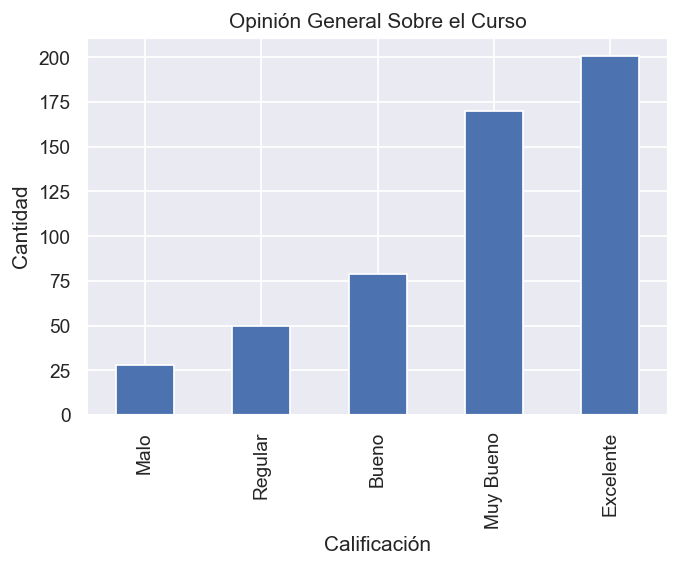

In [8]:
plt.figure(dpi=125)
plt.title("Opinión General Sobre el Curso")
ax = comp["Opinión General Sobre el Curso"].value_counts().sort_index().plot(kind="bar")
ax.set_xticklabels(
    [reverse_map(map_opinion)[int(x.get_text())] for x in ax.get_xticklabels()]
)
plt.xlabel("Calificación")
plt.ylabel("Cantidad")
plt.show()

## Cantidad de Encuestados por Curso
Cantidad de encuestas completadas por cada Curso.

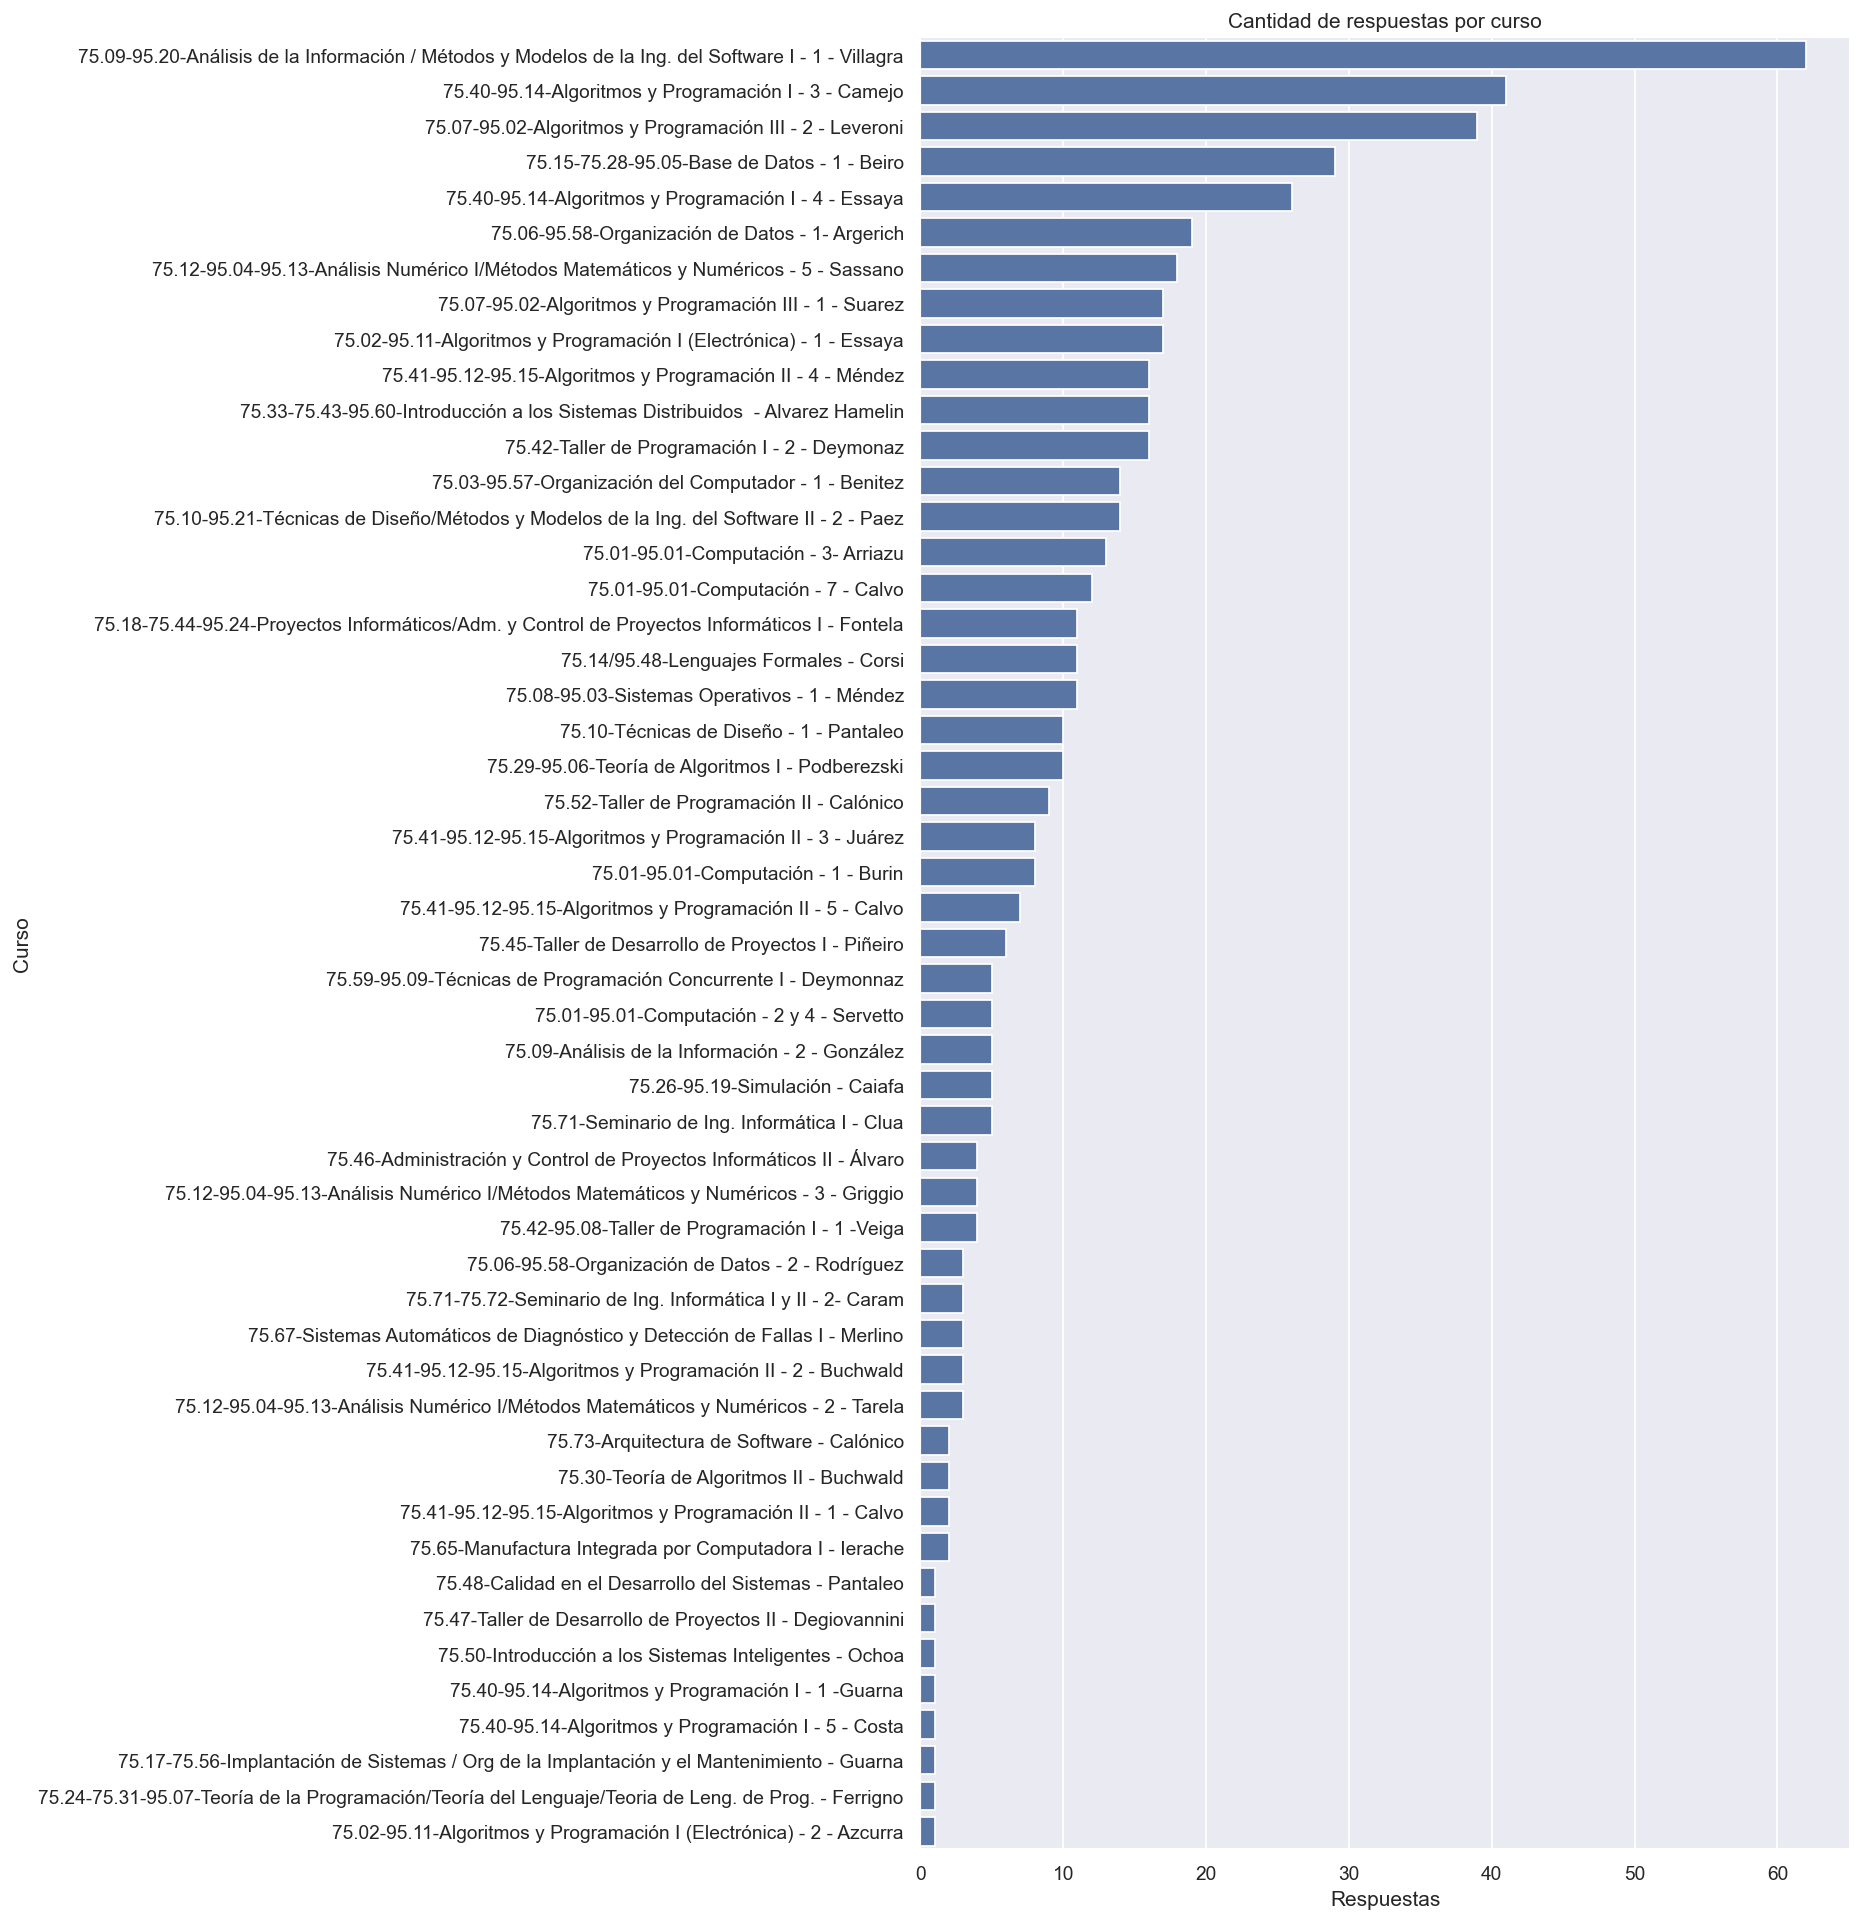

In [9]:
plt.figure(dpi=125, figsize=(6.4 * 1.5, 4.8 * 4))

data = comp["Elige el curso"].value_counts().sort_values(ascending=False)
ax = sns.barplot(x=data.values, y=data.index, color="b")

plt.title("Cantidad de respuestas por curso")
plt.xlabel("Respuestas")
plt.ylabel("Curso")

plt.show()

## Varianza de la Opinión por Curso
Este gráfico muestra la variabilidad de la pregunta "Opinión General Sobre el Curso", a menor valor mas consistentes los resultados de la encuesta. Los valores mayores muestran disparidad de resultados en cuanto a la opinión general sobre el curso.

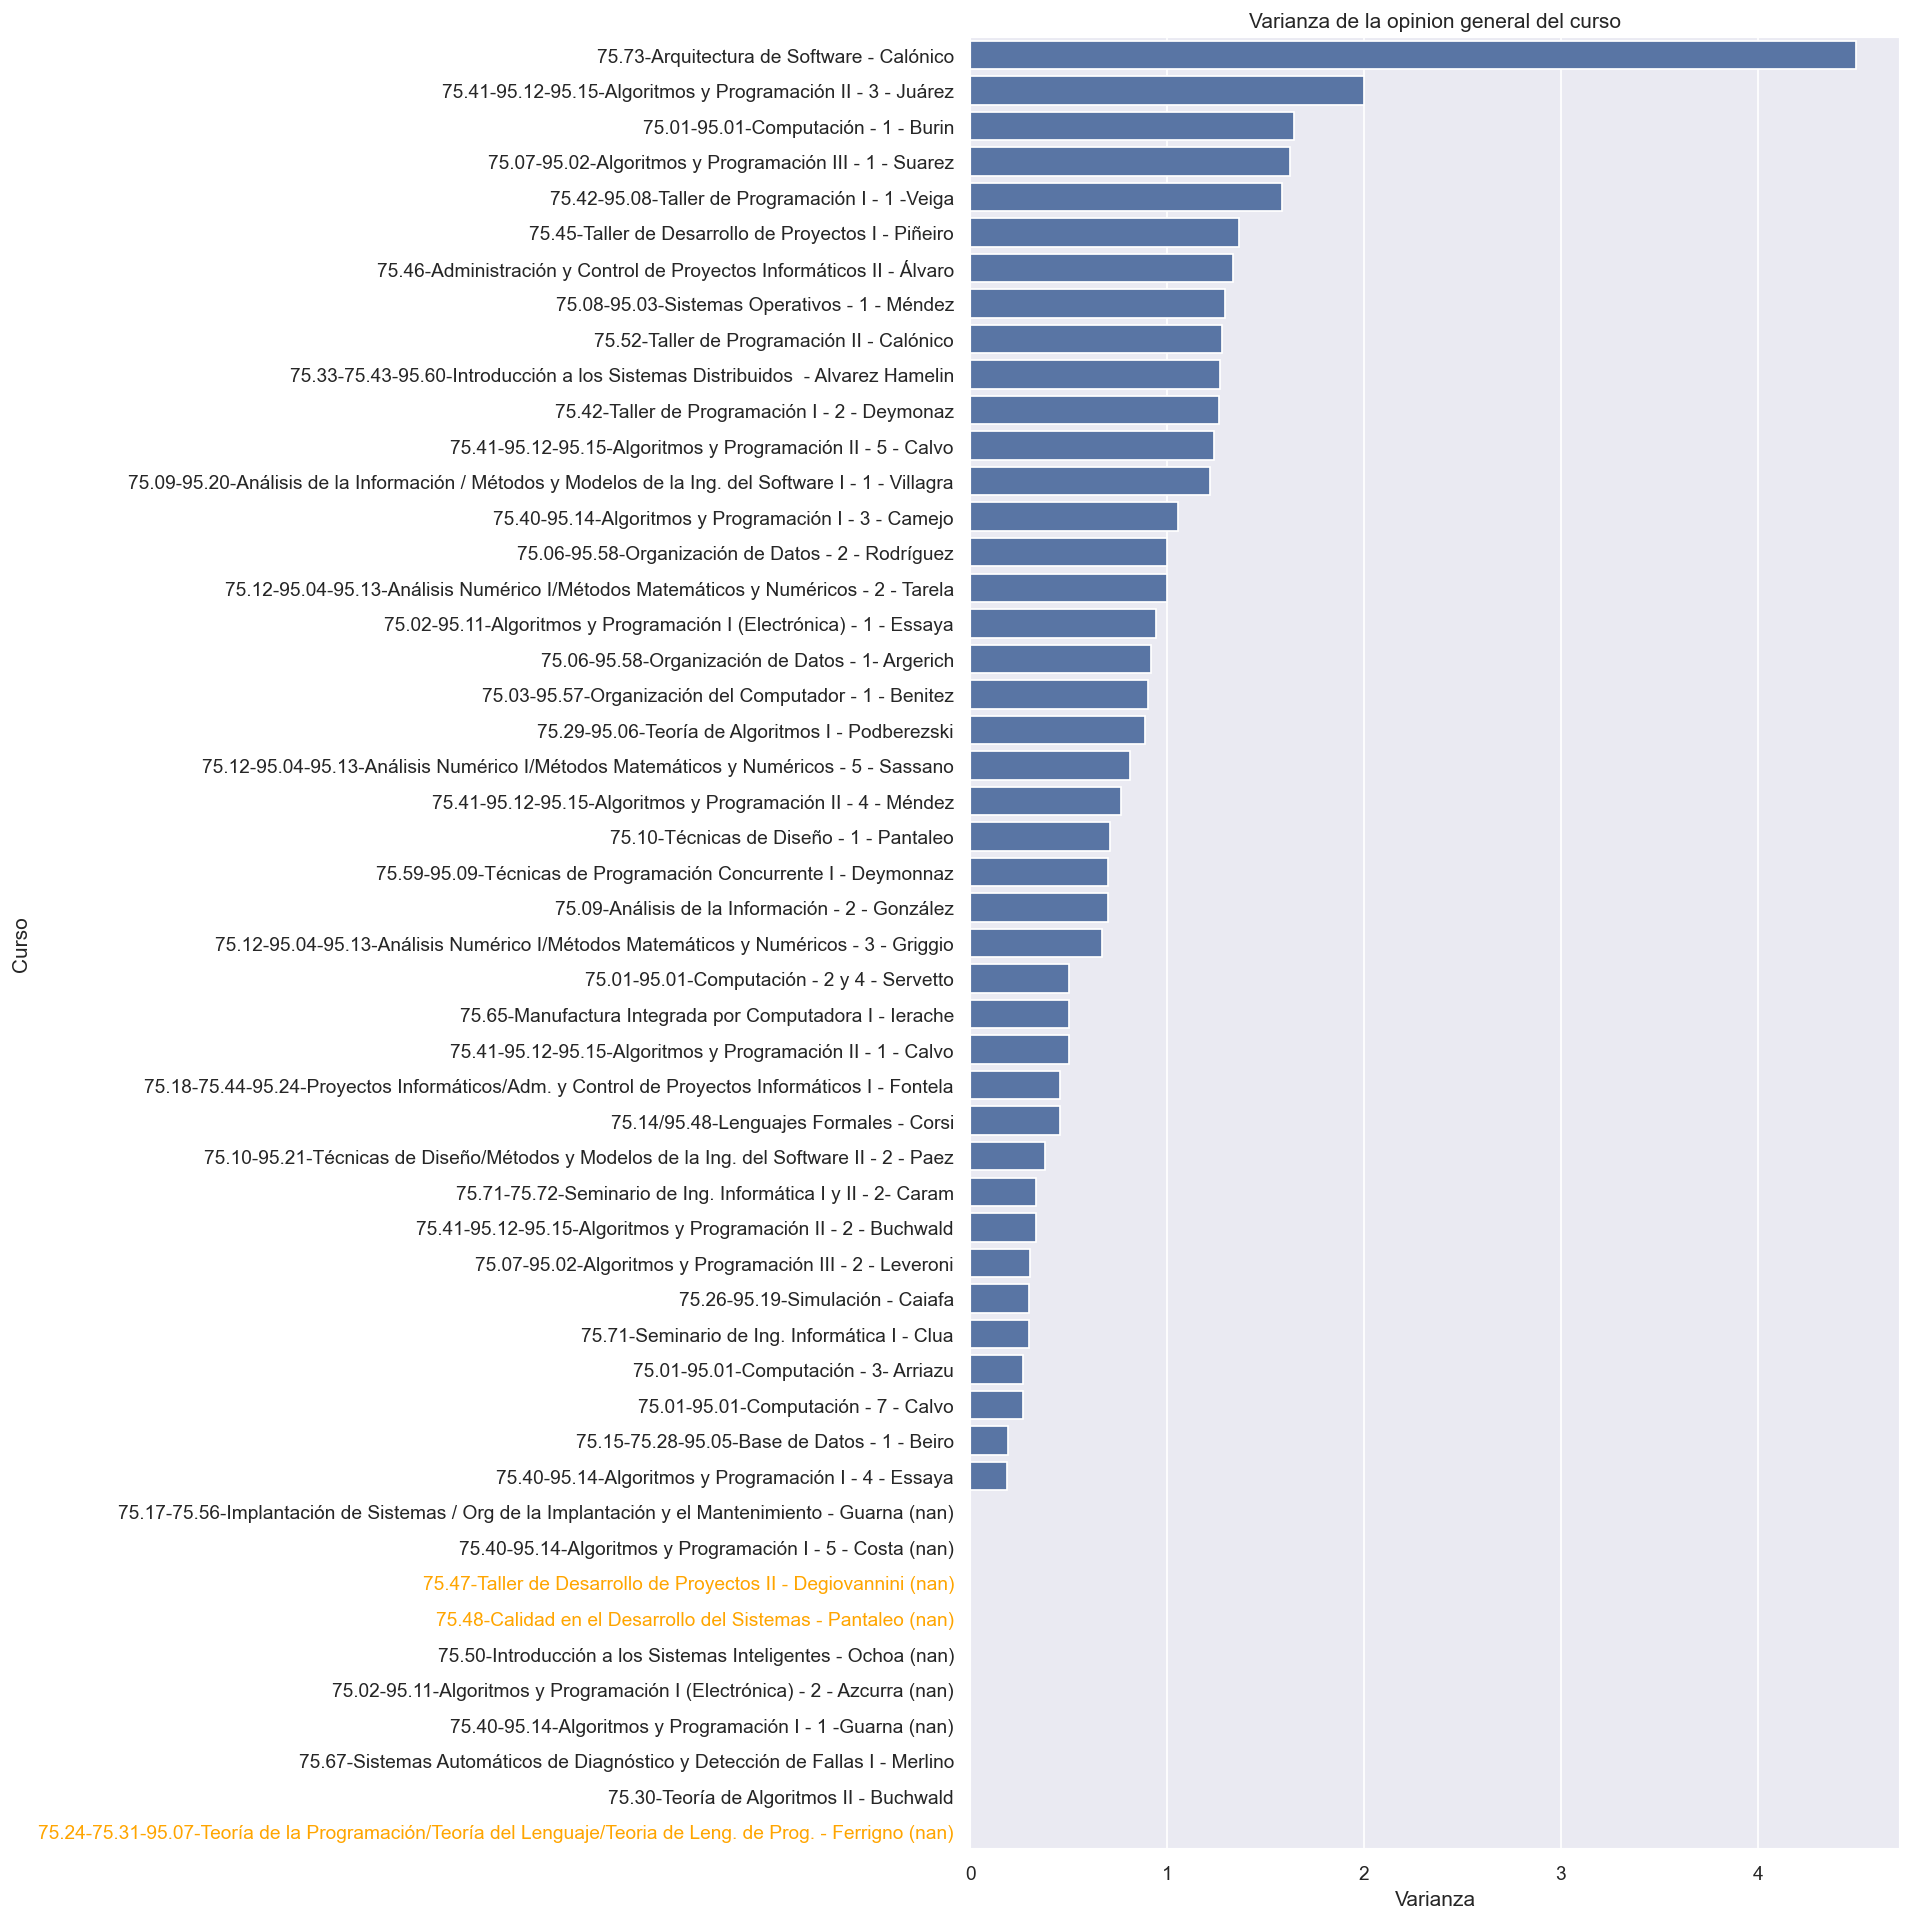

In [10]:
plt.figure(dpi=125, figsize=(6.4 * 1.5, 4.8 * 4))

var_curso = comp.groupby("Elige el curso")["Opinión General Sobre el Curso"].var()
nan_var = var_curso[var_curso.isna()].index.tolist()

data = var_curso.fillna(0).sort_values(ascending=False)

ax = sns.barplot(x=data.values, y=data.index, color="b")

ax.set_yticklabels(
    [
        x if x.get_text() not in nan_var else f"{x.get_text()} (nan)"
        for x in ax.get_yticklabels()
    ]
)

for yticklabel in ax.get_yticklabels():
    if yticklabel.get_text().rstrip(" (na)") in nan_var:
        yticklabel.set_color("orange")

plt.title("Varianza de la opinion general del curso")
plt.xlabel("Varianza")
plt.ylabel("Curso")

plt.show()

## Comparativa de promedios por pregunta
Esta matriz muestra el promedio de calificaciones para cada pregunta de la encuesta para los cursos que tienen 5 o mas encuestas. Orden alfabético por curso.

In [11]:
num_cols = [
    "Opinión General Sobre el Curso",
    "¿Aprobó la Cursada?",
    "¿Cómo te Resultaron los Temas de la Materia?",
    "¿Los Temas de la Materia Están Actualizados?",
    "Nivel de las Clases Teóricas del Curso",
    "Nivel de las Clases Prácticas del Curso",
    "Dificultad del Curso",
    "Dificultad del TP",
    "Promedio nivel teóricas y prácticas",
]

In [12]:
cursos_5p_respuestas = (
    comp["Elige el curso"]
    .value_counts()
    .where(lambda x: x >= 5)
    .dropna()
    .index.tolist()
)
comp_5p = comp[comp["Elige el curso"].isin(cursos_5p_respuestas)].sort_values(
    by="Elige el curso"
)
comp_5p_mean = comp_5p.groupby("Elige el curso")[num_cols].mean().sort_index()

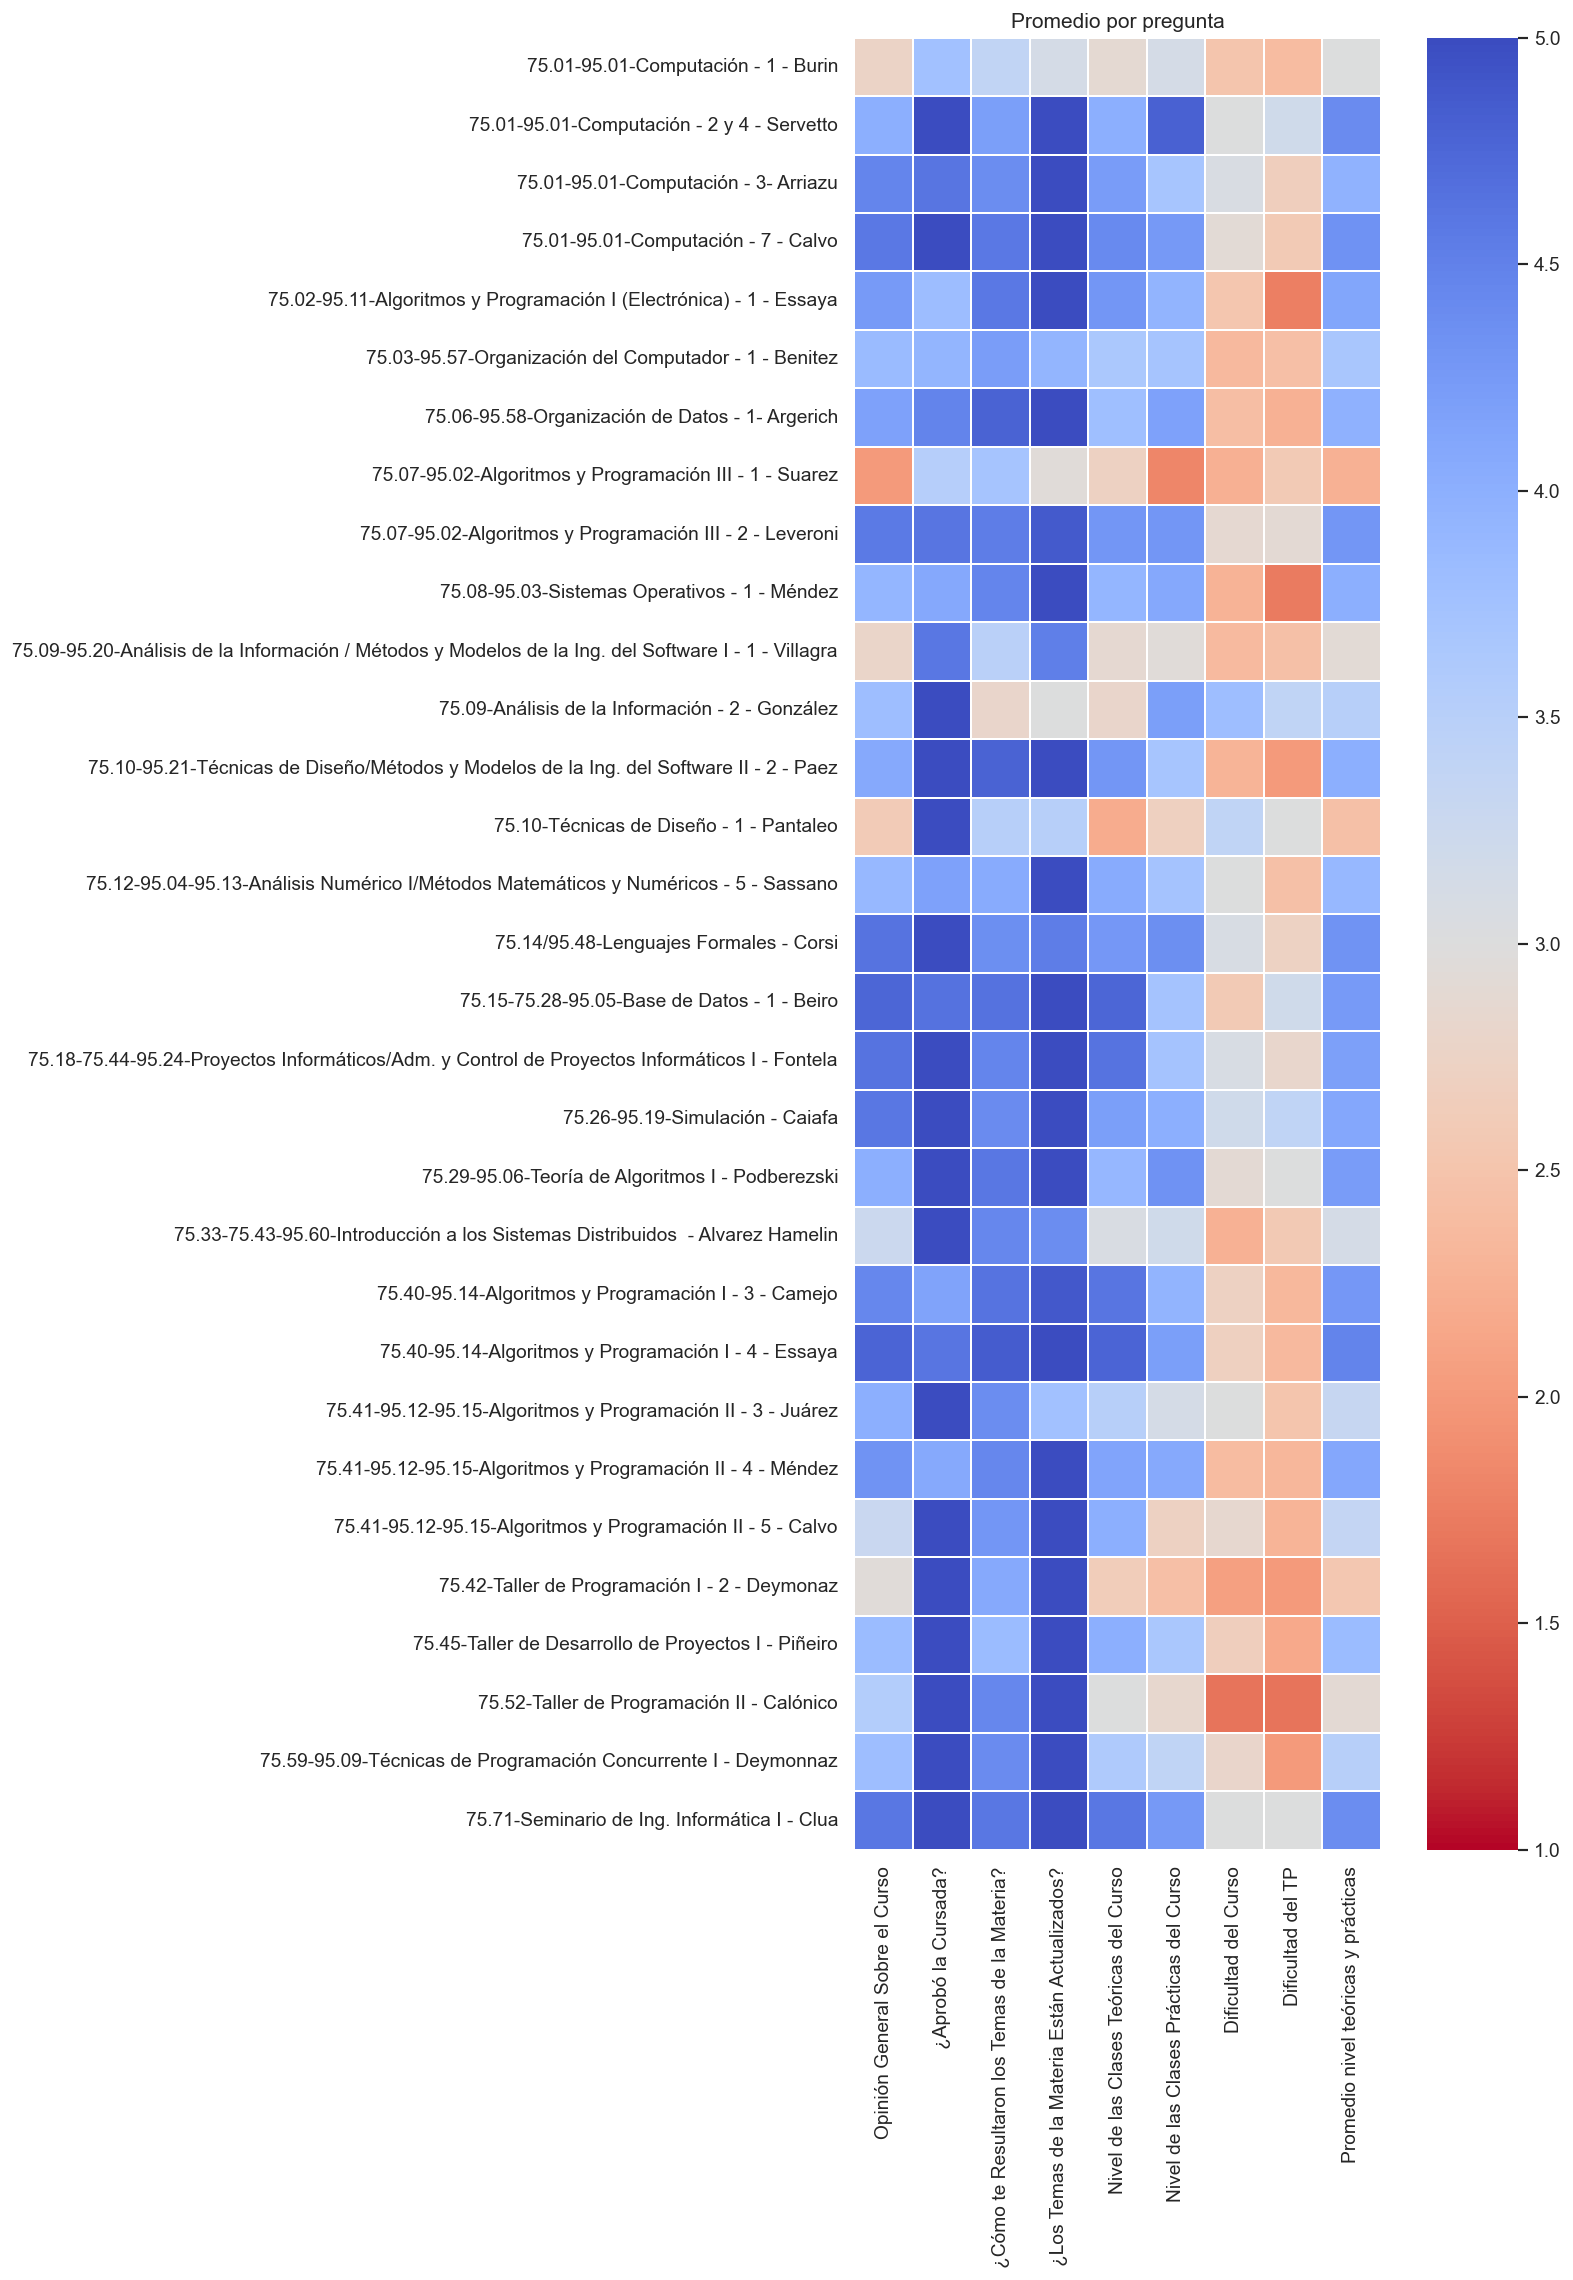

In [13]:
plt.figure(dpi=125, figsize=(6.4 * 1.5, 4.8 * 4))

sns.heatmap(
    data=comp_5p_mean, cmap="coolwarm_r", linewidths=0.2, square=True, vmin=1, vmax=5
)
plt.ylabel("")
plt.title("Promedio por pregunta")
plt.show()

## Histograma de promedios por pregunta
Por cada curso se calcula el promedio de cada pregunta numérica y luego se hace un histograma de esos promedios.

### Histograma de promedios de Opinión General Sobre el Curso

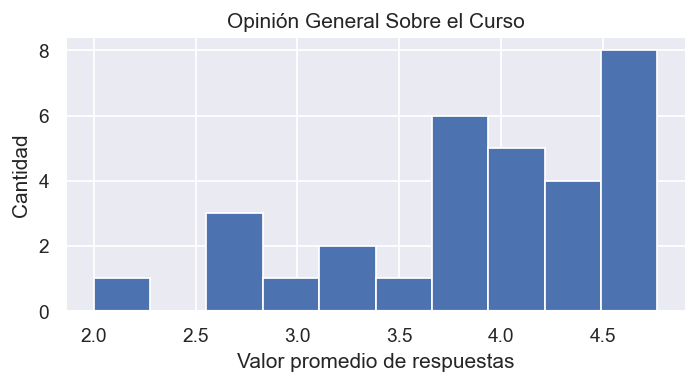

### Histograma de promedios de ¿Aprobó la Cursada?

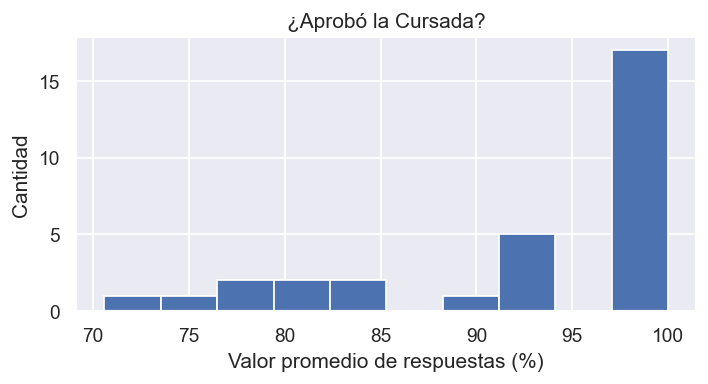

### Histograma de promedios de ¿Cómo te Resultaron los Temas de la Materia?

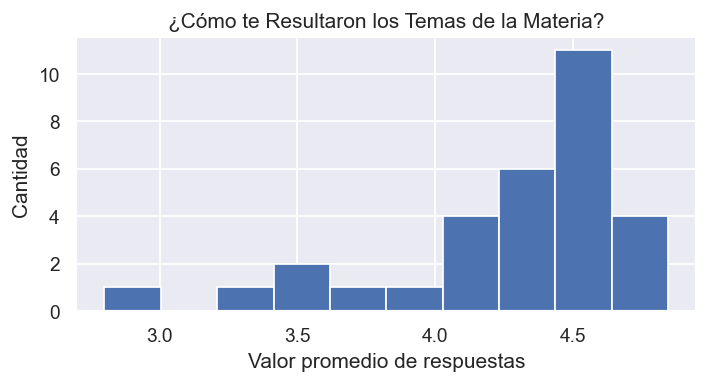

### Histograma de promedios de ¿Los Temas de la Materia Están Actualizados?

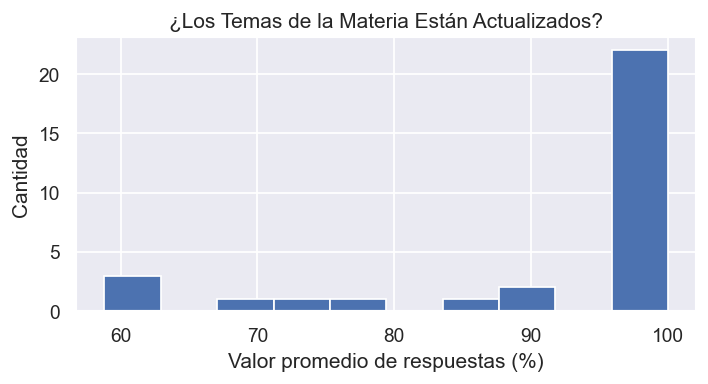

### Histograma de promedios de Nivel de las Clases Teóricas del Curso

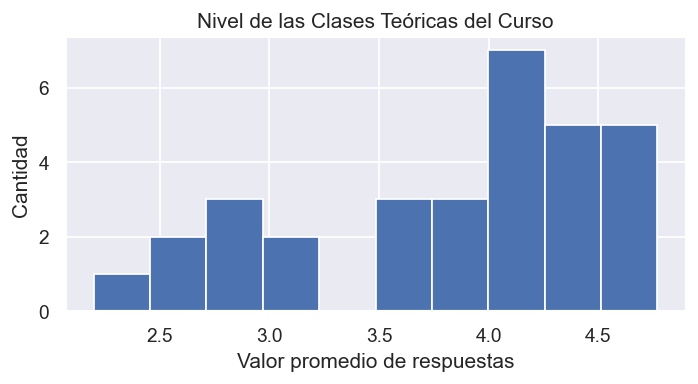

### Histograma de promedios de Nivel de las Clases Prácticas del Curso

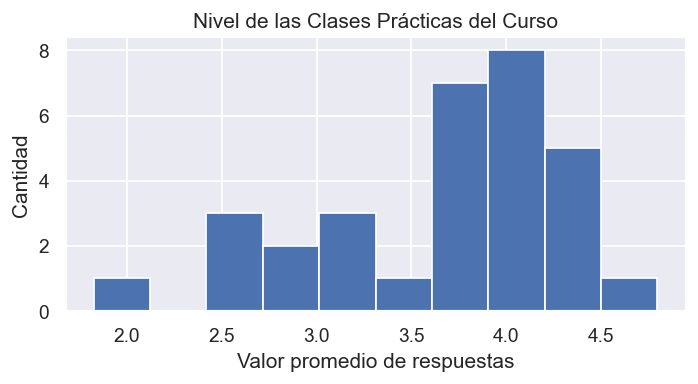

### Histograma de promedios de Dificultad del Curso

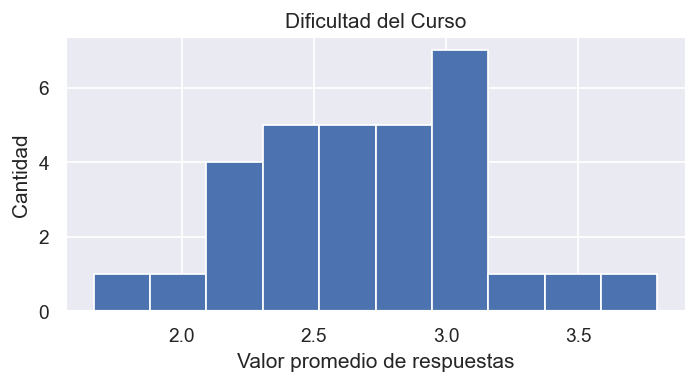

### Histograma de promedios de Dificultad del TP

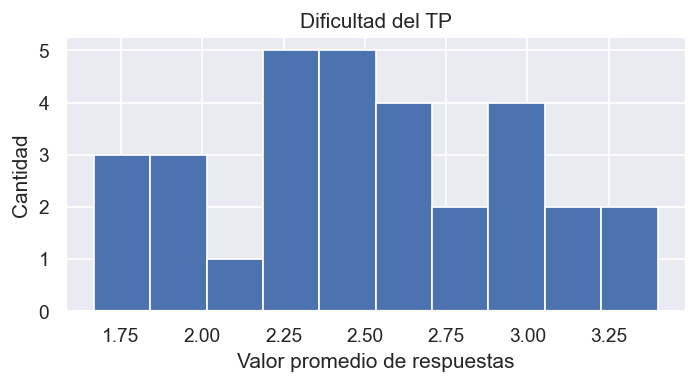

### Histograma de promedios de Promedio nivel teóricas y prácticas

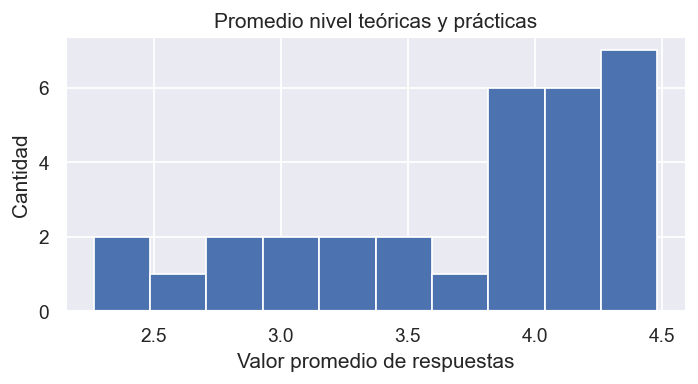

In [14]:
for col in num_cols:

    display(Markdown(f"### Histograma de promedios de {col}"))
    fig = plt.figure(dpi=125, figsize=(6.4, 2.9))

    values = comp_5p_mean[col].copy()
    if col in cols_sino:
        values *= 20

    plt.hist(values, bins=10)
    plt.title(col)
    plt.ylabel("Cantidad")

    xlabel = "Valor promedio de respuestas"
    if col in cols_sino:
        xlabel = f"{xlabel} (%)"

    plt.xlabel(xlabel)
    plt.show()

## Ranking de cursos por promedio

### Opinión General Sobre el Curso

Se analizan los promedios por curso de Opinión General Sobre el Curso. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

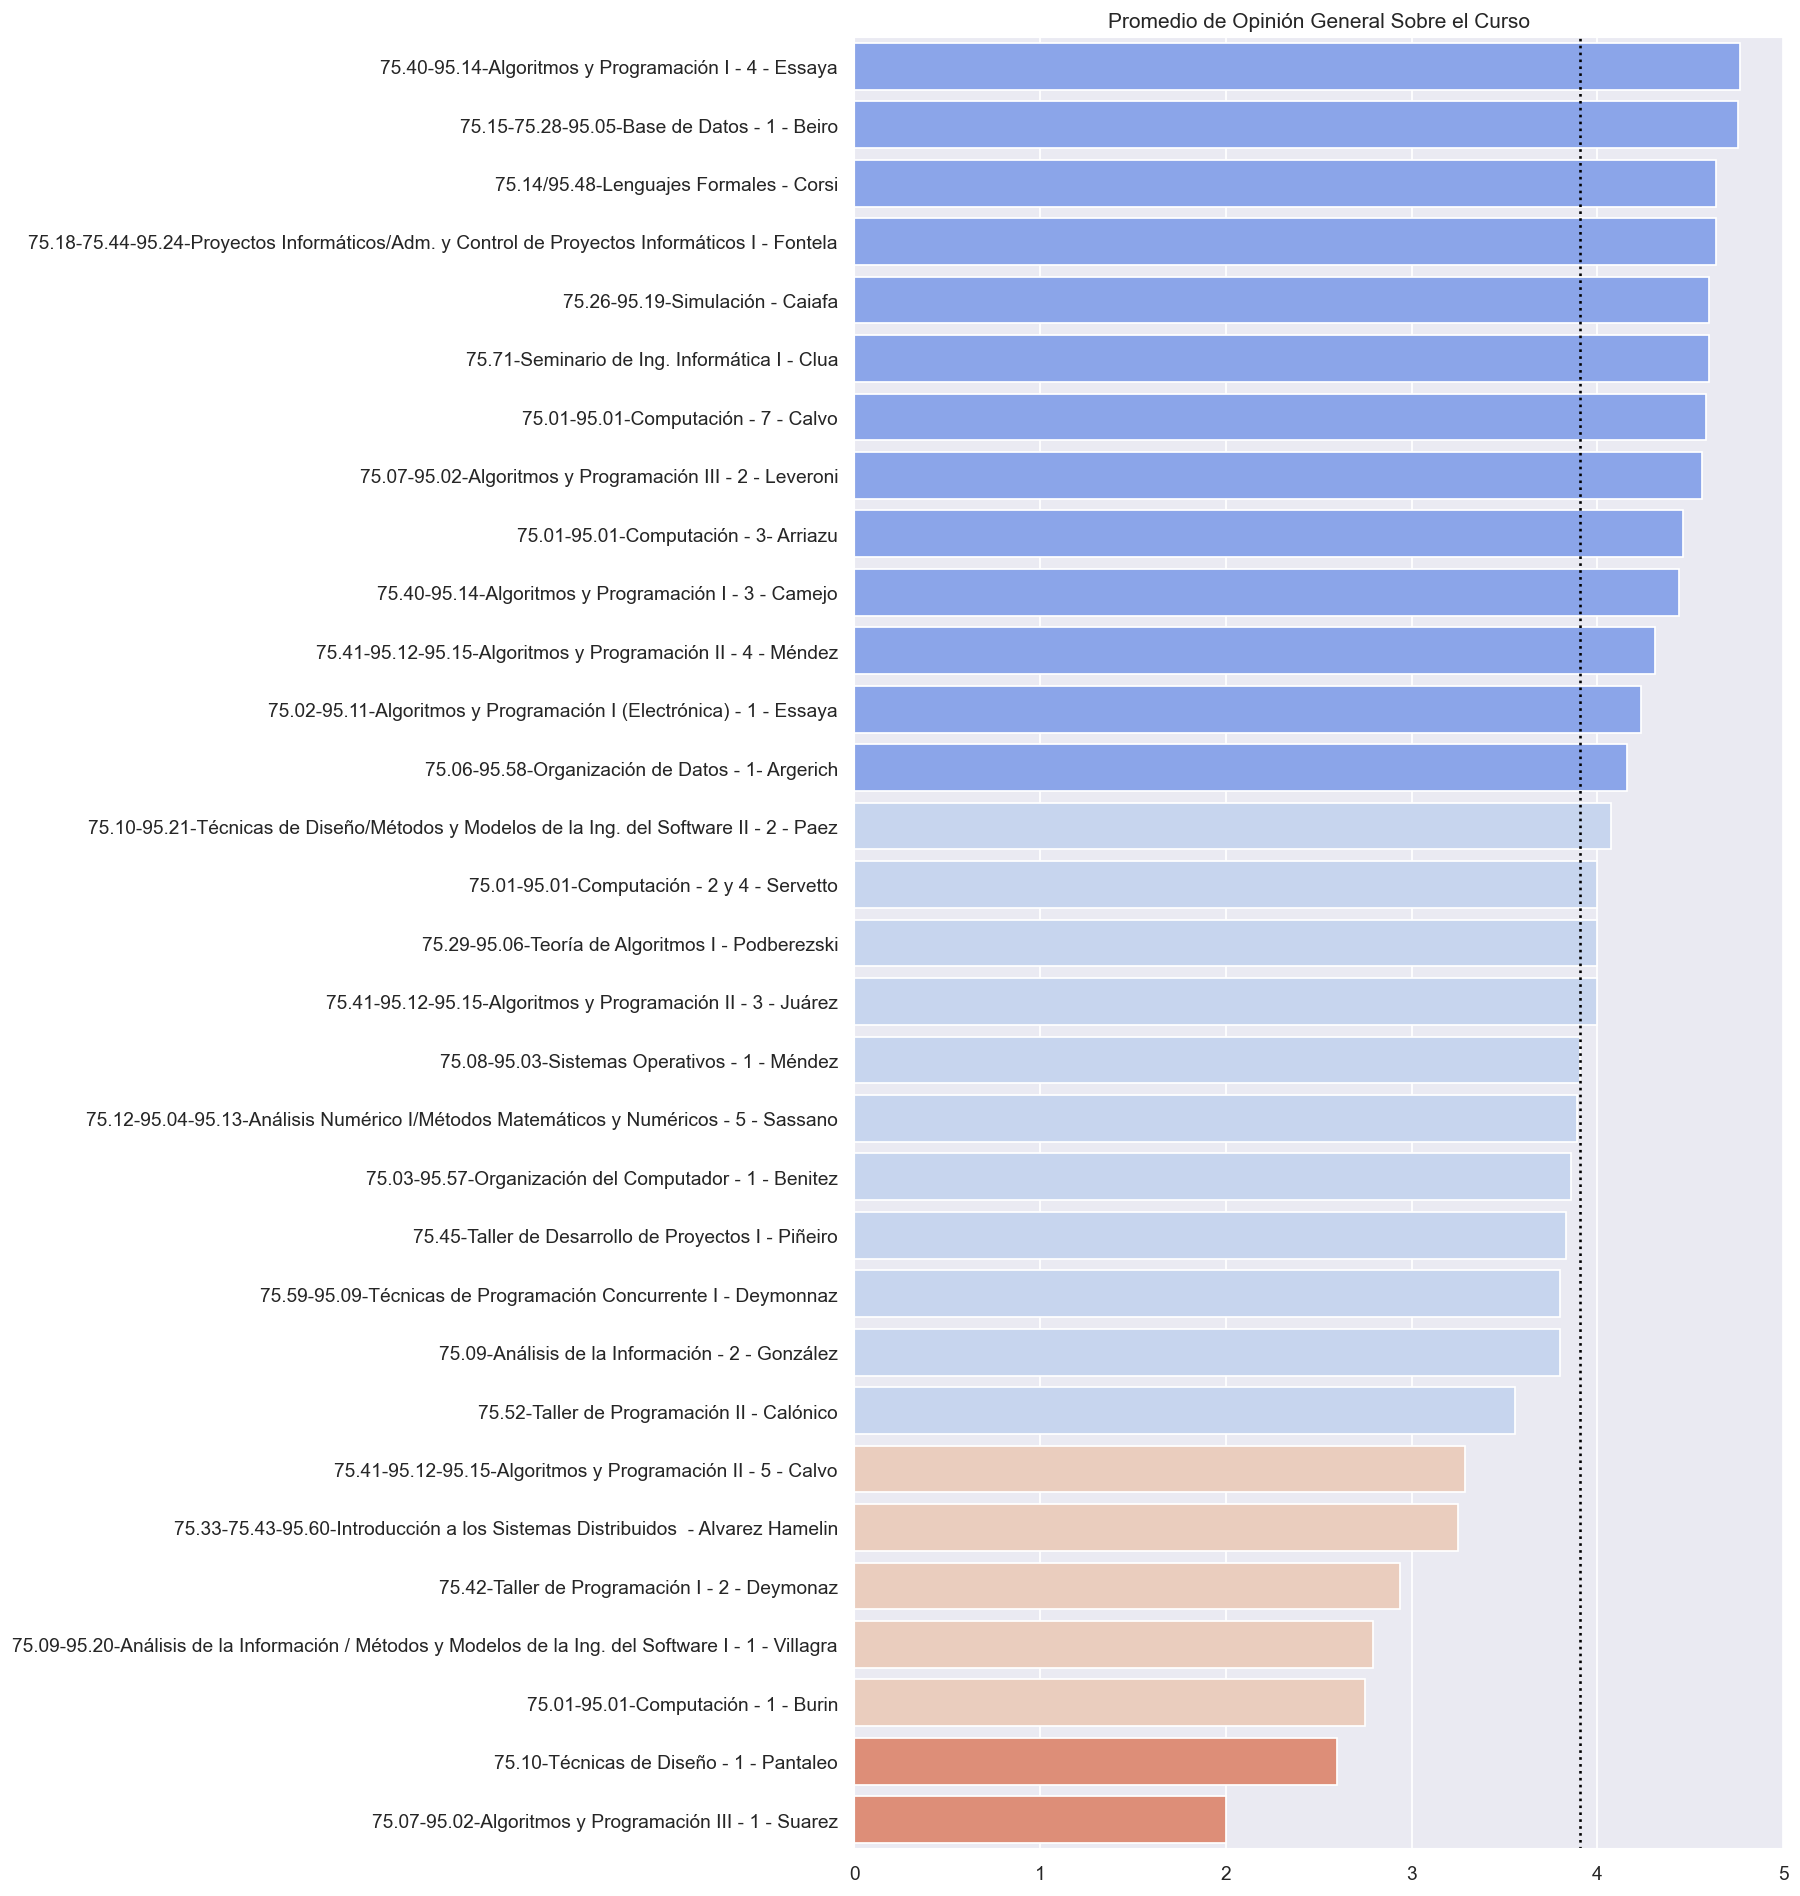

### ¿Aprobó la Cursada?

Se analizan los promedios por curso de ¿Aprobó la Cursada?. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

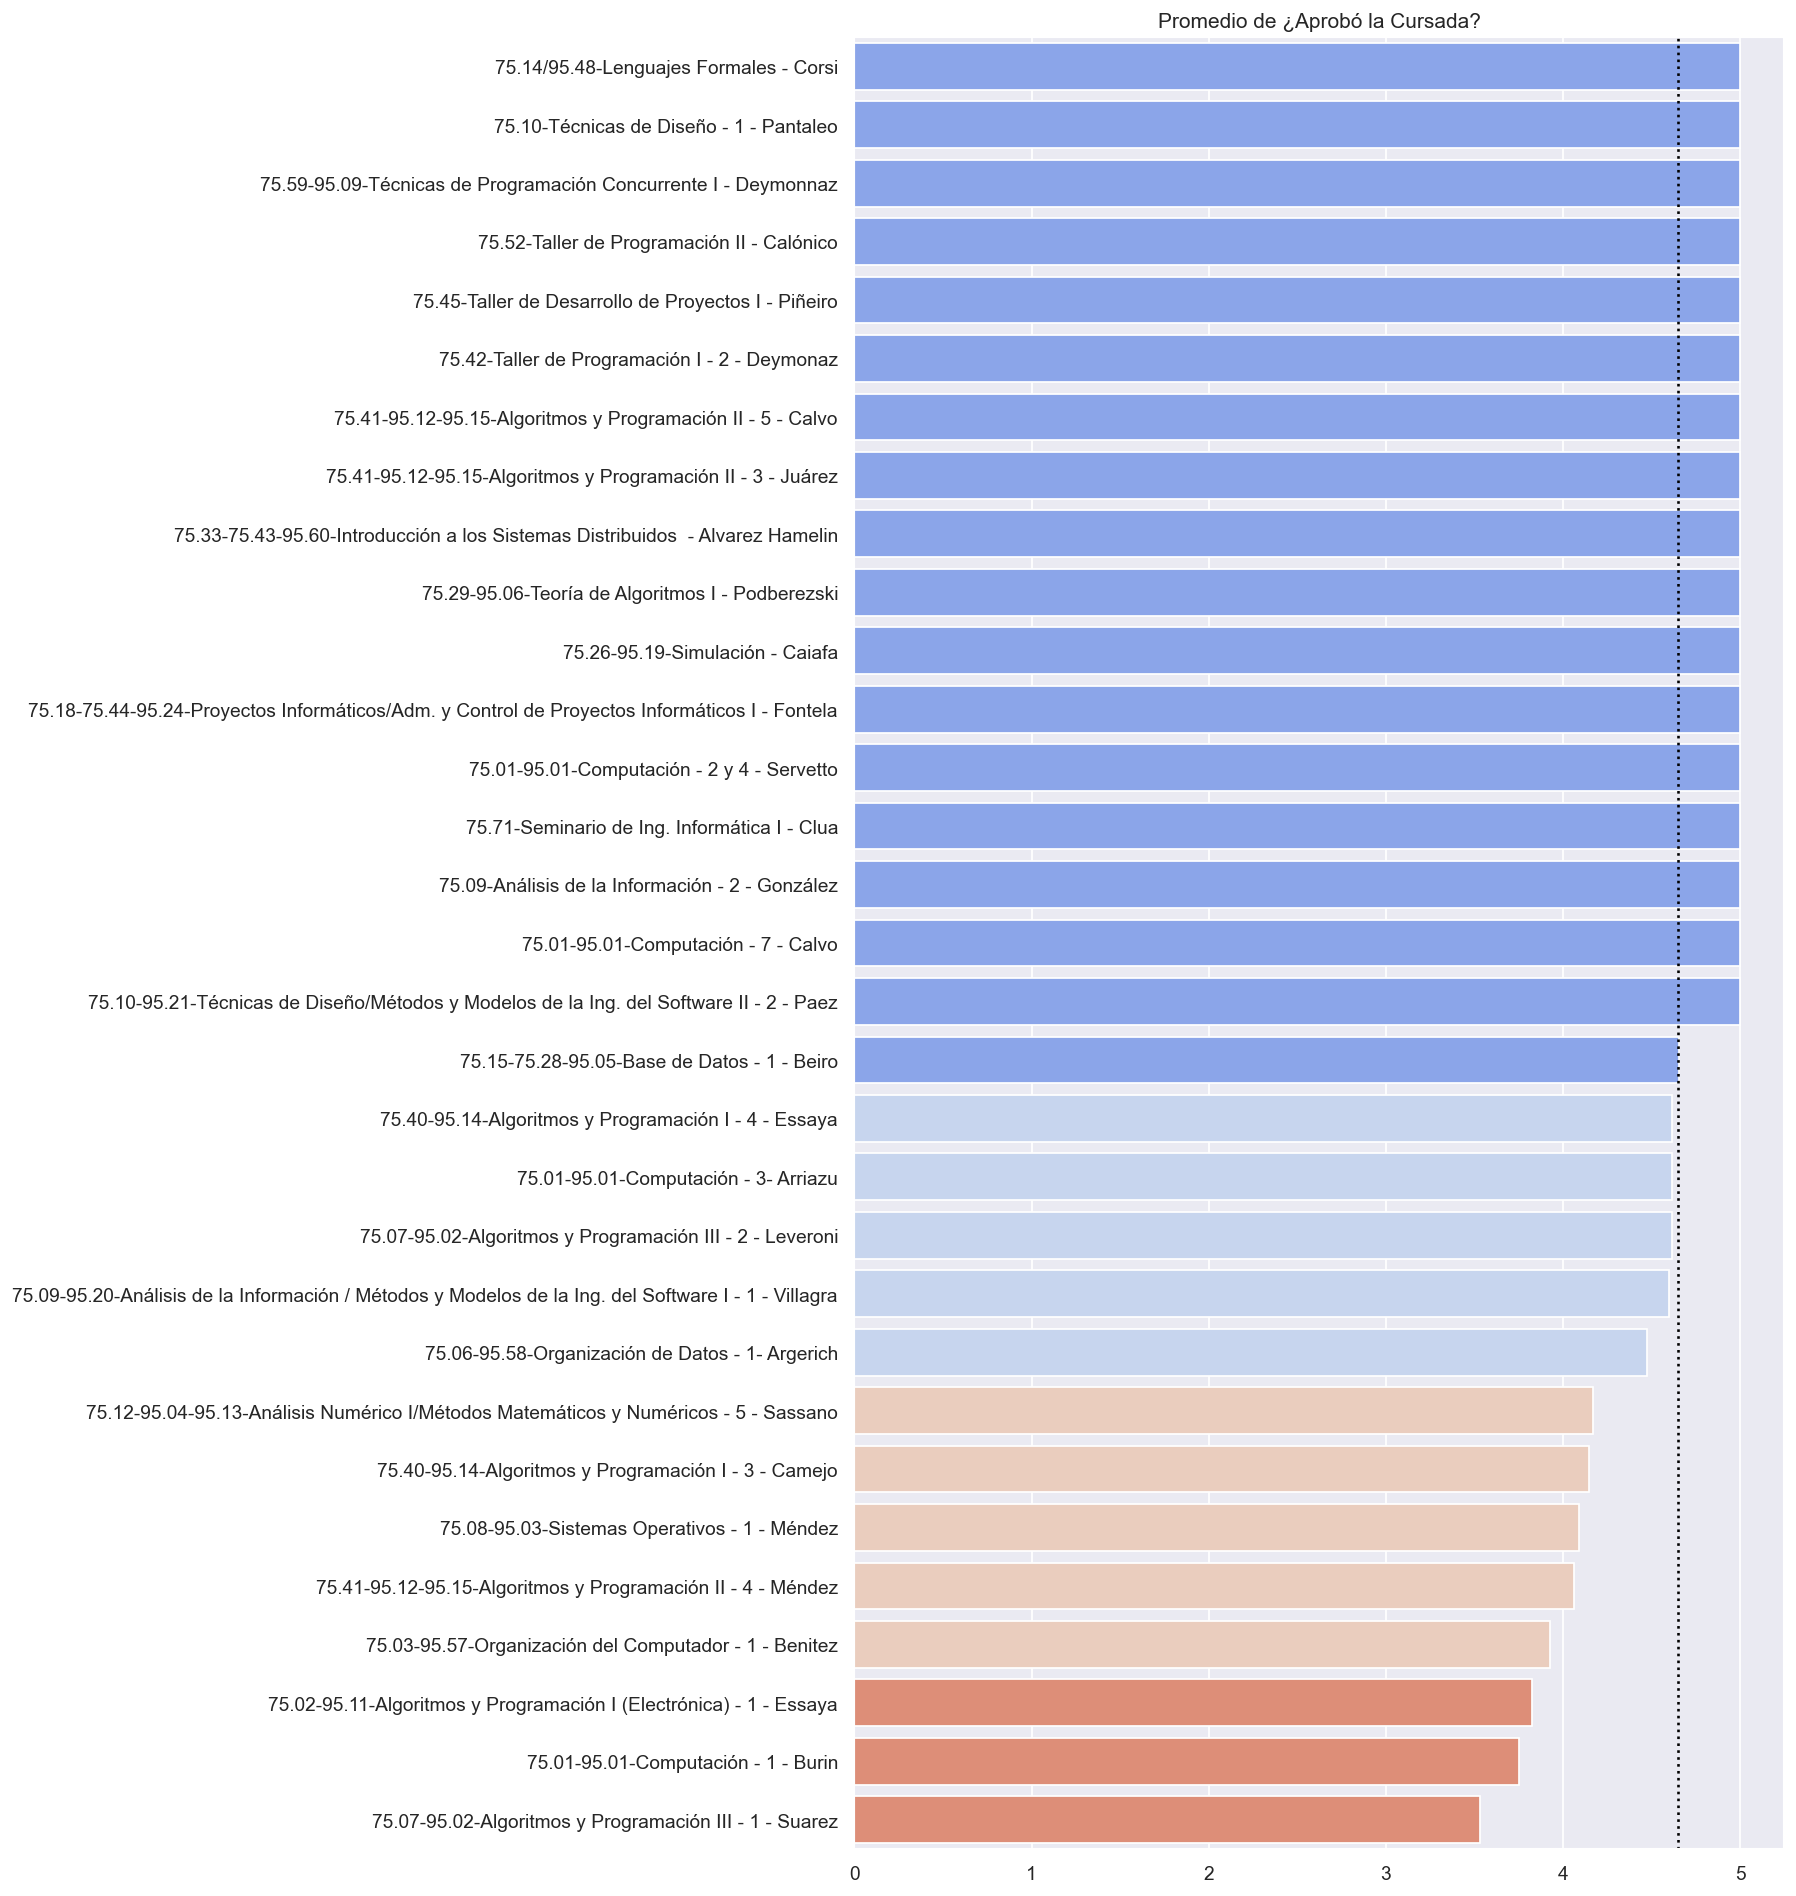

### ¿Cómo te Resultaron los Temas de la Materia?

Se analizan los promedios por curso de ¿Cómo te Resultaron los Temas de la Materia?. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

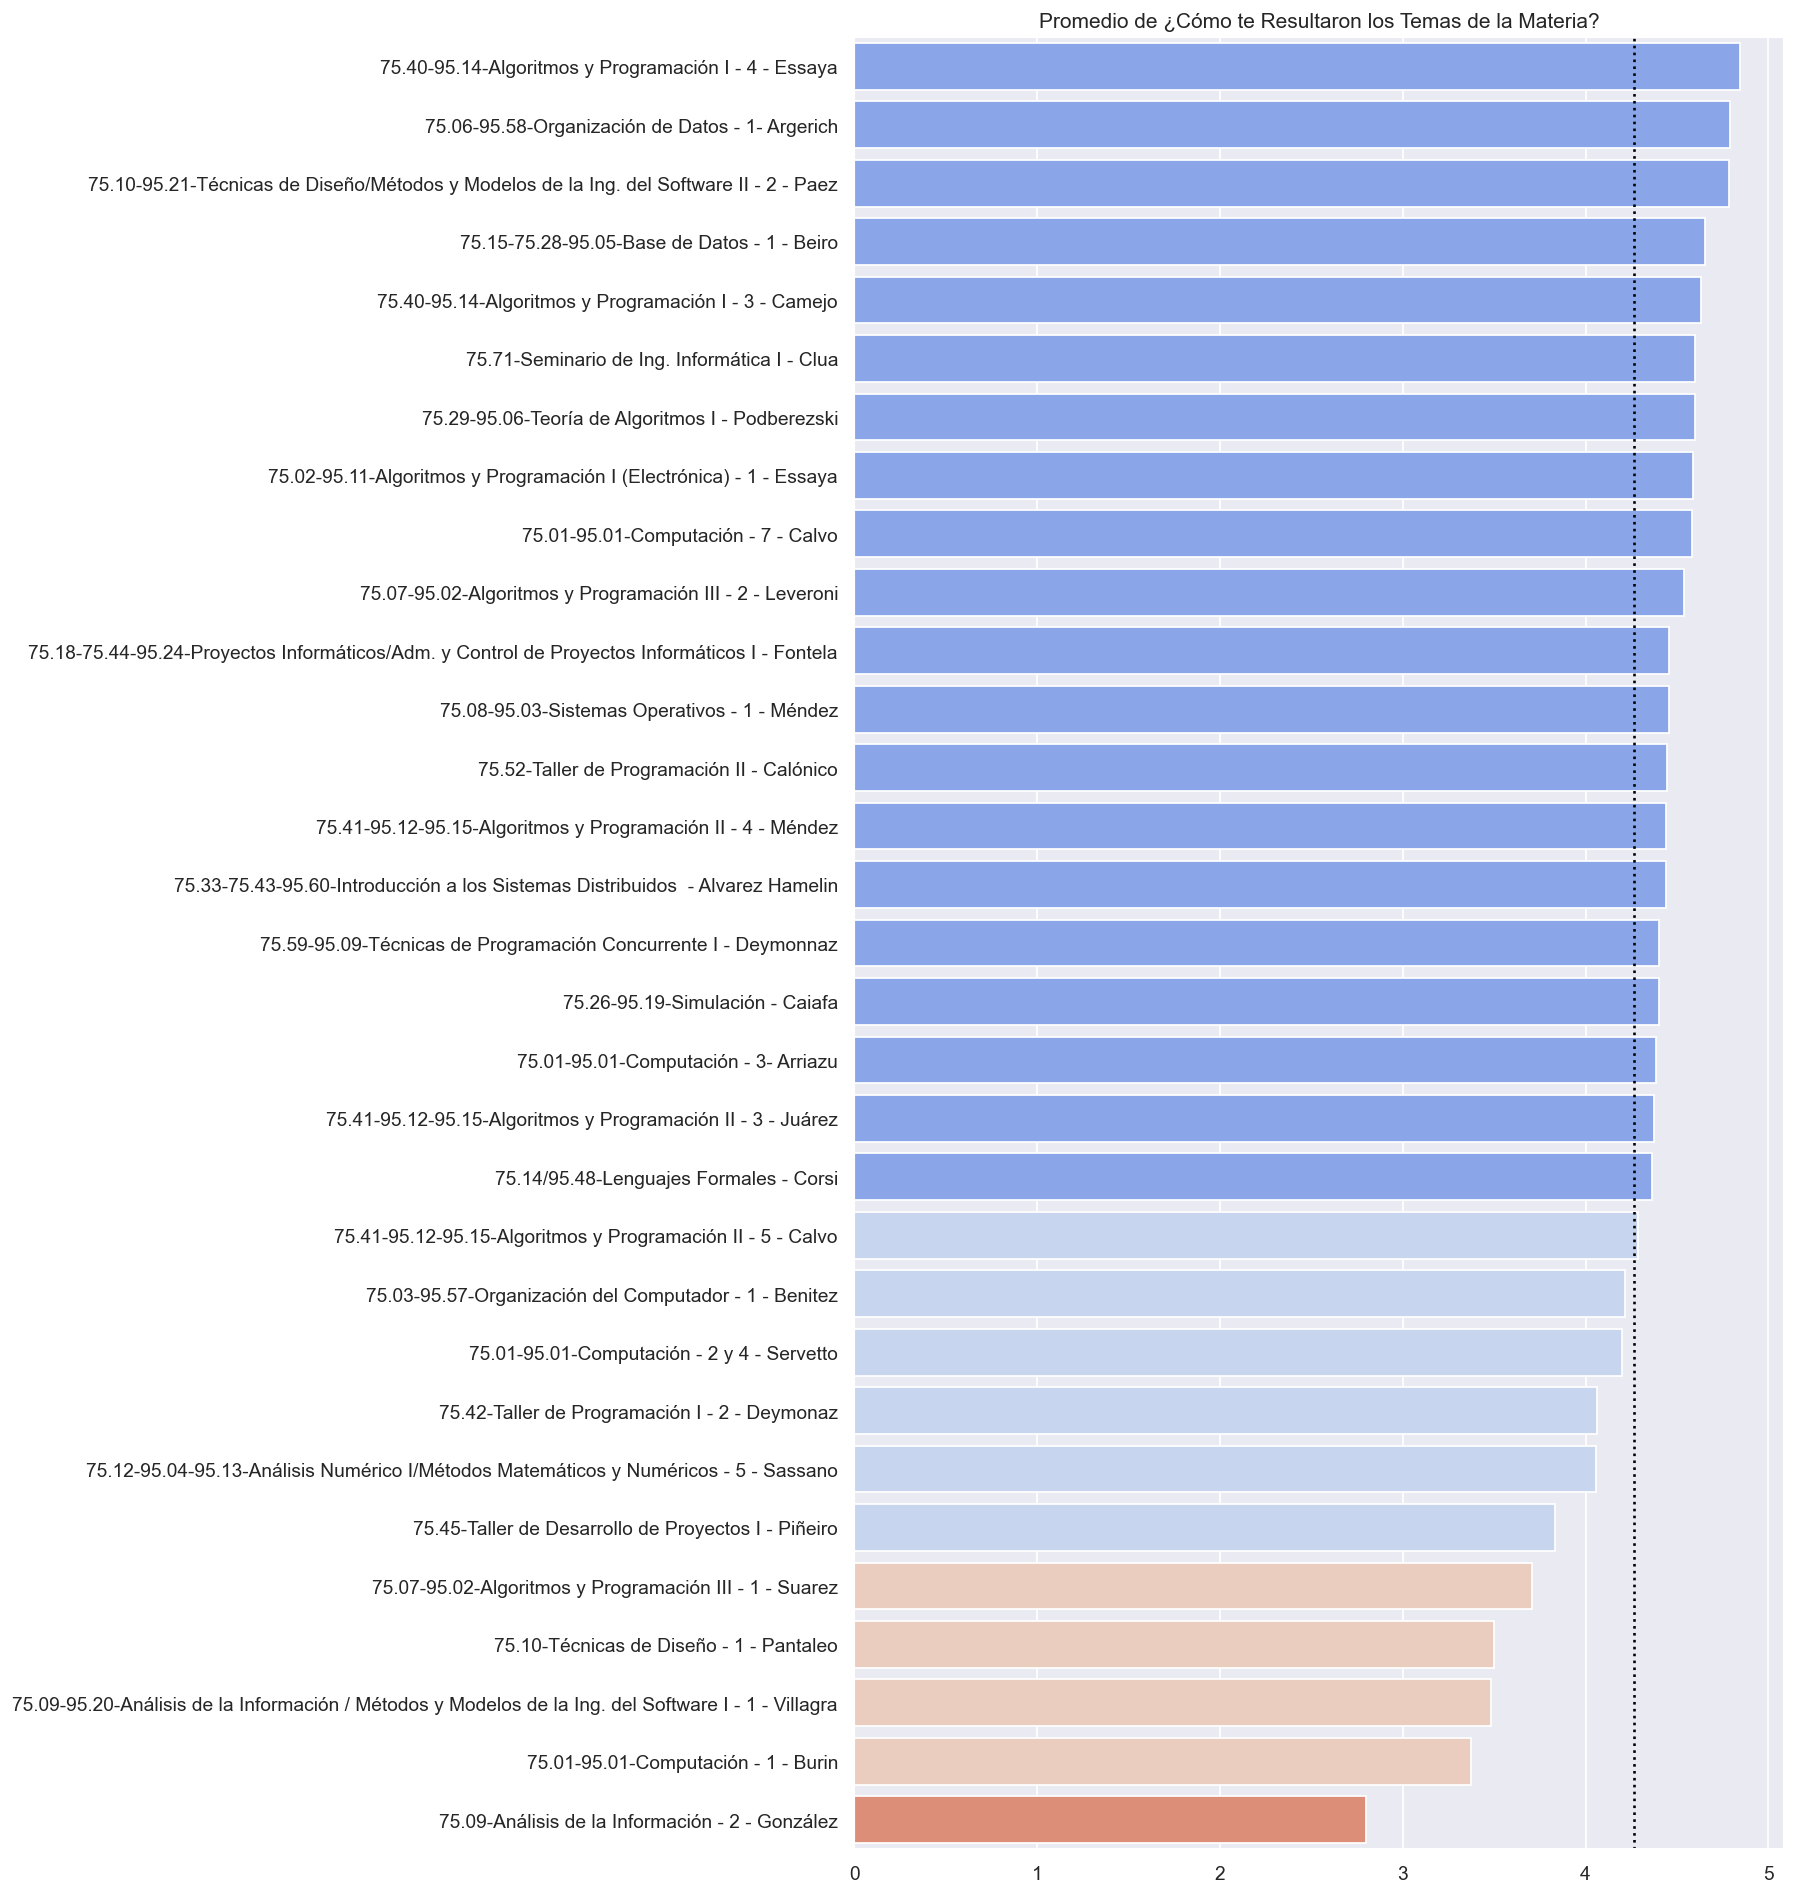

### ¿Los Temas de la Materia Están Actualizados?

Se analizan los promedios por curso de ¿Los Temas de la Materia Están Actualizados?. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

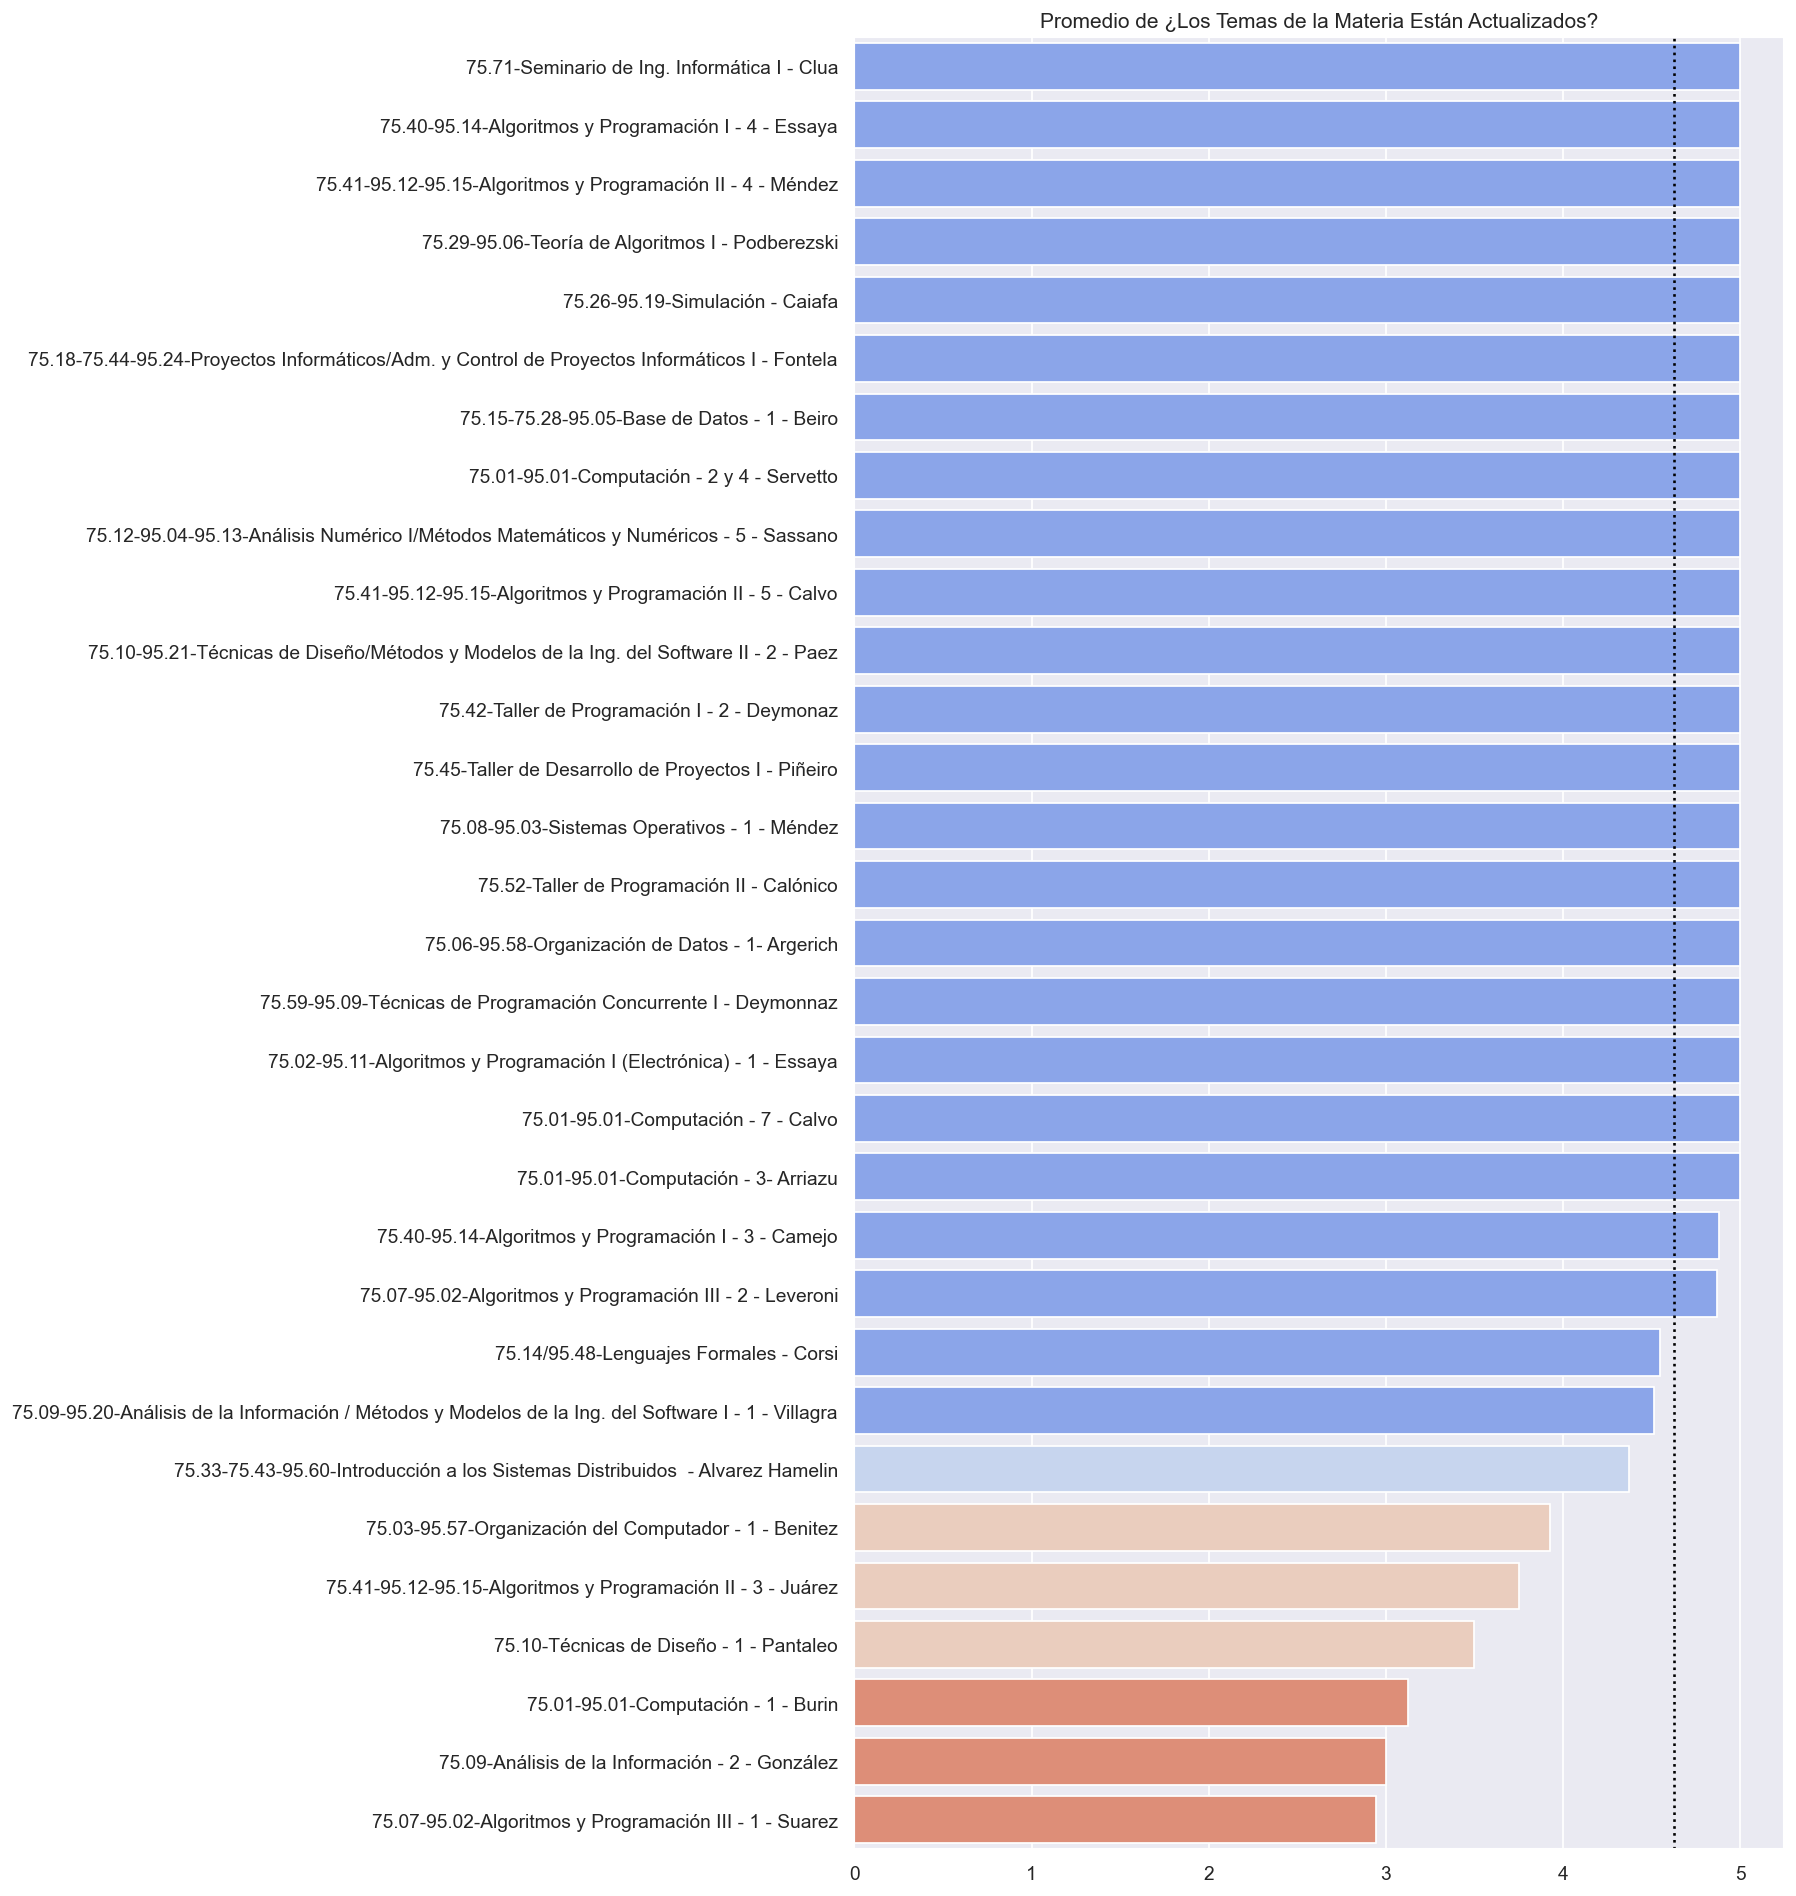

### Nivel de las Clases Teóricas del Curso

Se analizan los promedios por curso de Nivel de las Clases Teóricas del Curso. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

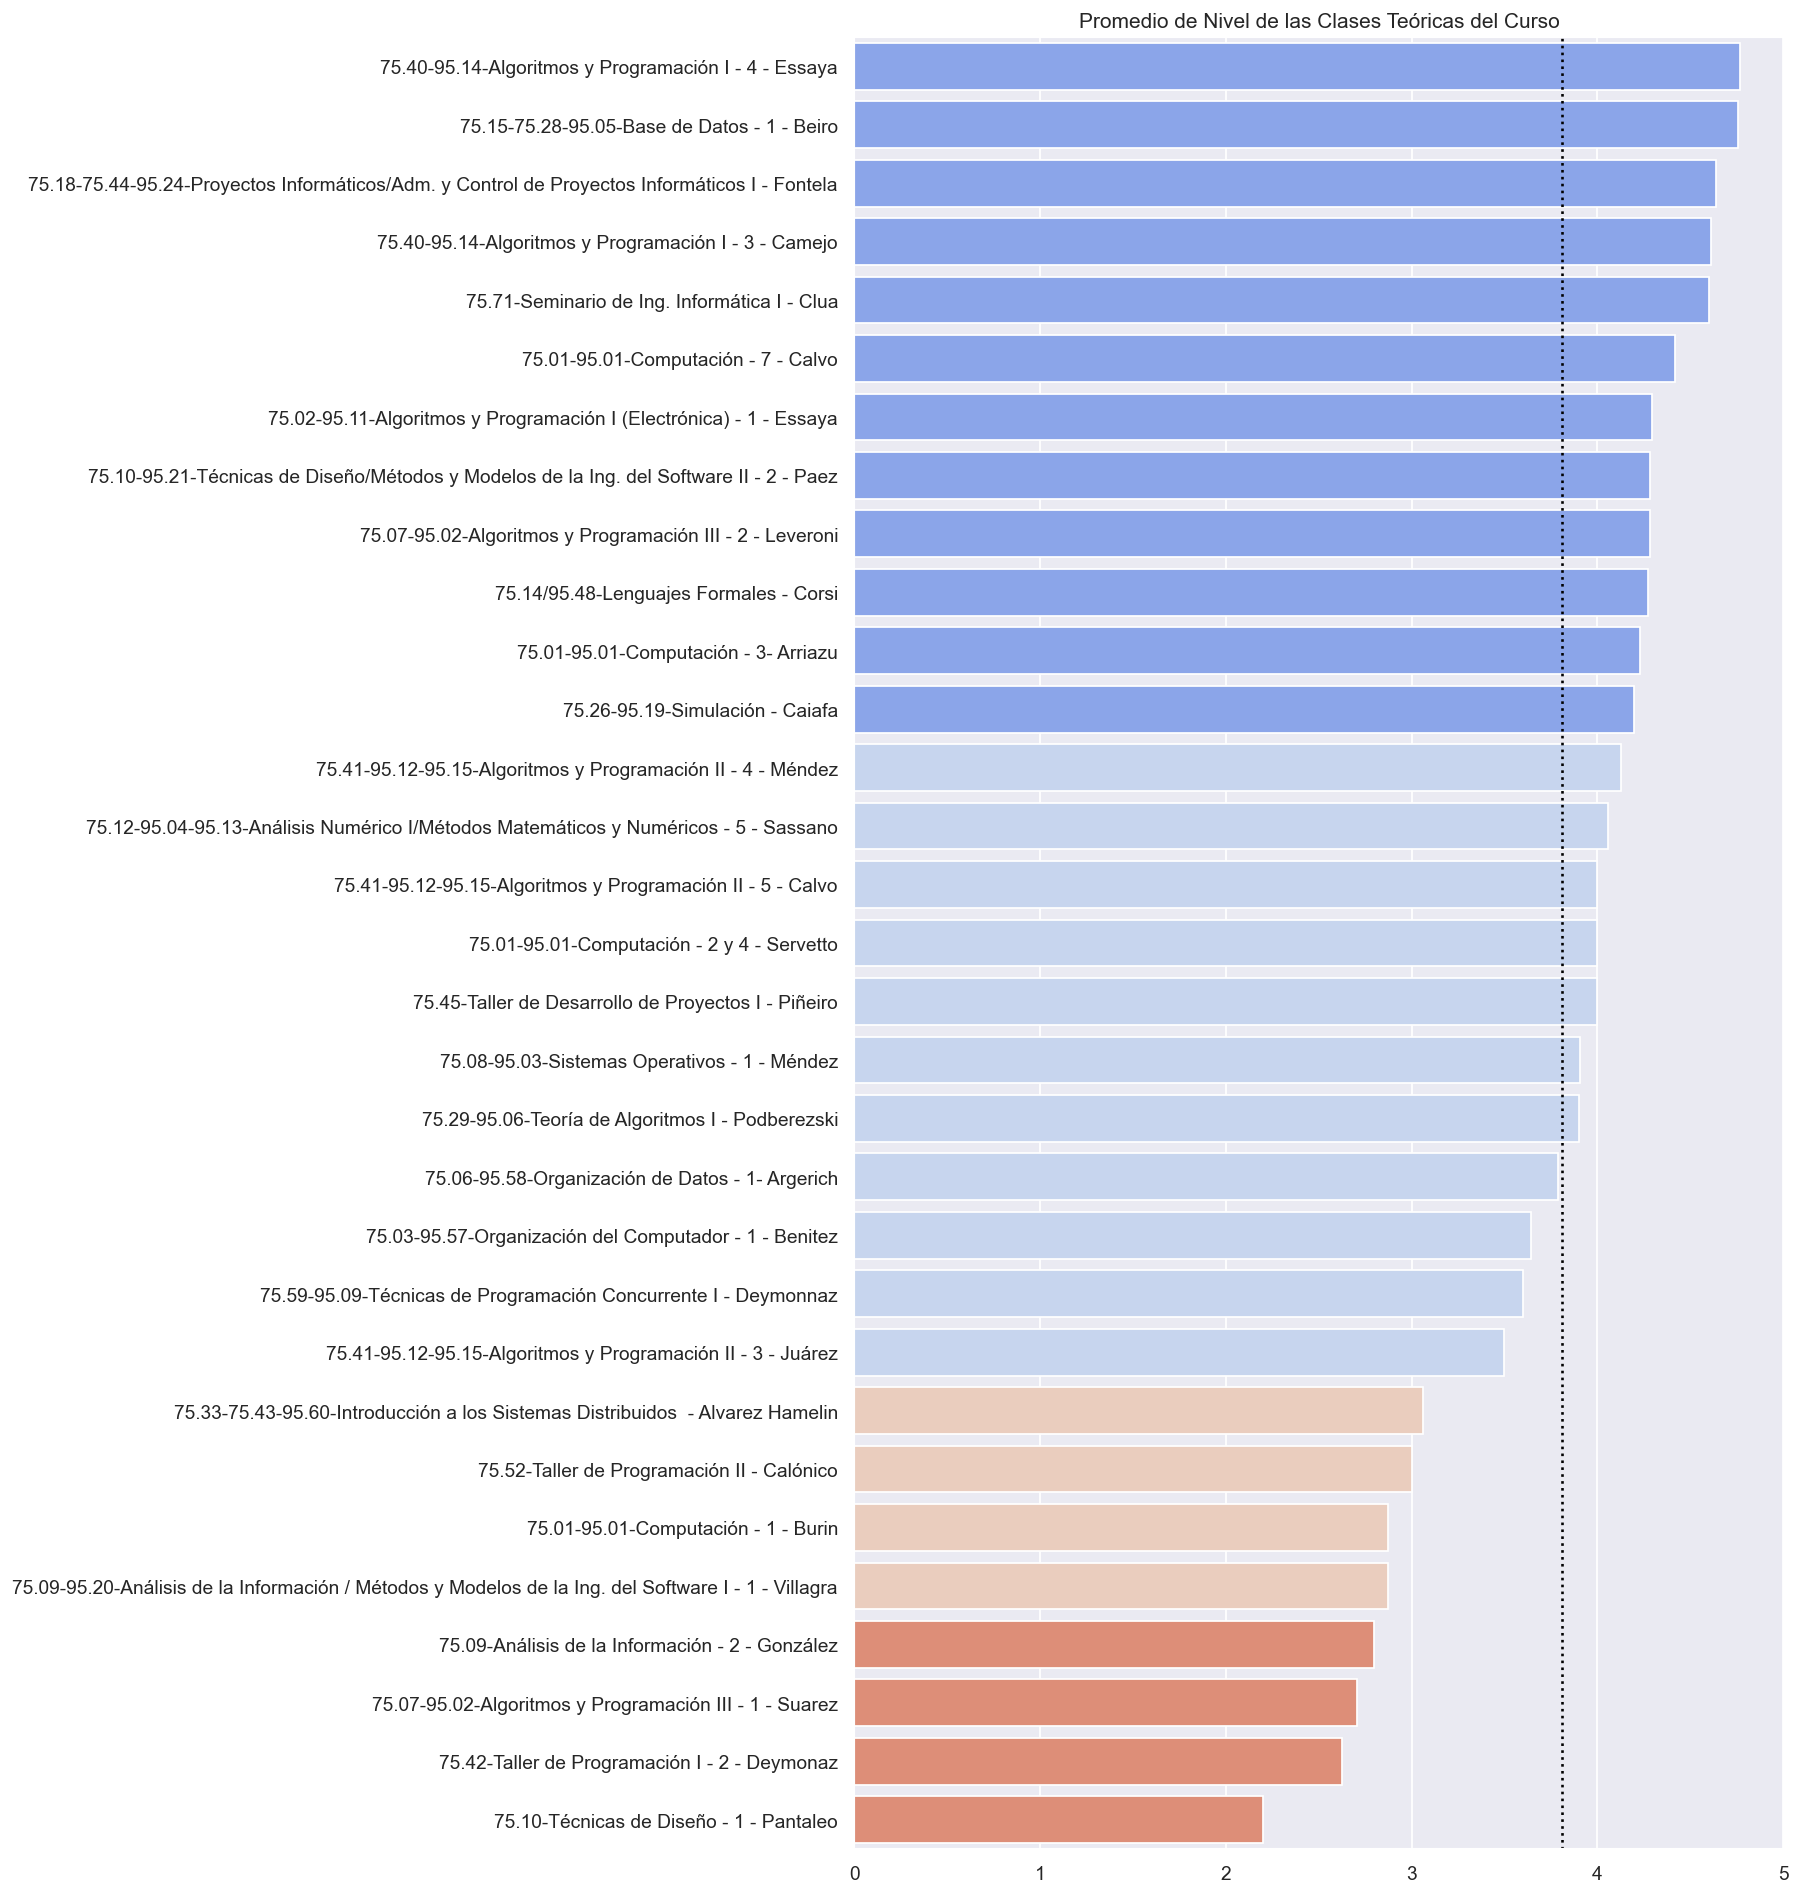

### Nivel de las Clases Prácticas del Curso

Se analizan los promedios por curso de Nivel de las Clases Prácticas del Curso. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

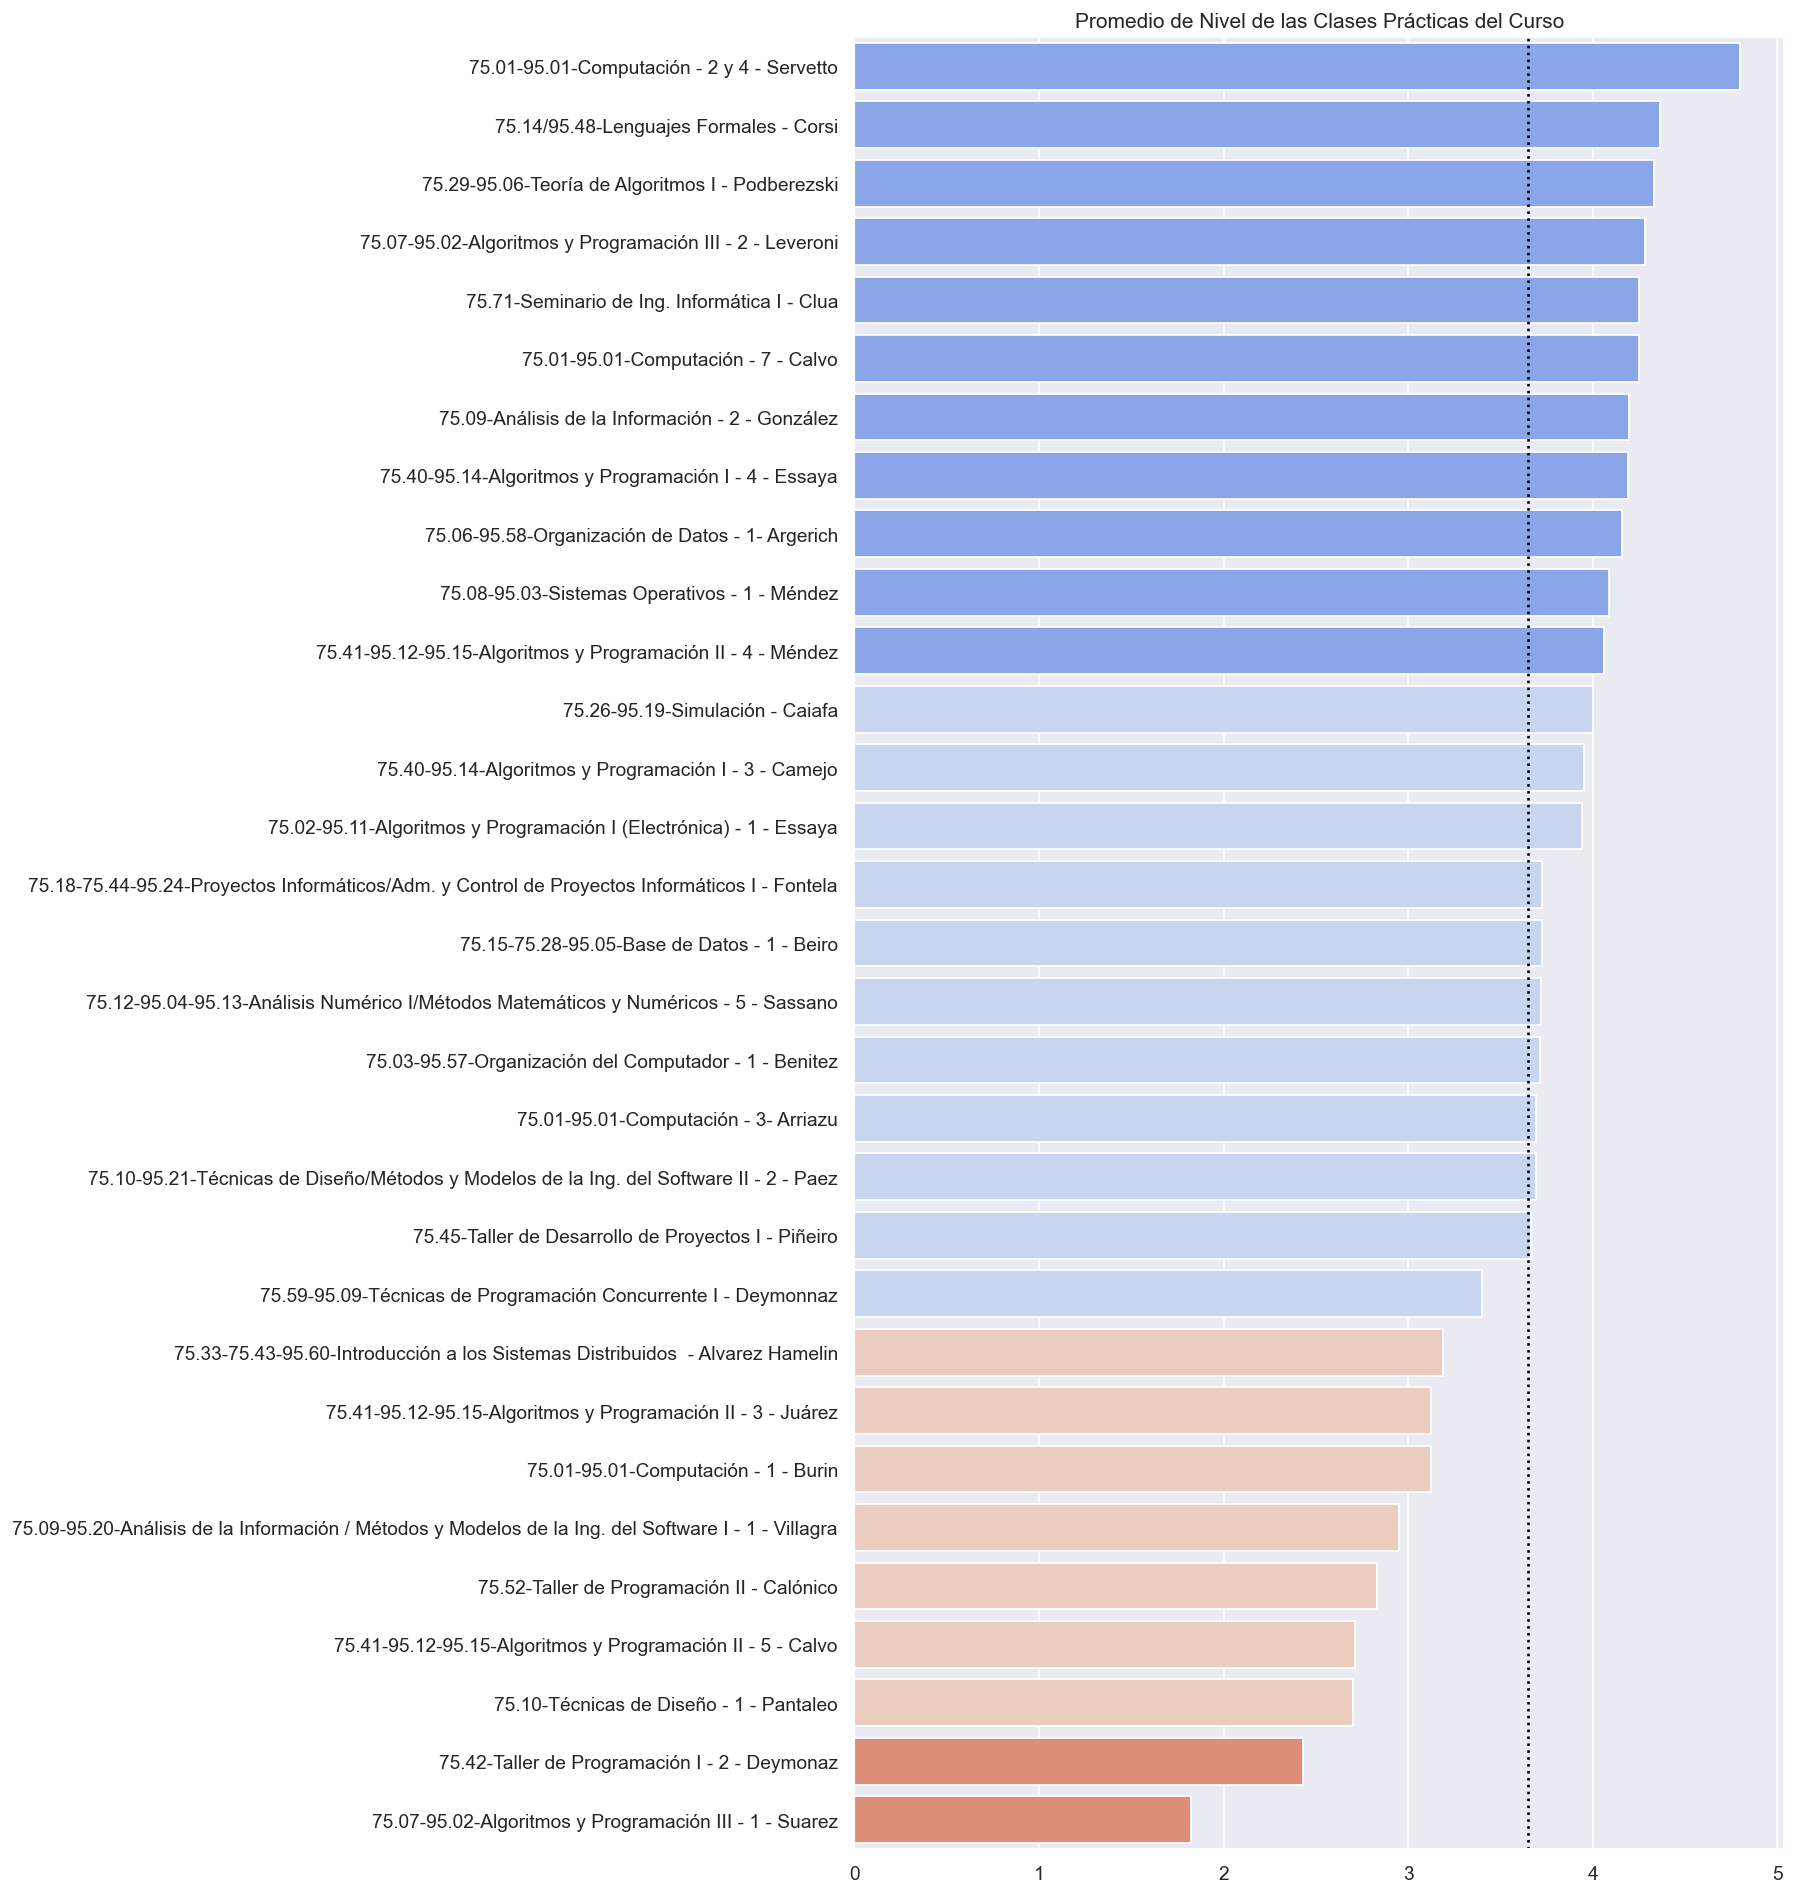

### Dificultad del Curso

Se analizan los promedios por curso de Dificultad del Curso. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

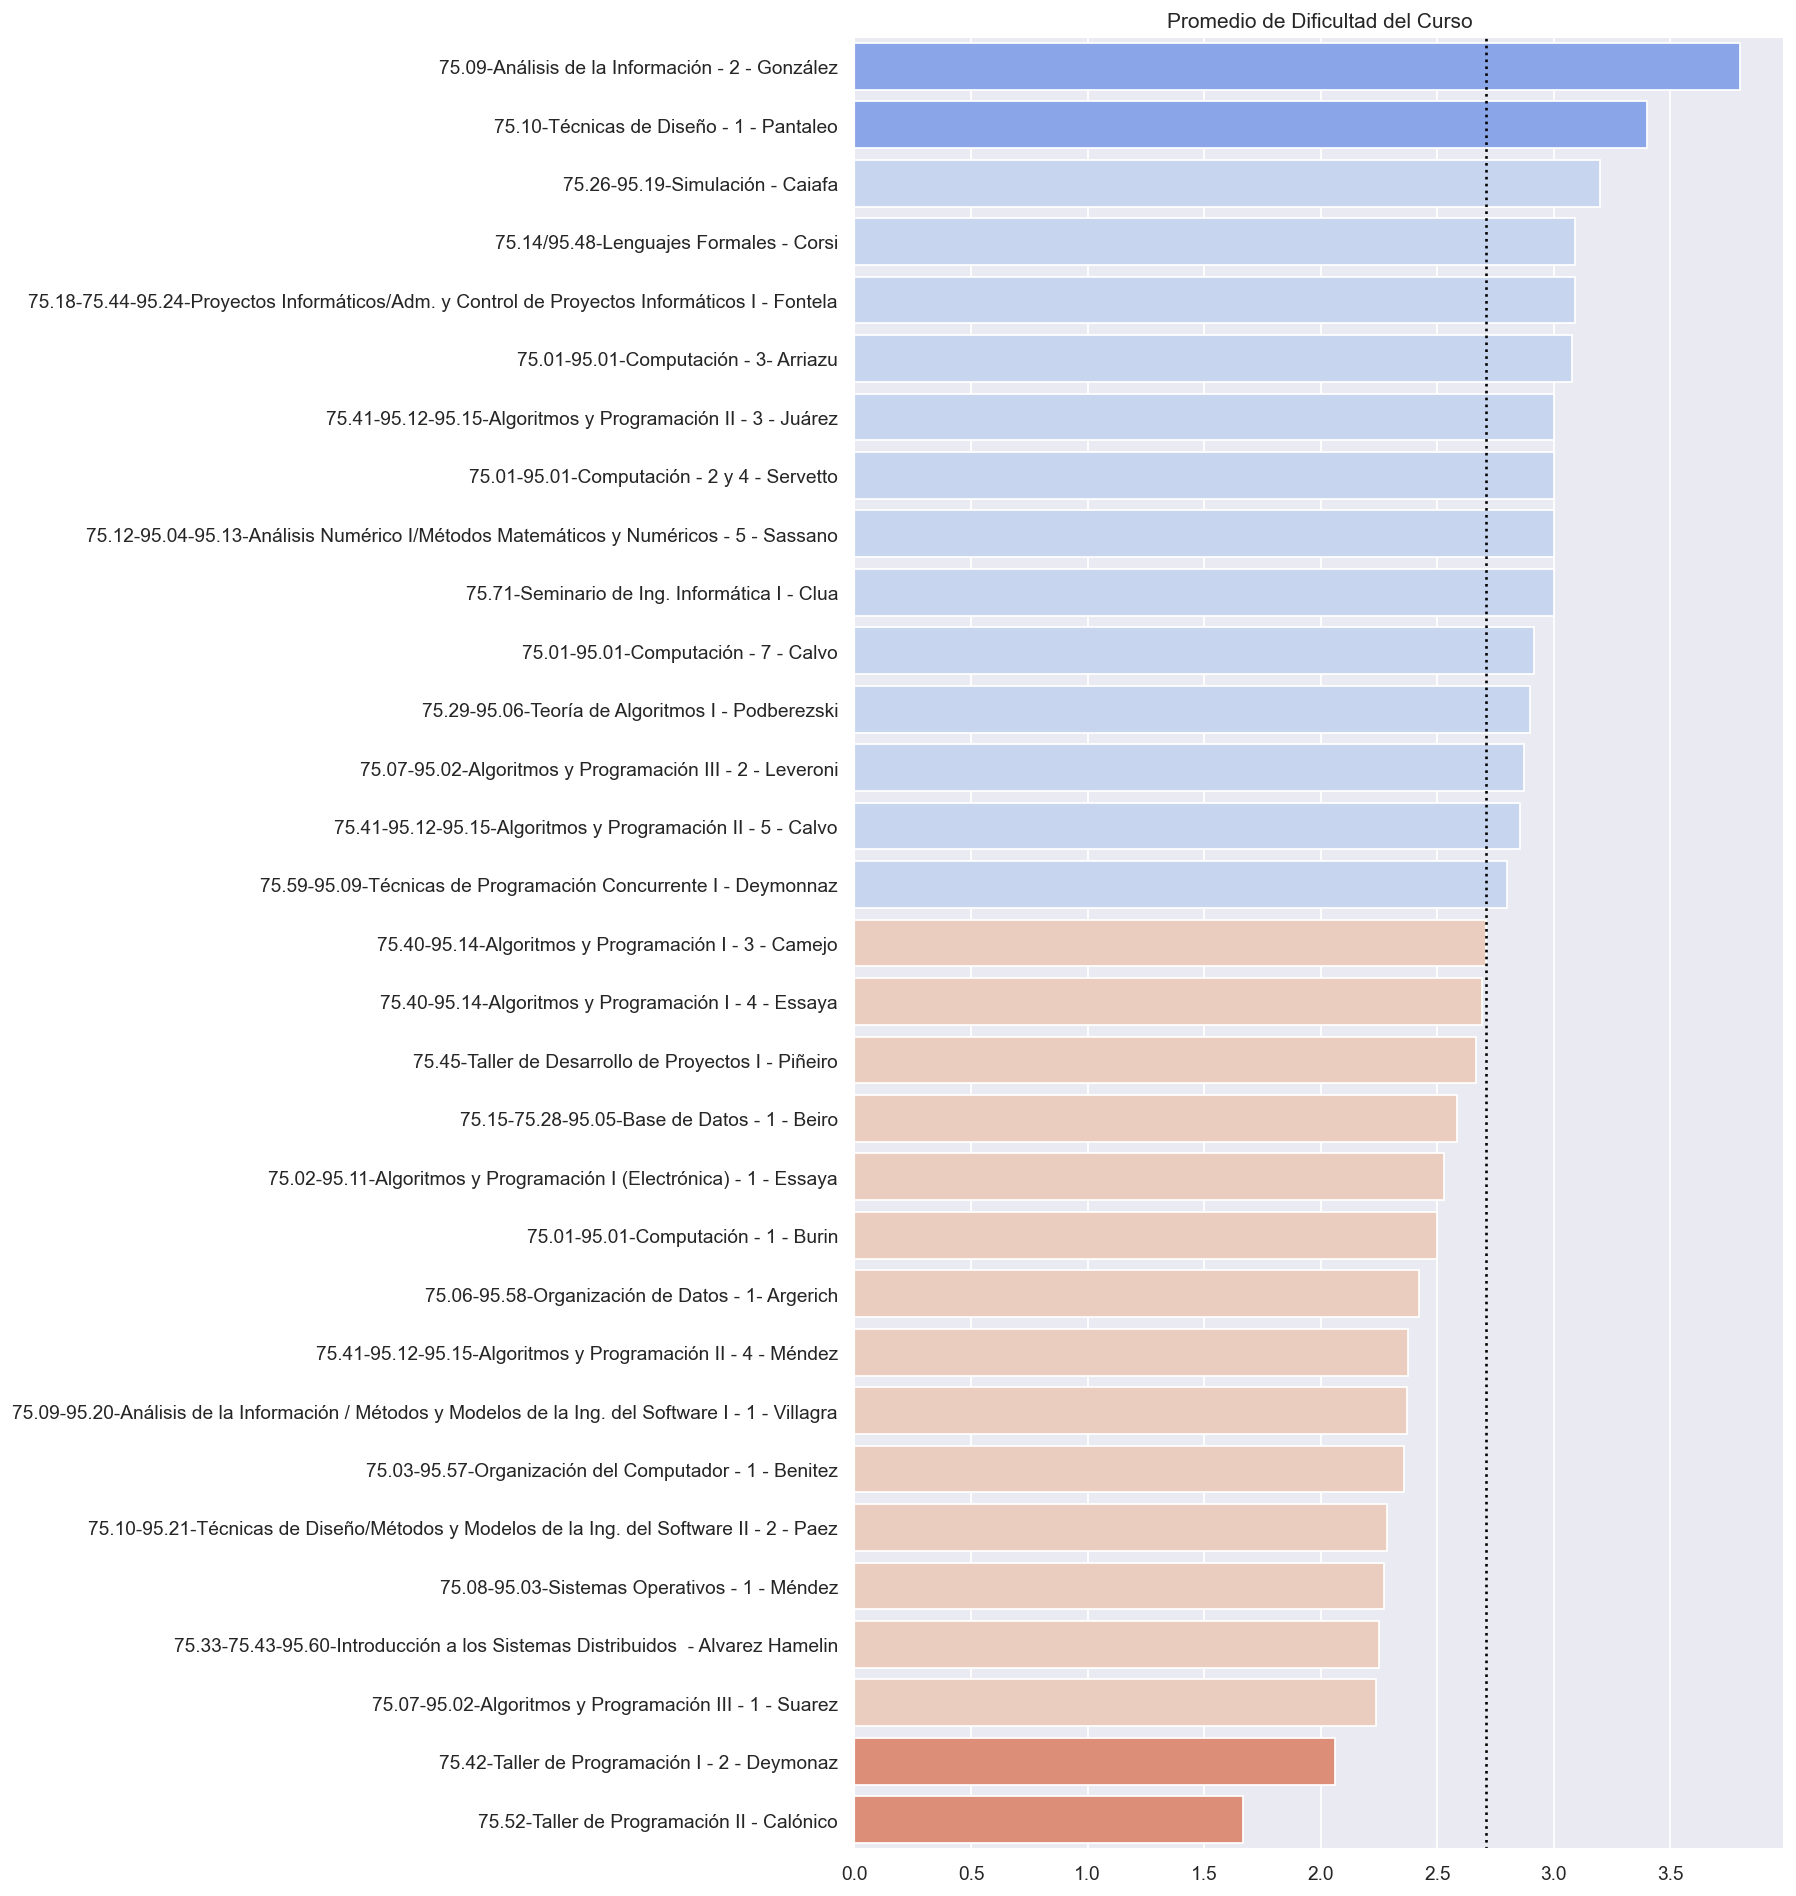

### Dificultad del TP

Se analizan los promedios por curso de Dificultad del TP. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

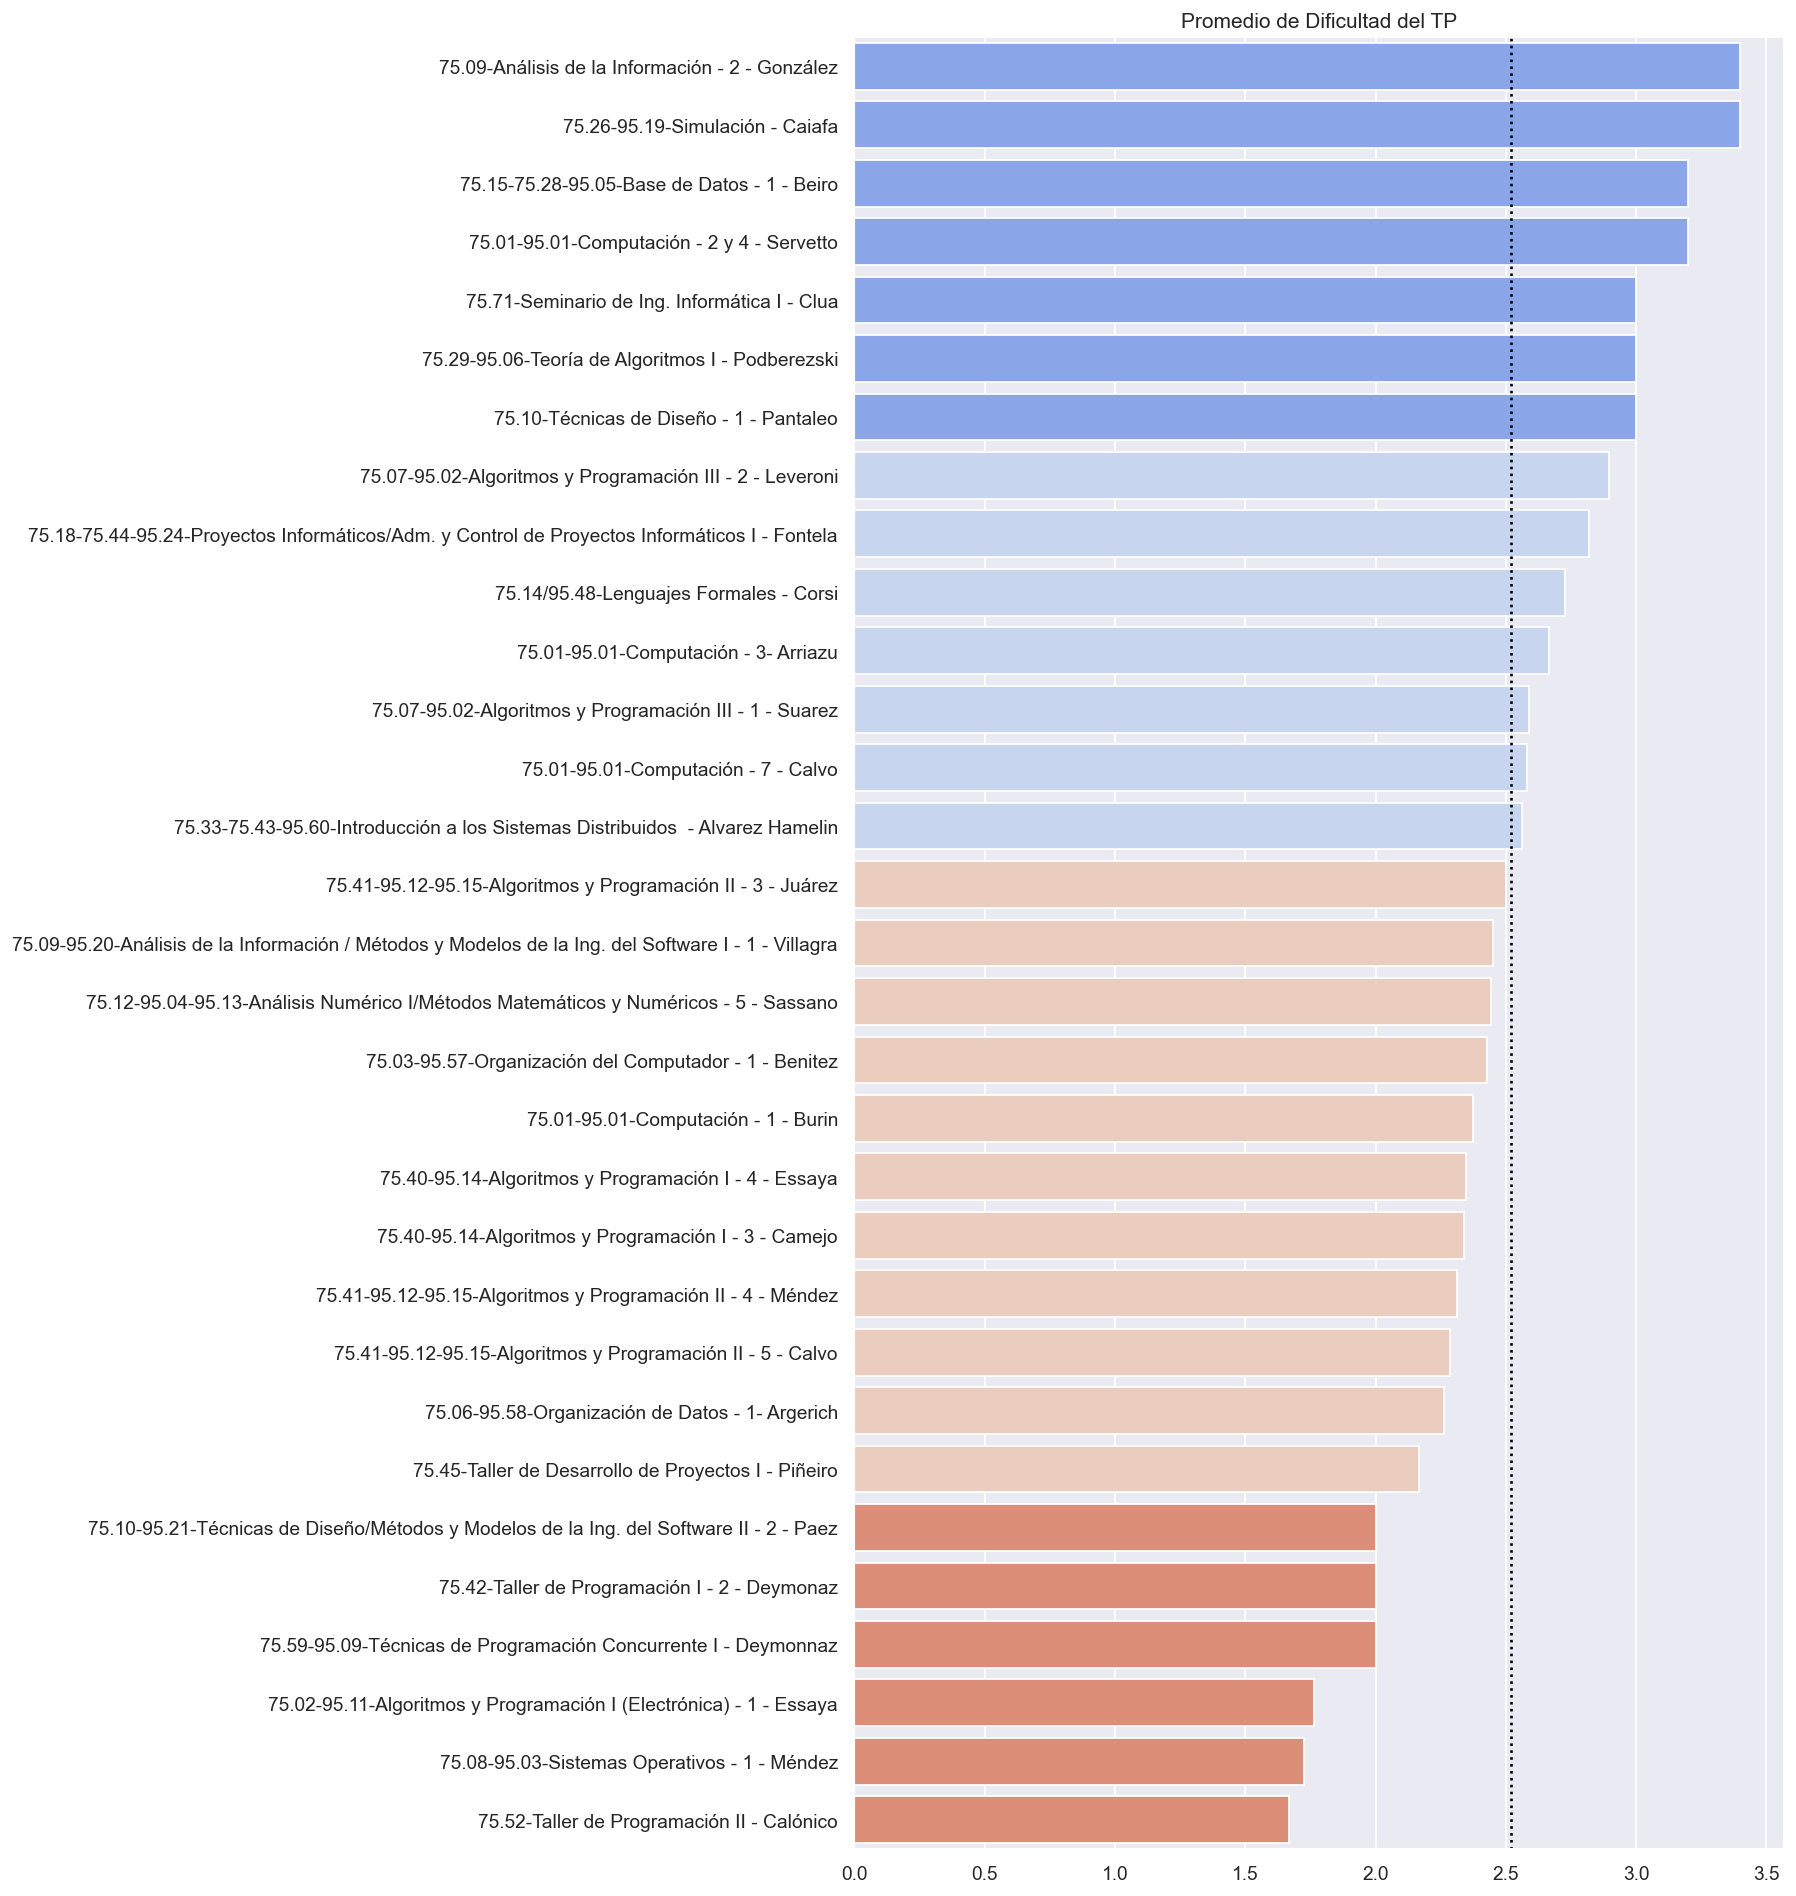

### Promedio nivel teóricas y prácticas

Se analizan los promedios por curso de Promedio nivel teóricas y prácticas. Se dividen en 4 contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores.

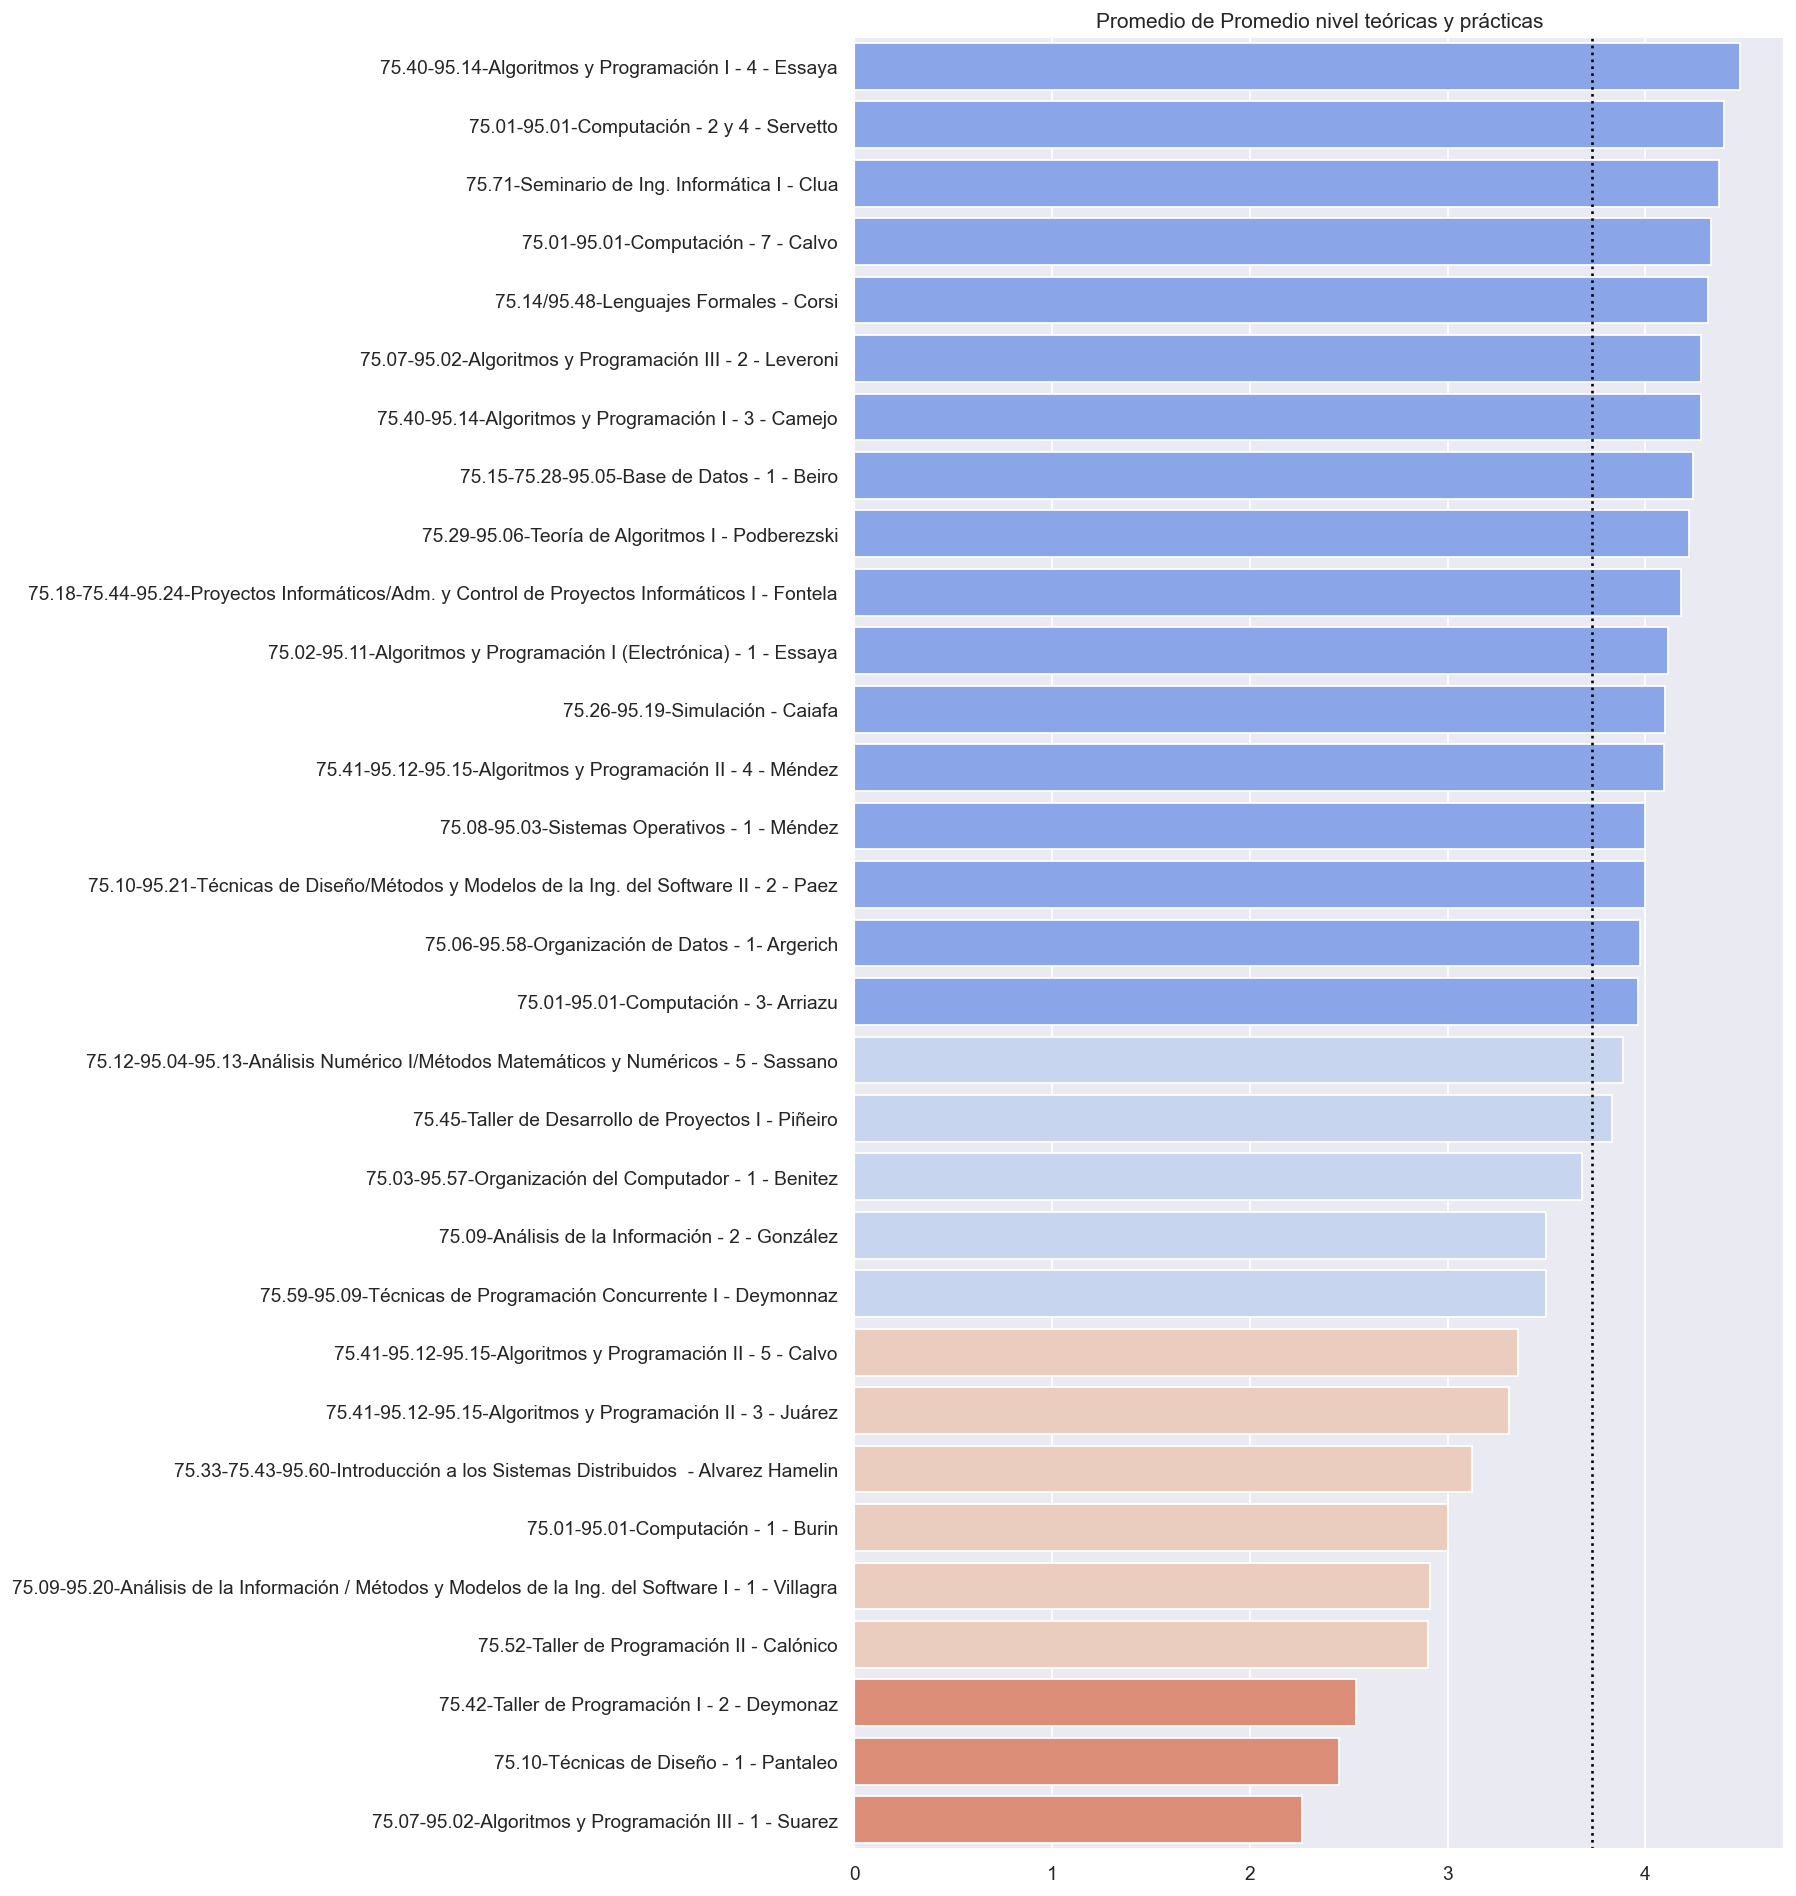

In [15]:
n_bins = 4

for col in num_cols:

    display(Markdown(f"### {col}"))
    display(
        Markdown(
            f"Se analizan los promedios por curso de {col}. Se dividen en {n_bins} contenedores entre los valores mínimo y máximo. La línea vertical en negro indica el promedio de los valores."
        )
    )

    values = comp_5p_mean[col].sort_values(ascending=False)

    c = pd.cut(
        values, bins=n_bins, labels=sns.color_palette("coolwarm_r", n_colors=n_bins),
    )

    plt.figure(dpi=125, figsize=(6.4 * 1.5, 4.8 * 4))
    ax = sns.barplot(x=values.values, y=values.index, palette=c.values)
    # ax = values.plot(kind='barh', color=c.values)

    ax.axvline(values.mean(), linestyle=":", color="black")

    plt.title(f"Promedio de {col}")
    plt.ylabel("")
    plt.show()

## Correlacion Entre Variables

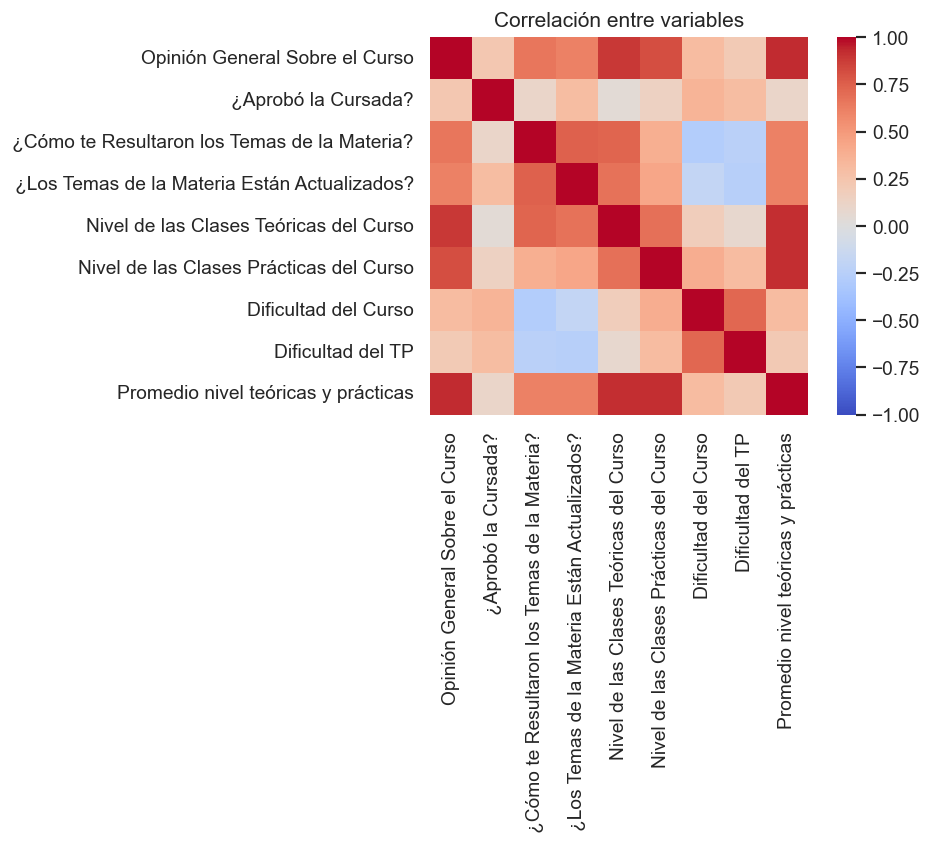

In [16]:
plt.figure(dpi=125)
sns.heatmap(
    comp_5p_mean[num_cols].corr(), square=True, vmin=-1, vmax=1, cmap="coolwarm"
)
plt.title("Correlación entre variables")
plt.show()

## Diferencia Entre Nivel de Clases Teóricas y Prácticas
- Hacia la derecha: Las clases teóricas son mejores que las prácticas.  
- En el centro: Poca o Ninguna diferencia.  
- Hacia la izquierda: Las clases prácticas son mejores que las teóricas.  

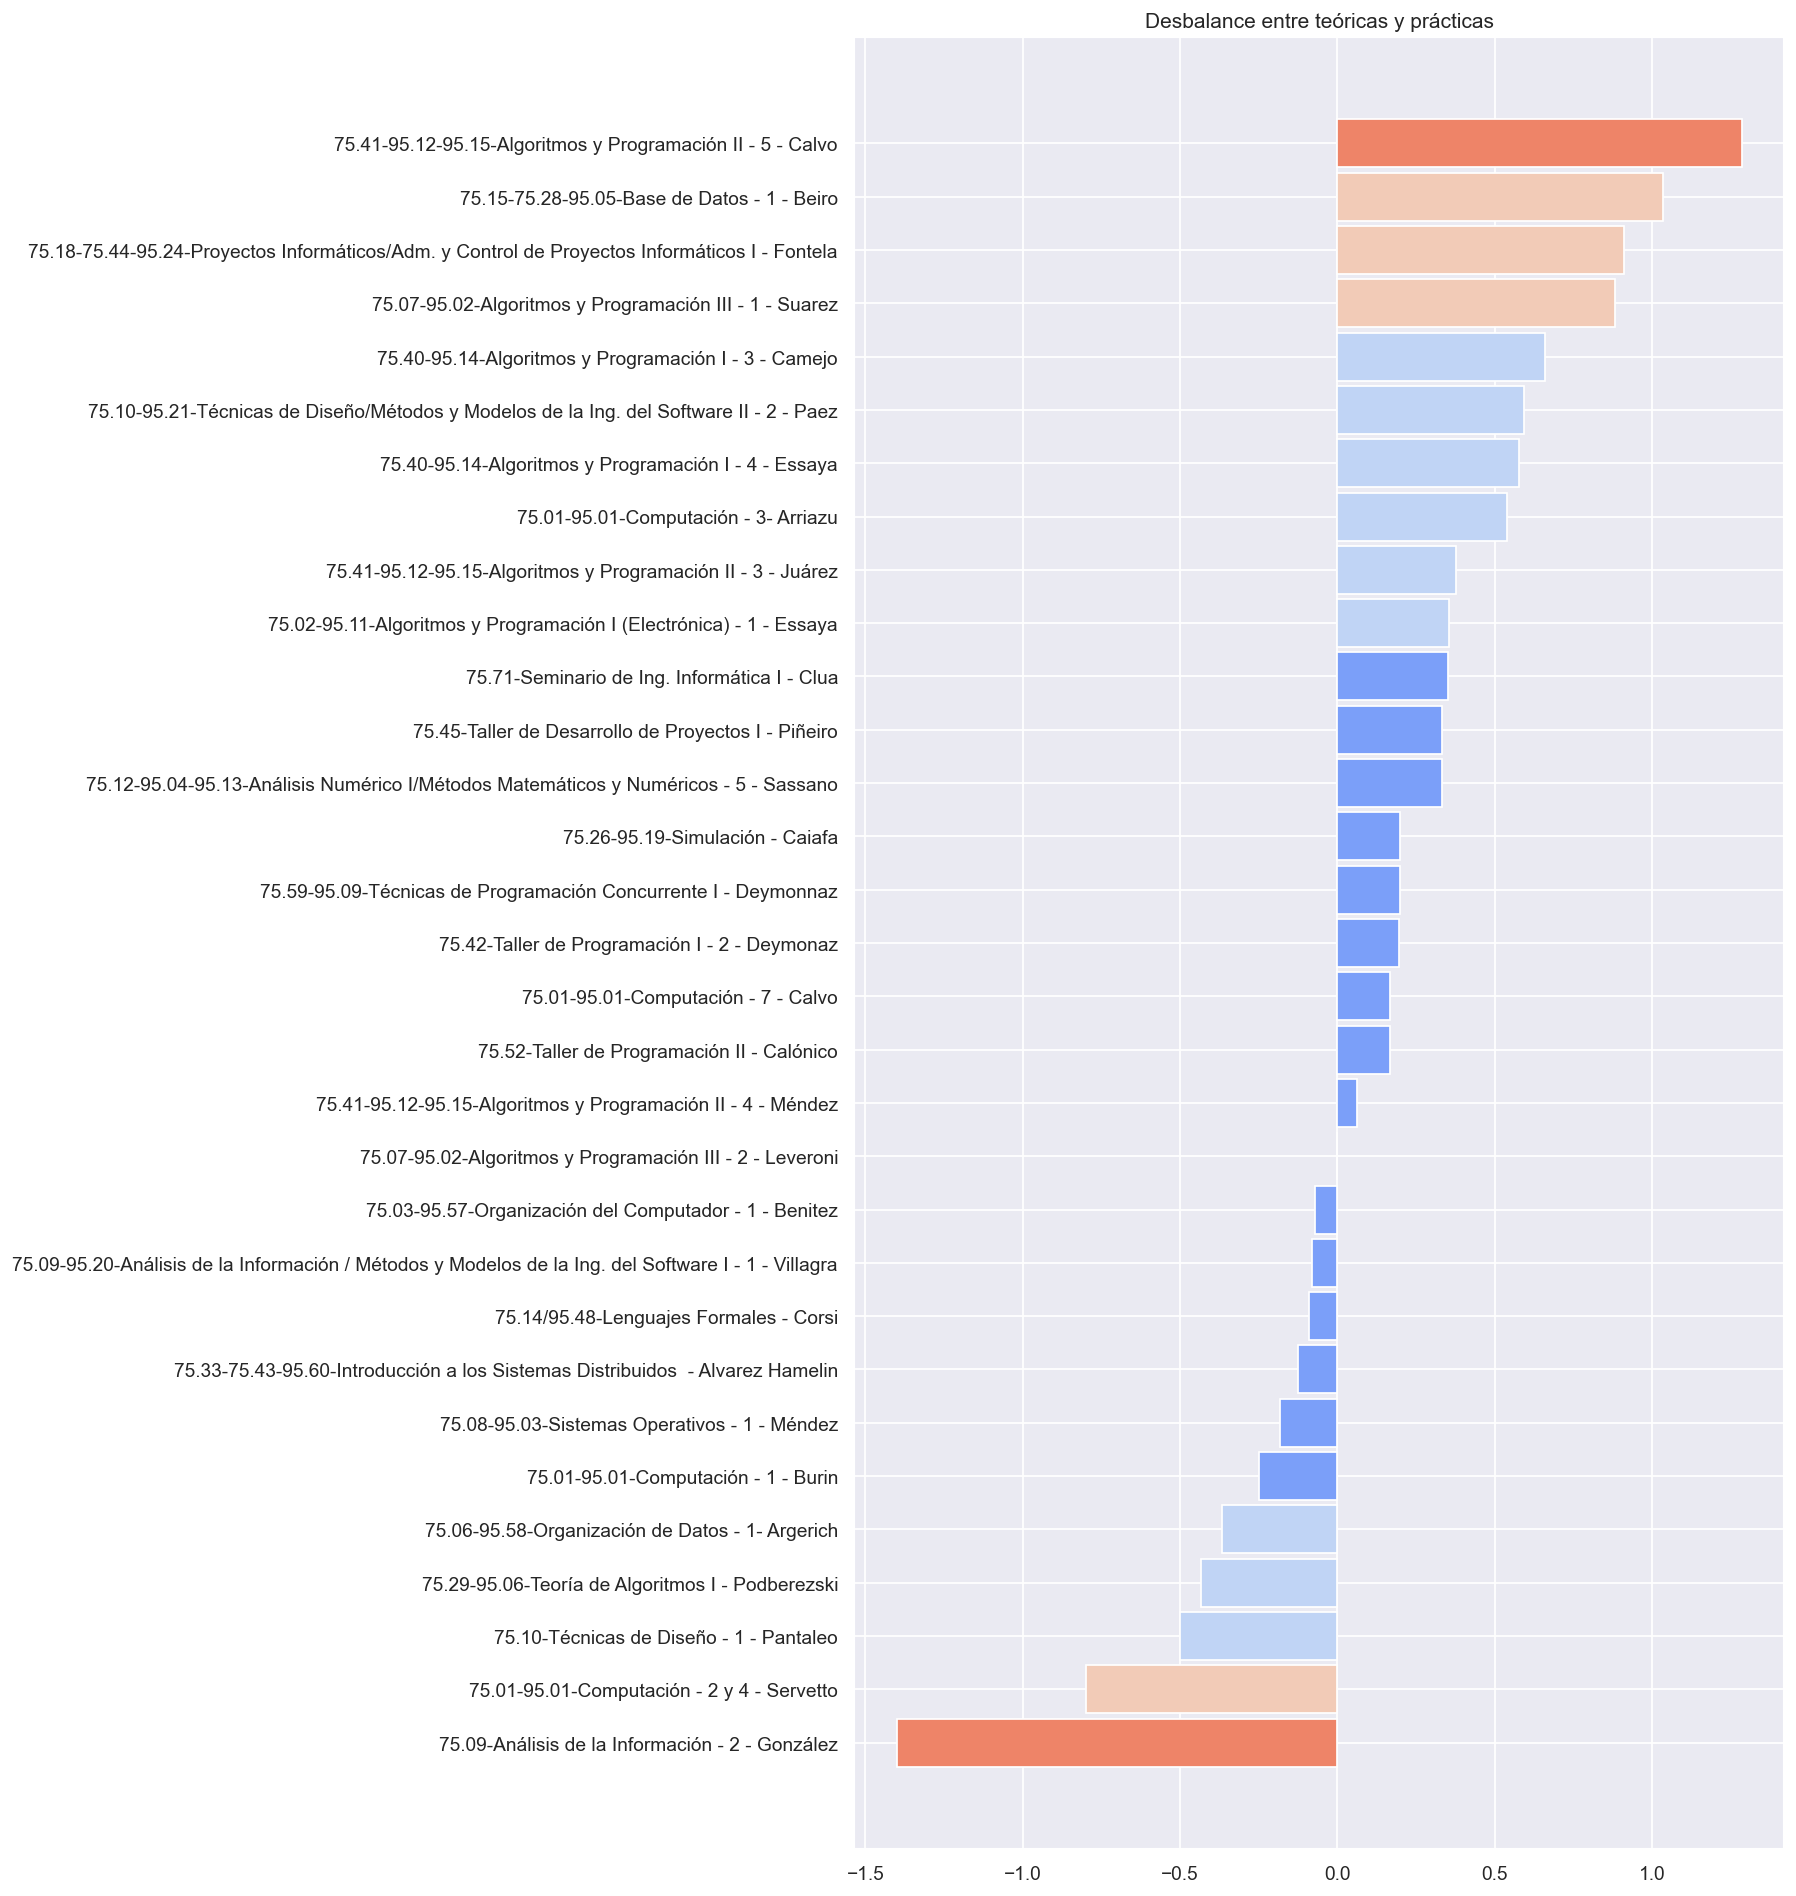

In [17]:
diff_teo_prac = (
    comp_5p_mean["Nivel de las Clases Teóricas del Curso"]
    - comp_5p_mean["Nivel de las Clases Prácticas del Curso"]
).sort_values()

plt.figure(dpi=125, figsize=(6.4 * 1.5, 4.8 * 4))

c = pd.cut(
    diff_teo_prac.abs(), bins=4, labels=sns.color_palette("coolwarm", n_colors=4),
)

plt.barh(diff_teo_prac.index, diff_teo_prac.values, color=c, height=0.9)

plt.title("Desbalance entre teóricas y prácticas")
plt.ylabel("")
plt.xlabel("")

plt.show()

## Emails

La pregunta del mail no fue incluida en esta ocasión. Pero al menos podemos ver la intención de la gente:

¿Permiten que se comparta al docente?

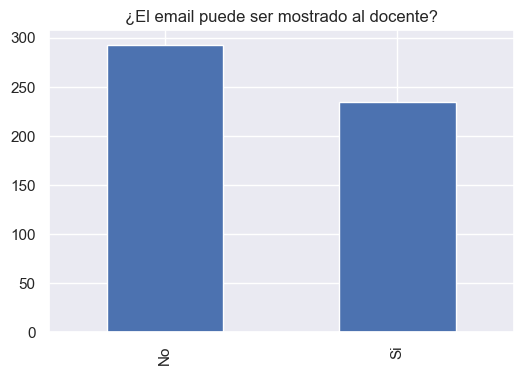

In [18]:
plt.figure(dpi=100)
comp["¿El email puede ser mostrado al docente?"].value_counts().plot(kind="bar")
plt.title("¿El email puede ser mostrado al docente?")
plt.show()

# Comentarios por Curso

In [19]:
def procesar_comentario(c):
    lineas = c.split("\n")
    return "\n".join([f"{l}" for l in lineas])


for curso in sorted(comp["Elige el curso"].unique()):
    display(Markdown(f"## Curso {curso}"))
    com = comp[comp["Elige el curso"] == curso][
        "¿Tenés algún otro comentario o sugerencia sobre el curso y la cursada virtual de este cuatrimestre?"
    ].dropna()
    if com.empty:
        display(Markdown("_No hay comentarios_"))
    else:
        todos_los_comentarios = com.str.capitalize().value_counts()
        for comentario, count in todos_los_comentarios.to_dict().items():
            if comentario == "":
                continue
            count_suffix = ""
            if count > 1:
                count_suffix = f"**({count} respuestas iguales)**"
            display(Markdown(f"- {procesar_comentario(comentario)} {count_suffix}\n\n"))

## Curso 75.01-95.01-Computación - 1 - Burin

- No **(2 respuestas iguales)**



- En las clases presenciales se entiende muchísimo más  



- Las clases muy poco organizadas y con falta de predisposición del profesor.
malas condiciones en el aula (cortes de luz) 



- Ninguno 



- Un comentario seria tener un cronograma flexible  teniendo en cuenta que pueda modificarse  para poder ver que   dias seran de clases virtules o presenciales y  que dias habra parciales   



## Curso 75.01-95.01-Computación - 2 y 4 - Servetto

- Estoy conforme con ambas partes tanto teórica como practica de manera virtual.
tal vez las practicas por la necesidad de utilizar computadoras esta bueno de manera virtual pero en el caso de la teórica y para apalear el tema de la poca interacción grupal sería bueno de manera presencial, además la interacción profesor alumno seria más. 



- Que prefiero presencial  



- El profesor servetto explica muy bien , se nota que tiene experiencia y muchos conocimientos. el único comentario que haría respecto a su forma de dar las clases es a la parte práctica de la materia, o sea, a la parte de "algoritmia y programación". me resultaban tediosos y aburridos los ejercicios de programación de las clases, tal vez sería más interactivo, llevadero y se entenderían mejor los temas si los programas a realizar sean de otra temática y no tanto sobre números (números primos, alícuotas , etc). hubiera estado bueno en las clases haber realizado varios ejercicios de diferentes temáticas simples.  



- - 



## Curso 75.01-95.01-Computación - 3- Arriazu

- Ninguno pero es muy buena catedra. arriazu sin duda es una de las mejores profesoras que tiene fiuba 



- No de momento. 



- Sentí que un 75% de la clase no servía para nada. toda la explicación teórica no suma mucho para mí. debería haber 15 min de teoría donde se de un pantallaso de lo q se va a ver y después pasar directo a python y que se explique como se usan las funciones. dos horas de clase por semama son más que suficiente. si las clases fueran más concisas y prácticas habría más alumnos conectados. 
el pocket python está muy bueno. muchas gracias por tenernos paciencia cuando hacemos consultas. 



- Me parece q lo mejor es hacer una cursada mixta para que no se pierda la interacción entre compañeros ni con los profesores. creo que la cursada totalmente virtual le genera dudas a los profesores de que ocurre atrás de la pantalla como cuando preguntan y nadie responde y muchas veces como alumno se debe a q uno espera q otro responda y no es por no estar siguiendo la clase.  



- Me gusto el mundo de la programación. voy a ver si más adelante puedo estudiar un poco más sobre esto 



## Curso 75.01-95.01-Computación - 7 - Calvo

- Dado el carácter de la materia, la modalidad mixta que llevamos me pareció muy buena. poder tener las clases teóricas virtuales y aprovechar las presenciales para consultar sobre la práctica. 



- Las clases se subian con mala calidad. es por eso que opte por ver las clases de otro cuatrimestre grabadas 



- Quería agregar un comentario sobre las opciones elegidas en el apartado 9, 10 y 12.
en el apartado 9 y 10, cuando digo normal, si bien me refiero a que no me resultó dificultosa la cursada, a mi criterio me pareció el nivel adecuado y necesario para alumnos que no estudian una carrera informática. es decir, tanto la cursada como los tps significaron un desafío constante sin resultar de manera innecesaria excesivamente dificultosos. sin embargo, esto fue posible gracias a que la teórica y la práctica de las clases aclaraban todo tipo de duda y, por ello, no resultaba difícil realizar los tps ya que debíamos aplicar lo visto y explicado en clase. 
ahora bien, en el apartado 12, hablo sobre que mis expectativas eran similares a las vividas en la realidad, y esto lo rescato como algo bueno. en este cuatrimestre, me anoté a 4 materias y solamente este curso cumplió con mis expectativas. esperaba tener clases de buena calidad que brindase actividades interesantes y así fue, no me puedo quejar de nada. 



## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 1 - Essaya

- Cualquiera q lea esta opinión, tiene q meterse si o si en esta cátedra.  es increible y la va a disfrutar mucho 



- El tipo de cursada semipresencial debería evaluarse para la todas las materias ya que tenes la ventajas de la virtualidad y también la posibilidad de ir a la universidad y interactuar con el profe, ayuda mucho a las personas como yo que viven muy lejos de la universidad además de que los profesores en virtualidad pueden preparar powerpoint y hacen que la cursada sea mas rápida y se entienda mejor 



- Cuando comienza el curso se dice que es acorde para aquellos que nunca han programado, pero para mí no fue así. nos costó demasiado a casi todos los que nunca habíamos programado. era difícil seguir la cantidad de contenidos dados. igualmente, siempre se evidenció las ganas de enseñar y se explicar a los profes. ellos hicieron muy bien su trabajo, pero son demasiados temas para poco tiempo. 



- Entiendo que fue cosa de este cuatri por los feriados, pero es muy poco tiempo para la entrega del tp, una semana antes sería mucho más cómodo, aparte de eso estuvo re bien la materia 



- Creo que ya dije todo lo que me parecía pertinente  



- Los ejercicios obligatorios son demasiados fáciles y muy diferentes al tp, el tp final es lo más complicado de la materia por lejos, debe ser más complicado que el final en si seguro. lo que hiciste en los ejercicios obligatorios debe ser el 5% del tp. y lo peor es que lleva demasiado tiempo justo en la fecha de finales, dudo que pueda rendir ningún final en la primer fecha por este trabajo práctico. 



- No sé cómo cambiarlo, pero el hecho de programar en papel (y sin el stack overflow :p ) complica mucho las cosas en las instancias de parcial 



- 1)si lo mas importante agradeceria mucho que den la opcion de no usar linux ya que no es necesario y se puede programar tranquilamente en windows todos los tp hasta el ultimo sin usar wsl ni nada, la herramienta seguramente ya la conocen y si no se las digo es visual estudios 2022 trae todas las herramientas que usamos en el curso como el debugger, y el tema de la memoria,ademas  se le puede agregar el tema del motor grafico que usamos lo cual lo vuelve una herramienta muy facil de usar unicamente tenes que configurar literalmente 3 rutas a las carpetas que vas a usar y queda listo para utilizar, esto lo digo mas que todo por que yo use wsl hasta el ultimo tp al instalar el motor grafico el cual me tiro mil errores, los solucione y empece el tp , pero masomenos al quinto dia dejo de andar de manera espontanea y decidi cambiarlo al visual que en windows no vas a tener ningun problema, hay muchos chicos que no cuentan con una buena pc y obtan por descargar una maquina virtual con linux , yo creo  que la opcion que propongo es muy buena alternativa
 2) lo mencionado anteriormente de que los parcialitos no sean los mismos
 3) el tema de las clases teoricas virtuales estaria bueno que fueran presenciales o que se pudira mezclar con un poco de practica ya que habia semanas donde la teorica y la practica ni siquiera daban los mismo temas lo cual hacia que algunas partes quedaran completamente olvidadas
4) y  por ultimo agradecer todo lo que hicieron son una catedra muy buena, nunca vi a tantas personas aprender a programar tan rapido desde cero yo pense que al final la clase iba a estar practicamente vacia y me sorprendio ver que no, y eso es gracias a ustedes en parte espero que les sirva mi recomendacion 



- Para mi se tendria que avisar anteriormente en el siu que dia y horario va a ser virtual y cual no, por que las clases de los lunes tenia que perderme si o si la teorica ya que terminaba de cursar presencial a las 17 y con el transporte a mi casa llegaba 18.30 perdiendome gran parte de la teorica y por ende la practica no podia seguirla ya que iba en base a lo que vieron en la teorica 



- Capaz podrian disminuir la cantidad de ejercicios de ejercicios que se entregan.  



- En gral. la materia en sí para gente que nunca programó es muy complicado, quizás seria sacar algún tema pero explicar el resto de forma más clara y con más tiempo 



## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 2 - Azcurra

- Mas recursos escritos, pdf o citar libros. dar la guía de ejercicios al principio de la cursada y no faltando una semana para rendir el parcial. menos mirar videitos y ejercicios en grupos en horario de la practica y mas trabajo o teoría, ejemplos de ejercicios.  



## Curso 75.03-95.57-Organización del Computador - 1 - Benitez

- Creo que las clases de assembler podrían hacerse un poco más dinámicas, mostrando código de una en vez de mostrar slides (ir codeando mientras se explican cosas, por ejemplo). los slides son bastante entendibles y sirven muchísimo para consulta cuando no te acordás algo, pero leer el pdf en clase sin mostrar nada de código no sé si es la mejor estrategia o la que yo elegiría. para cuando llegas a la parte de la clase donde se hace un ejercicio estás tratando de digerir todo y ya estás abrumadísimo. por lo demás, el curso excelente, todos los profesores explican bien y tienen buena voluntad para contestar dudas en clase, aunque estaría bien si respondieran un poco más en el campus también. 



- Si bien tienen un foro, no responden mucho por ahi. es un milagro que respondan alguna duda ahi. pero en clase, ya sea virtual o presencialmente, contestan todo. ojala sean asi en el foro, pero se entiende que este año hubo muchos alumnos y muchas cosas de por medio. pero en todo lo demas, buenas practicas, buenos tps, buenos profesores que te explican todo y las dudas las responden todas en clase, invitan a la participación y te muestran manera distintas de resolver.   



- Me pude acomodar muy positivamente a la modalidad virtual, considero que es una materia que tiene temas que estan muy buenos darlos de manera presencial. asi como otros un tanto mas "teoricos" de manera presencial. 



- Me resultó aburrida la materia en general. deberían hacer 100% virtual por los contenidos que se dan. con respecto al tp, al ser muchas consignas me pareció que no todas tenían la misma dificultad. 



- Creo que lo único que se puede señalar como negativo es el tiempo de respuesta a los mensajes del foro. a veces algunos mensajes de algunos compañeros no tuvieron respuesta alguna. 



- No puede ser que sea cátedra única y termine a las 11 de la noche. muchos días presenciales falté porque mi parada del colectivo queda atras de la facultad y no hay nada ni nadie. debería haber más cátedras, por lo menos unna un poco más temprano. se dedican a leer las presentaciones y falta material. no hay comunicación. muchos tenemos dudas similares y en el campus se pierden. deberían usar discord ya... hay comentarrios de esta misma cátedra de fiubawiki (mas de 10 años atrás) y dan exactamente lo mismo. no está actualizada. los temas para mí son interesantes pero como se dicta la materia no sirve. tienen que modificar seriamente algo. horario, comunicación, más cátedras y material. el depto debería estas atento a esta situación. es una matería del segundo año de la lic y se ve abandonada. hace dos años abrió otra cátedra por solicitud de los alumnos y ahora cerró otra vez. no hicieron nada. esta materia está abandonada. 



- Estoy conforme. 



## Curso 75.06-95.58-Organización de Datos - 1- Argerich

- No 



- Es una materia que se adapta de forma excelente a la cursada virtual, los profesores y ayudantes responden dudas de inmediato y los trabajos son muy llevaderos 



- En particular me hubiera gustado que las clases tengan un poco mas de teoria y explicacion de conceptos, y que no fueran solamente practicas y ejercitacion porque se me complica ver videos teoricos previos a la clase. 



- Gian es excelente explicando y la razón principal por la que la cátedra es excelente 



- El tener que tener que ver los vídeos teóricos antes de clases no me no me gustó, por un tema de tiempo. 



- Por favor, muchos videos tienen el volumen muy bajo y son muy dificiles de ver, ademas capaz que los profes hablan con 0 onda y son 1 hora 45 minutos de video que es muy dificil mantener la atencion. 



- Sinceramente, con los problemas que hubo al inicio del cuatrimestre, tenía bajas expectativas con respecto a esta cátedra pero me sorprendieron para bien. las clases y los trabajos estuvieron muy bien llevados. 



- Un poco mas de material para preparar el final estaria bueno 



- La cursada fue en mi opinión muy completa y la buena disposición de los profesores a la hora de responder consultas o de dar las clases sincrónicas ayudó bastante a que pudiera comprender los contenidos de la materia. 



- Sigan con la modalidad mayormente virtual y con la misma forma de evaluación, siento que aprendí mucho con esta modalidad 



- Quiero destacar el esfuerzo de los decentes en mejorar la materia, el hecho de que varios ayudantes sean alumnos permitió una comunicación mucho más fluidas para realizar consultas, este cuatrimestre se seleccionaron mucho mejor los contenidos. esto lo digo porque anteriormente esta materia tenía tantos temas que se hacían imposibles abordarlos a todos en profundidad y se quedaban a medias, pero en los exámenes te evaluaban como si furas un experto. actualmente por suerte no es así y se enfocaron en los temas más importantes y se tomaron trabajos prácticos difíciles pero que posibilitaron aprender mucho. las consultas realizadas por la herramienta slack eran respondidas muy rápidamente y las clases prácticas eran muy buenas. el examen final estuvo acorde a lo enseñado en la materia. saludos 



- Lo bueno de que nos dejaban ver las teóricas por nuestra cuenta es que la hora/hora y media de videos era restado del tiempo total de la clase per se y no eran horas extra agregadas a la cursada. lo malo de eso que la práctica se adelantaba al principio de la clase obligándote a tener que ver los videos antes de la misma cuando no todas las personas disponemos de tal tiempo, y menos entre semana (caso de la clase de los jueves, porque para la de los lunes "teníamos el finde"). sin mencionar que los videos son profes leyendo ppts, lo que las hacía muy tediosas en general cuando quien hablaba en el video leía algo que no había hecho. creo que fue el único aspecto negativo de la cursada pero fue suficiente para no engancharme con la misma por lo que mi cursada se redujo a solo ver los videos prácticos (o parte de ellos) para poder realizar los tps.

por otro lado, no fue mi caso pero la no aprobación de un tp (en caso de no superar cierto puntaje) te dejaba fuera de la materia. no se qué tan bien esté eso pues la opción de recuperar estaba disponible solo según ciertas condiciones que establecidas por la cátedra y no para todos los casos. 



- No, me pareció muy buena materia. 



## Curso 75.06-95.58-Organización de Datos - 2 - Rodríguez

- Para ser el primer cuatrimestre de la cátedra estuvo bastante bien, deberían revisar el tema de los trabajos prácticos en grupo 



## Curso 75.07-95.02-Algoritmos y Programación III - 1 - Suarez

- Dediquense a otra cosa 



- Apbran mas.cupos con leveroni 



- Deplorable las consignas de los tp, las explicaciones y las correcciones. queda poco claro el que hacer y corrigen segun su agrado al alumno. 



- El tema de interfaces gráficas se vio muy por encima y demasiado rápido, obligándonos a buscar casi toda la información por otros medios, sin saber si estaba bien aplicado o no 



- Se sintio una mala animosidad en cuanto a la organizacion de la catedra en general. se hace mucho incapie en estandarizar los tps pero los criterios de correccion son super subjetivos y muchas veces contradictorios entre correctores.

destaco el trabajo de los profesores que contestaban muchas dudas en el canal de slack. 



- Agreguen más ayudantes a esta cátedra o denle más bola administrativamente. no ayuda a la cursada tanto virtual como presencial 



- Le daria una mayor importancia a la teoria respecto del modelado de diseños uml y resolucion de problemas con estos diagramas, ya que se toco muy por encima y las clases mejor llevadas fueron una semana previa al parcial 



- Es difícil que las clases híbridas sean claras tanto para la gente presencial como para los que están de forma virtual 



- . 



- La cursada virtual es genial y personalmente le encuentro muy pocos o siquiera algún problema en comparación a la cursada presencial para esta materia y otras similares.
en cuanto a este curso de algorimos 3 de suarez en sí, la experiencia fue sinceramente pésima. además de que la manera de enseñar y corregir de algunos profesores o ayudantes no sean muy buenas en mi opinion, se notaba que eramos muchos alumnos en el curso para la cantidad de profesores y ayudantes asignados.
lo que es más, en base a lo poco que escuché de algunos compañeros que cursaron en el otro curso de algo3, la experiencia allí parece ser muy distinta (y mejor). 



- Los finales fueron multiple choice y había que estudiar de memoria, lo tomaron así porque en otros cuatrimestres se demoraban en entregar las notas y se sacaron el peso de encima 



- Tienen mucha desorganización  



- Porfavor, lo imploro desde el fondo del corazón pongan más cátedras que solo leveroni y suárez, es la buena o la mala 



- No 



## Curso 75.07-95.02-Algoritmos y Programación III - 2 - Leveroni

- No **(3 respuestas iguales)**



- Como comentario para mejorar, las clases en las que se iniciaba un tp, hubiesen estado mejor de forma virtual, para no depender (los que no teníamos computadora), de que nuestro compañero llevara o que las maquinas que hay en la facultad funcionen (que no siempre es el caso).
salvo por eso, me pareció una excelente cátedra, tanto a nivel de contenido como de profesores en explicación, ayuda en los tp y tiempos de corrección; además me gusto mucho la charla con hernan. de las mejores cursadas que tuve desde que ingrese en la fiuba. 



- No, pienso que estuvo bueno el hibrido. ir un dia presencial y otro virtual 



- No, la verdad fue una muy buena cursada :) 



- Muy bueno el discord con los ayudantes respondiendo 



- Pienso que las primeras clases eran una sobrecarga de informacion de temas muy dispersos, mucha informacion sobre cosas abstractas como inspeccionar la ventana de inspeccion del debugguer de un error, tambien informacion de contexto historico de smalltalk y tambien informacion sobre en si programar en smalltalk. personalmente no terminaba de entender cual era la informacion importante 



- Me hubiese gustado ver más de java para poder ver la diferencia con smalltalk en la teoría y en la práctica 



- Creo adecuado seguir con el formato semipresencial, sobretodo para algunas clases teóricas para las cuales se trabaja y estudia sobre la computadora (sea porque se ven detalles del lenguaje, presentaciones con diapositivas, etc). 



- Este curso tuvo muchas clases presenciales y me pareció que estaban mejor que las virtuales porque prestabas más atención, pero al mismo tiempo no tener la grabación de cómo se hicieron los ejercicios se extrañaba.  



- No prefiero virtual. 
me gusta más presencial. creo que prefiero 100% presencial, pero que además se graben las clases 



- Creo que podrian hacer menos tps pero mas grandes, que no sean tan centrados en el ultimo tema que vimos, para poder asentar mejor lo visto. y de esa forma poder ser mas exigentes al evaluar contenidos. de todas formas muy conforme con la cursada 



- La corrección de los parciales y trabajos es muy subjetiva. tu entrega puede ser un 2, 5 o 9 dependiendo el corrector. 



- Las clases presenciales no se grabaron, lo cual es una lástima. estaría bueno contar aunque sea con clases de cuatris anteriores para ver grabadas 



- Me gustó que la cursada sea mixta. personalmente prefiero presencial, pero entiendo que varios prefieren virtual así que un balance está bien. 



- En lo personal sentí cierta escasez de material teorico al que referirse por fuera de la clase o grabaciones. pero fuera de eso, excelente 



- Me encantó el curso, estaría mejor si las clases donde desarrolla un modelo son presenciales, estando desde casa cuesta mucho seguirle 



- Excelente cátedra donde se nota que de verdad quieren que aprendas y el día de mañana seas un buen profesional 



- Hicieron muy llevadera la materia, de los mejores cursos en lo que llevo en la facultad 



## Curso 75.08-95.03-Sistemas Operativos - 1 - Méndez

- Vean de corregir mas rapido los tps o simplificarlos un poco. 



- Muy buenos profesores, las respuestas a las consultas de los alumnos son buenas y los temas del parcial se explican claramente por parte de mariano mendez 



- Me gustaría que las clases teóricas también sean virtuales. 



- Un canal de discord unicamente para poner links de slides y clases grabadas por tema, no en el calendar. es mas fácil de encontrar.
buenísimo q la práctica sea grabada porque es dificil y al verla la 2da vez se entiende casi todo.
gran nivel educativo juan fresia.
buen tipo patricio.
mendez se desempeña mejor presencial que virtual y esta bueno ir de vez en cuando al la facu para hacerse amigos.
el parcial muy ambiguo mariano! los contenidos bien testeados igual.
demasiados tps y poca cantidad de correctores.
los temas que se dan son muy utiles para la carrera de ingeniería informática, pero algunos tps de jos van demasiado en detalle y creo que aportaría mas otros tipos de ejercicios la verdad.
 



- Buenas clases presenciales de mariano. se manejaron bien en la virtualidad 



- La disposicion actual de clases teoricas presenciales y clases practicas virtuales se maneja excelentemente y es ideal para los alumnos. sigan con esa idea 



- El único problema que veo es el tiempo que tienen en las correccciones aunque es entendible al ser tan pocos para corregir esa cantidad de trabajos que llevan tiempo de corregir 



- Sigan así, se agradece que sea virtual 



- No 



## Curso 75.09-95.20-Análisis de la Información / Métodos y Modelos de la Ing. del Software I - 1 - Villagra

- No **(6 respuestas iguales)**



- - **(2 respuestas iguales)**



- Hay cosas para mejorar. quizas focalizar mas en metodos de desarrollo un poco mas modernos de entrada. 



- Deberían enseñar en clase las herramientas necesarias para realizar el tp grupal, y no tener que aprenderlas por mi cuenta. si fuera lo único que debiéramos hacer,ok, pero no es el caso, aparte  hay entregas individuales que tambien llevan tiempo.si no contas con experiencia previa en desarrollo web, es casi imposible que puedas realizar completamente el tp grupal. 



- Creo que la cursada virtual fue benificiosa 



- No. 



- Creo firmemente que se tiene que replantear la materia, es un monstruo que quiere abarcar tantos temas que termina siendo agobiante. se le dedico mas del tiempo de sugerencia a resolver ejercicios o el tp y aun asi no alcanzo para dar la sensacion de "estar estudiando" o "estar al dia".
en cuanto a las actividades semanales realmente no entendi las fechas de entrega. te tomaban ciertas cosas que recien podias llegar a tener una nocion de por donde iba la mano a la semana de haberlo entregado (las clases iban atrasadas a las entregas semanales o se hizo adrede por algun motivo?). 
el trabajo practico grupal me parecio sumamente de mas, no me quiero extender mucho pero realmente no me senti comodo con el tp, se deberia reveer una forma de evaluar sacando la programacion (no considero que sea el fin de la materia).
me parece una muy buena practica (se hizo en materias que ya curse y me ayudo mucho) el dedicar los primeros 10 minutos a repasar los temas que se vieron la clase anterior para aclimatarse. no estoy diciendo volver a darlos, solo un pequeño resumen por arriba.
realmente espero haber sido respetuoso con mi opinion. no considero ser un hater, un caso aislado o alguien que no se alinea a los metodos de dar la clase. creo que hay algo mal, pudiendo estar equivocado o no y me gustaria realmente que a lo sumo se pueda tener en cuenta estos comentarios. 



- Definitivamente la peor materia que cursé hasta ahora. las clases se vuelven redundantes a la hora de repasar la teoría, porque el material ya está grabado y hay que verlo antes de cada clase. los talleres fueron la mayoría una pérdida de tiempo, y aún más los que fueron presenciales. las actividades individuales y el trabajo práctico grupal consumen demasiado tiempo, principalmente este último. sobre el tp grupal, me pareció muy mal llevada a cabo la idea de tener primero una etapa de descubrimiento a través de reuniones y dejar toda la implementación del producto para las últimas semanas, porque igual estuvimos a las corridas teminando el mvp (incluso con integrantes del grupo que tenían experiencia en desarrollo web). respecto a las actividades individuales, como ya describí en la pregunta anterior, las correcciones y los puntajes parecían totalmente arbitrarios, o sea que si apuntás a promocionar se volvia bastante molesto tener que adivinar qué quieren los profesores. además asumen que uno sabe modelar uml al nivel que ellos esperan, que lo enseñan en algoritmos y programación iii, cuando en una clase todos los alumnos le dijimos que no es el caso. recuerdo que la primera clase mostraron las encuestas del cuatrimestre anterior y dijeron que la mayoria opinaba bien del curso y que algunos pocos "haters" no tanto, pero que igual eran pocos. no se de donde sacaron esas encuestas, porque las que leí (ya bastante adentrado en la cursada lamentablemente) opinaban en su mayoría que es un muy mal curso. villagra terminó mencionando a los haters varias veces en más de una clase, así que parece que tan pocos no resultaron ser. al final no me llevé nada de esta materia, lo unico que ya sabía fue por experiencia laboral, además de que personalmente los temas me parecieron de los menos interesantes que estudié en lo que llevo de la carrera. a todas las personas que les mencioné que estaba cursando aninfo con villagra, me dijeron que me había equivocado de curso, y lo aprendí por las malas. 



- Le diría a los dos docentes principales que lean bien las encuestas y se hagan cargo de que están haciendo las cosas mal. ellos la primera clase te dicen que "les va excelente en las encuestas", y que "los alumnos que nos ponen puntajes bajos son los que recursan o les va mal". no se entiende de donde sacan esos resultados, porque esto no es así de ninguna manera. toda persona que conozco que cursó esta materia opinan que es mala, aún habiendo promocionado/aprobado. basta con mirar las encuestas pasadas del depto de computación para darse cuenta, y esta misma. parece que a este curso no le importa para nada el alumno, e ignoran su feedback que tanto piden al concluir la materia. el profesor se la pasa diciendo que este curso es el bueno, que los que vayan al otro van a aprender menos. la verdad es que no vale la pena invertir el tiempo que consume esta materia para lo que te devuelve en contenido aprendido. conviene ir al otro curso de aninfo y listo, aprenderás un 10% menos como mucho. lo que rescato de este curso es la modalidad virtual (excepto que insisten en que prendas la cámara) y el tp grupal. 



- No me parece conveniente el uso de videos (ni en esta ni en ninguna materia, tanto si es grabado de un cuatrimestre anterior como si no). me parece que se aprovecharian mucho más las clases si se dieran esos temas en ellas, ya que permite hacer preguntas y una discusión de los temas en vivo.

el uso obligatorio de las cámaras me parece un poco excesivo, después de 2 años virtuales solo tuve esta y otra materia que lo aplicaban. trabajé en 2 empresas distintas de manera remota y ninguna de las 2 me lo exigía.

como comentario menor, me hubiera gustado dejar esto en la encuesta interna pero no tenía ningún campo de texo: las notas de las actividades de texto del google classroom representan un 20% de la nota, pero como solo hubo 2 terminó representando un 10% c/u. quizás podrían bajarle un poco ese porcentaje, siendo que cada uno de los cuestionarios y actividades de desarrollo quedan con un porcentaje muchísimo menor. 



- Bajen las actividades individuales, y quiten las más viejas y que no aporten conocimientos importantes para el momento en que vivimos. además bajando las individuales van a tener tps grupales mucho mejores, porque literalmente no puedes encarar seriamente el tp grupal hasta que terminas con los individuales  



- Si no les da el cuero para corregir entregas individuales todas las semanas porque no poseen la cantidad suficiente de ayudantes en la catedra quiza estaria bueno considerar reducir la cantidad de trabajos individuales que se deban hacer. mas que nada porque el feedback es minusculo y te tenes que conformar con lo que le parecio correcto al que te toco de corrector. 



- Me hubiera gustado realizar mas ejercicios de una mayor cantidad de temas 



- La materia me dejó un sabor amargo. en particular, y es una cuestión totalmente personal, los temas de la materia no son de mi interés ni lo veo mucha utilidad en el mundo laboral de sistemas/it (tal vez peco de tener poca exp. laboral). si sumamos las correcciones bastante ásperas en los ejercicios de desarollo individuales semanales (que representan un 60% de la nota final y no hay posibilidad de reentrega), se llega a una situación en la cual a mitad de cuatrimestre se cursa la materia sin ganas y con descontento. en este punto vale aclarar que no me estoy quejando de las notas en sí, sino en la forma en que se llega a esa nota (cuando uno consulta a los docentes la respuesta es "depende" o "hacé las aclaraciones que te resulten necesarias") por lo que cuando uno toma decisiones a la hora de resolver los ejercicios, resulta que no era lo esperado (pero entonces, si existía una forma correcta de resolverlo y no era "depende"). 

mencionado lo anterior como aspecto negativo, se valora mucho que la materia se dicte de forma virtual, principalmente considerando el horario de comienzo que tienen las clases para los que trabajamos. tambien es bienvenida la entrega opcional de un ejercicio para mejorar la nota; así como tambien la semana extra para corregir algunos desajustes en marco del trabajo práctico grupal. suma el hecho de que no haya parcial ni final debido a la metodología de la materia; y se entiende que la actualización del plan de informática no les vino muy bien a la modalidad de cursada que proponen debido al aumento de la cantidad de inscriptos y que tratan de mejorar cuatri a cuatri. 



- Muy ambigua 



- Se notó bastante la falta de conocimientos previos a la hora de encarar el tp grupal. se sintió que la materia necesitaba alguna otra materia correlativa que toque alguno de los temas que utilizamos para el dicho tp (microservicios, frontend, etc) 



- Se debería dar más soporte en cuanto a los temas prácticos del tp. sobre todo con la gente sin experiencia en creación de bases de datos, utilización de frameworks recomendados, etc. me gustaría también que se cumplan con mayor rigurosidad los días establecidos en el calendario y que no se estén "pateando" fechas todo el tiempo 



- La cursada en general no me gusto. alguno de los primeros temas que dan son obsoletos. el tp grupal es complicado si no tenes a alguien que conozca del tema porque la catedra da muy poco de front/back, hay que investigar mucho por tu cuenta. alguna vez los profesores se contradijeron, y eso afecto a algunas entregas individuales. también en varias oportunidades se dio el caso en que con compañeros teniamos errores muy similares en entregas individuales y las notas diferian bastante. las consultas a docentes también diferian según el alumno que consultaba, se noto muchisimo como a algunos los tratan mejor que a otros. me parece nefasto que el 20% de la nota corresponda a concepto (cuando ya se tiene lo del gamification) que además es super subjetivo y que el tp grupal sea el 30% (que es lo que más tiempo del cuatrimestre consume). leo el mejor profesor lejos de la materia, seguido por tomás. 



- En general pareciera que la materia agarra el principio de: "working software over comprehensive documentation", lo invierte y despues lo potencia ; hasta la documentacion más inutil tiene precedencia por sobre el producto.

en las actividades suelen evaluar sobre temas que no enseñaron.

consultar puede ser contraproducente, hubo varias ocasiones donde respondieron una cosa, y luego en otro momento ( o incluso al hacer una devolucion de las actividades ) esa cosa esta mal.
obviamente las respuestas tambien varian entre profesores.

completamente sanguinarios con las correcciones.
es comun que por 1 error te saques 50/100.

les falta gente para la cantidad de alumnos.
se noto en el seguimiento del tp; hubo muy poco feedback ( mas que nada a consultas o cuando algun grupo podia mostrar en clase )

0 puntos a tener que usar gherkin, se puede hacer bdd de mejor manera.
me parece que el hecho de tener que usar una herramienta tan engorrosa desalienta la practica y puede hacer que la gente piense que el problema es bdd.

esta muy bueno que dejen elegir tecnologias ; pudimos usar el mismo stack que usamos en taller 2 .

replicar el modelo de spotify ( tener squads de 5 personas y tribus de 3 squads para el tpg ) me parece una buena idea, estaria bueno que se explique un poco más como es la dinamica y se haga un mejor seguimiento. 



- El tp esta bueno pero al hacer tantas tareas individuales no relacionadas a esto queda un tp pobre y a medias. además tenes q hacer cosas para el grupal q nunca hiciste y faltan en mi opinion etapas de revision de avances en detalle del tp y tal vez explicacion de las herramientas ya que lo tuve que aprender casi todo por mi cuenta 



- Muchas veces la manera de responder era grosera, con comentarios como "obviamente" o "eso está en el enunciado" lo cual no generaba muchas ganas de preguntar. 



- Quizas en momentos senti que a la hora de hacer algunas actividades me faltaba practica y no sabia como arrancar incluso habiendo visto los videos y leido la bibliografia. quizas estaria bueno que haya mas practica en las clases que siento que los ejercicios que se vieron en clase fueron los que mas claro me terminaron quedando. 



- Si, mejorar las respuestas ante las consultas de los alumnos y mejorar la información para con el trabajo práctico grupal 



- Recomiendo mostrar modelos bien, o muy bien hechos, para entenderlos mejor, y tal vez sería mejor enseñar casi junto el modelo de dominio y el modelo de datos, para darle más tiempo al modelo de datos y complementar, o comprender mejor, el modelo de dominio 



## Curso 75.09-Análisis de la Información - 2 - González

_No hay comentarios_

## Curso 75.10-95.21-Técnicas de Diseño/Métodos y Modelos de la Ing. del Software II - 2 - Paez

- No **(3 respuestas iguales)**



- - 



- Me gusto la modalidad mixta y que cuando teníamos que hacer entregas del tp sea virtual ya que es más cómodo para hacer presentaciones  



- No es mala catedra, los ayudantes son en general buena onda, tanto ayudantes como profesores están abiertos a feedback, los principales 2 incovenientes fueron el tiempo que necesitas dedicarle para mantener la cursada, y a veces la forma de comunicación de ciertos profesores que resulta un poco brusca.

destaco la actualidad que manejan los temas, y sentís que realmente la materia es aplicable en el ámbito laboral. 



## Curso 75.10-Técnicas de Diseño - 1 - Pantaleo

- Por favor, armen un calendario. no sabes que va a pasar en 3 dias, ni cuando se entregan los tps, ni que toman, ni donde cursas, etc.
nefasto 



- Haría que las clases prácticas fueran más similares (incluso las virtuales) a la que tuvimos de tdd. donde se vio al principio el marco teorico y el resto de la práctica fue un trabajo en grupo sobre eso. 



- Es una materia importante por los temas que abarca pero esta mal dada, siento que no aprendemos lo que deberíamos 



- Es la peor materia de fiuba, intenten evitar este curso 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 2 - Tarela

- Sería interesante y de utilidad en mi opinión ver más casos donde los procedimientos salen mal (y si es posible, cómo arreglar el problema o las ideas respectivas) 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 3 - Griggio

- No fue virtual pero considero que un mix sería más productivo que todo presencial 



- Quizás algunas de las clases podrían ser virtuales 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 5 - Sassano

- No **(2 respuestas iguales)**



- Fue nefasta la forma de corregir los parciales. en principio porque te corregían los colaboradores que no siempre dominaban todos los temas y esto define tu cursada. por otro lado, nos pasó a casi todos que en los videos de la práctica se explicaba un tema de tal forma (explicado por ayudantes también) y después resulta que en el parcial te lo marcaban como mal.  finalmente, los que se encargan de la práctica no tienen casi comunicación con sassano que da la teórica, entonces ciertas cosas no se las podes preguntar a ella porque te dice "hablen con los de la práctica". no me gustó el curso. 



- Estuvieron buenas las clases, sobre todo las aplicaciones de los métodos numéricos a situaciones de la vida real
 



- Las teoricas es mucho mejor que sean presenciales 



- Sigan así.  



- Ninguno 



- - 



- Si bien no segui la cursada al dia por temas de horarios con el trabajo siempre vi las clases grabas tanto de la practica y la teoria y son muy claras y explican bien los temas, en la teoria se da todo y despues en la practica se comienza desde lo mas facil a lo mas dificil para ir entendiendo bien el tema. me gusto mucho. 



- -hacer todo presencial o todo virtual, la  mezcla de modalidades no es buena en mi opinión.
-en las clases presenciales no utilizar un powerpoint de complemento, se dificulta seguir la clase en el pizarrón. además el aula no contaba con espacio suficiente como para utilizar una pantalla en paralelo.
 



- Preferí las clases presenciales antes que las virtuales 



## Curso 75.14/95.48-Lenguajes Formales - Corsi

- La verdad creo que es una materia que se puede cursar tranquilamente 100% virtual ya que los profesores estan atentos a las consultas y las practicas son mucho mas dinámicas si probamos el código en nuestras compus mientras estamos en nuestras casas. 



- No 



- El curso tranquilamente puede ser 100% virtual sin necesidad de que sea presencial.  



- Me gusto mucho la materia, ojala pueda seguir siendo virtual 



- Dejen las practicas grabadas! y si se pueden subir problemas o soluciones resueltos mucho mejor 



- La cursada virtual impulsó mi carrera categóricamente. mi carrera se había estancado porque salía tarde del trabajo y tenía que viajar mucho tiempo llegando muy tarde a la facultad, al punto en que terminaba faltando porque no valía la pena hacer todo el viaje ir a cursar una o dos horas. pero con la pandemia, el trabajo se volvió virtual y la facultad también. con el ahorro del tiempo de viaje nunca más falté ni llegué tarde y pudiendo tener tiempo para descansar he podido retomar y tomar impulso. ¡y hoy hace pocas horas acabo de terminar la carrera de licenciatura!
también percibí que la calidad de las cursadas fue mucho mejor, manteniendo el nivel de exigencia. las clases ahora se pueden repasar volviendo a ver los videos, no existe la dificultad de ver el pizarrón o una proyección sobre una pared, y se oye mucho mejor. los docentes se han adaptado muy bien a los cambios y aportaron mucho material escrito y en video.
respecto a este cuatrimestre y curso en particular, la cursada fue virtual. hubiera sido una mala idea que sea en forma presencial porque si así fuera habría estado el aula llena de gente, y el profesor habría tenido que proyectar la pantalla de su computadora para poder mostrar código, y con tanta gente, desde lejos (o incluso desde no tan lejos) no se vería nada. además la práctica no habría podido tener el dinamismo que tuvo, ya que en la práctica hemos podido participar en clase realizando ejercicios, mostrando y corriendo código en pantalla compartida desde nuestras computadoras. 



## Curso 75.15-75.28-95.05-Base de Datos - 1 - Beiro

- No **(2 respuestas iguales)**



- Me parece que todos los profesores, sobre todo mariano, le ponen mucha onda a la cursada, y se nota que tienen ganas de que aprendamos, y no dan los temas por darlos, sino que hay compromiso. están muy atentos a todas las consultas, dudas y a los problemas que se pueden llegar a presentar.    



- El curso es excelente, super recomendado 



- Excelente curso, muy bien organizado, se nota que les gusta mucho la materia y se preocupan porque uno entienda. 



- Me parece muy bueno que sea 50% virtual ya que hay varios temas que son mas comodos poder probarlos desde casa 



- No, me parecio todo excelente. 



- Me encantó que se sepa de antemano la modalidad (presencial o virtual) de cada clase. capaz agregaría parcialitos para la segunda parte de la materia, probablemente ayude a que no caiga tanto la concurrencia de alumnos. 



- Se manejaron de manera excelente con lo virtual/presencial, dando la posibilidad de elegir y dejando todo a disposición para cuando lo quisiéramos ver otra vez. también ayudo que nos dejen tener acceso a los apuntes en el examen, es como lo dijeron en clase, es una ayuda que nos sirve para estar menos nerviosos y no tener mal un ejercicio porque no te acordabas alguna primitiva 



- Que sea completamente virtual 



- Excelente curso, una de las mejores materias que curse en lo que va de la carrera 



- Excelente curso. sigan así  



- Muy buen curso, muy organizado. se nota que les gusta enseñar y que estan predispuestos a responder dudas. 



- Tal vez faltaría un tp, algo con orm 



- Muy buena, agradecer a los docentes! 



## Curso 75.17-75.56-Implantación de Sistemas / Org de la Implantación y el Mantenimiento - Guarna

- Sigan así 



## Curso 75.18-75.44-95.24-Proyectos Informáticos/Adm. y Control de Proyectos Informáticos I - Fontela

- Mantengan la modalidad mixta que fue excelente. 



- No estaría mal que esta materia sea obligatoria para todas la orientaciones de ing. informática. 



- No 



## Curso 75.24-75.31-95.07-Teoría de la Programación/Teoría del Lenguaje/Teoria de Leng. de Prog. - Ferrigno

- Sentí que el tp y los contenidos teóricos terminaron un poco desconectados. me hubiese gustado que el tp sea obligatoriamente algo con el paradigma funcional. 



## Curso 75.26-95.19-Simulación - Caiafa

- La materia es muy buena, y se ven contenidos interesantes. este cuatrimestre fue presencial la practica y virtual la teorica. estaria bueno que dispongan los videos de la clase practica de los cuatrimestres anteriores. 



- No se programó tanto en temas relacionados a 'simulación'. lo más parecido que hicimos fue hacer un generador lineal congruencial (glc). el resto fue algo que parecía más bien un tp de algoritmos i o ii a nivel de código. 



- Destaco la buena onda y predisposición 



## Curso 75.29-95.06-Teoría de Algoritmos I - Podberezski

- No pareciera que tengan ganas de dar la materia, lo cual es una pena porque son temas super interesantes. es una materia que haciendo todo de manual tal cual ellos lo quieren aprobás con el mínimo esfuerzo. pero siendo más creativo y encontrando nuevas formas de hacer las cosas tenés que defender a muerte por qué no hiciste la implementación "básica" que hicieron todos y te termina llevando más tiempo, por más que tu implementación tenga mejor complejidad. 

es un desperdicio tener a estos docentes en la materia cuando alguien con más voluntad y más ganas podría estar manejandola de una forma muchísimo más interesante para el estudiante y en la que realmente nos llevemos algo al cursarla. 



- Es un excelente curso, con temas interesantes y muy bien dictados. el material disponible es genial y permite re-ver los temas necesarios. 



- Deberia seguir siendo teoricas: virtuales, prácticas : presenciales. ayuda mucho a que los temas se profundicen, se puedan agregar imagenes y mientras se miran las teoricas se puede pausar el video y leer la referencia al libro.
las practicas presenciales deberían ser necesarias ya que da un ambiente de trabajo y progreso y no saber que estas haciendo la materia solo, además del trato y de conocer a los profesores. 



- Sigan así 



## Curso 75.30-Teoría de Algoritmos II - Buchwald

_No hay comentarios_

## Curso 75.33-75.43-95.60-Introducción a los Sistemas Distribuidos  - Alvarez Hamelin

- La cursada fue totalmente presencial. muchas veces podría haber sido virtual, hubiese sumado dado que las condiciones estaban dadas. fue un cuatrimestre atípico por un viaje del profesor, lo que lo hizo particularmente intenso al acelerar full teórica primero para luego pasar a full práctica, pero buenos profesores y bien dispuestos. 



- La cursada virtual hubiese mejorado la cursada, pero creo que tampoco sería buena porque el problema de los profesores va más allá. no parecen profesores universitarios que tengan en cuenta la vida adulta y universitaria, parecen maestras ciruelas de la primaria: te controlan la asistencia al detalle, no te permiten irte antes de que termine la clase, preguntan obligatoriamente a cualquiera (cuando en todas las materias las preguntas las responde el que quiere), son inflexibles con los tp, no les importa absolutamente nada la opinión de los alumnos, odian la virtualidad cuando presencialmente usan unas diapositivas mostradas en un proyector que se cae a pedazos y no se ve nada desde el fondo. así son y no van a cambiar, porque así es la personalidad del que da la teoría y del que lleva la práctica. dado todo esto y que en el curso hoy en día tiene muchos alumnos por la quita de correlativas, para mi se necesita otra cátedra urgente. una cátedra con un diferente estilo para los que no nos benefició este modo. una cátedra donde no nos traten como si tuviésemos 10 años. 



- El curso fue 100% presencial 



- No fue virtual. hay que actualizar este cuestionario 



- Estaría bueno que haya más clases virtuales, siento que algunas cursadas presenciales estuvieron de más. igual es una opinión que tengo con todas las materias en general.  



- Este curso no fue virtual, fue totalmente presencial. con el animo que nos dieron los profesores en la materia diria que no hay forma de mejorar el curso, de echo el problema de este curso son los profesores. 



- Me parece que esta materia se presta para ser completamente virtual ( no le veo ninguna ventaja a la precencialiadad en este caso ) , una pena que haya sido completamente precencial.

las clases teoricas parecieran ser independientes de las practicas y solo realmente necesarias para el final ; los tps y el parcial son solo de la practica .

se espera haber leido el tema previo a las clases teoricas, lo que a veces las hace redundantes, ya que esta bien explicado en el libro.

hay problemas de comunicacion por slack, a veces tardan mucho en responder o incluso nunca responden.

suelen atrazarse un par de dias con las devoluciones. 



- No me gusto la modalidad teorica, ni la practica. la teorica era totalmente olbigatoria, si te ibas unos minutos antes de las 22 tenias ausente. ademas no me gusto la modalidad de la clase porque no me llevaba mucho, me hubiera gustado mas detalle o desarrollo de diagramas, ejercicios. para poder construir con mas detalle los temas. las clases practicas no me gustaron nada, no se desarrollo ningun ejercicio en detalle, me lleve todos ejercicios o ideas incompletas. 



## Curso 75.40-95.14-Algoritmos y Programación I - 1 -Guarna

_No hay comentarios_

## Curso 75.40-95.14-Algoritmos y Programación I - 3 - Camejo

- No **(3 respuestas iguales)**



- - 



- Incrementaron el número de ayudantes de cátedra pero se volvieron más ineficientes con las ayudas y las respuestas a los alumnos 



- No me gusto que para los ejercicios practicos de programacion utilizaron ejemplos infantiles como personajes de niños. considero que deberia estar mas orientado a la carrera y la orientacion en si. 



- Todo perfecto 



- Me gusto el cambio de slack a discord porque ahora se pueden ver los mensajes viejos 



- La buena comunicación con los docentes y colaboradores por los medios habilitados fue muy buena. 



- Me parece muy bueno hacer un híbrido entre presencial y virtual. 



- Me parece que la forma en la que la catedra se desarrollo fue la correcta y muy acertada 



- Consideren mantener la cursada parcialmente virtual. 



- No, simplemente decir que disfruté mucho de la cursada. 



- Hubiera preferido que tenga mayor cantidad de horas presencial. 



- Es la mejor catedra 



- Con respecto a la pregunta de si debería considerarse la posibilidad de que el curso sea parcial o totalmente virtual, no creo que esto último sea lo mejor. que den la posibilidad de que una parte sí lo sea me parece lo ideal, especialmente para los que vivimos lejos de la facultad. 



- Como comentario, realmente dudo que haya una mejor cátedra que esta para rendir algoritmos 1. ¡ojalá sirva de ejemplo para el resto! 



- El curso en general me pareció muy bueno, las clases siendo interesantes y además, los profesores junto con los colaboradores crearon un ambiente agradable. 



- Me gustaría que hubieran mas clases presenciales obligatorias, ya que si bien las clases virtuales son mucho más cómodas y muy útiles, también me parece bastante importante cursar de manera presencial, aunque sea 1 día a la semana  



- Nada para agregar. excelente cátedra.  



- No. 



- Ninguno 



- Me gustaria que se mantuviera cierto grado de virtualidad incluso a futuro ya tiene muchos beneficios para el alumno, o a lo sumo una cursada que tenga ambas partes, lo bueno de la virtualidad junto con lo bueno de la presencialidad, teoricas virtuales y practicas junto con consultas de manera presencial 



- Más allá de lo que dije arriba estoy un poco decepcionado con la cátedra, sé que le ponen la mejor onda y tratan de que estas primeras etapas del aprendizaje de la programación sean divertidas porque es donde más cuesta pero también se descuida la parte importante que es cómo nos evalúan en eso. habría que ajustar muchas cosas sobre todo en la parte práctica (porque la teórica va de diez puntos) y en los tps en cómo los estructuran y arman. en mi caso este es mi primer cuatri y la carrera me encanta, cada vez estoy más convencido de que quiero dedicarme a esto y ver que esta motivación se esfuma por personas como las que mencione en la pregunta anterior me molesta. porque ahora soy yo el que tiene que volver a cursar la materia (cosa que voy a hacer desde luego) mientras que esta persona solo me desaprueba y listo no se preocupa. me gustaría eso y que sigan con la cursada virtual porque la apoyo totalmente y creo que para este tipo de materias tenerlas presencial quizás solo sirva para conocernos pero poco más.  



- Las primeras semanas hubo un poco de confusión respecto al tema de la página web y el discord y que no se usara el campus. para evitar esto se podría poner en el campus virtual un link a la página de la cátedra y una invitación al discord avisando que esos son los canales oficiales de comunicación y que en el campus no va a haber nada más 



- Estuvo muy bueno que las clases teóricas se den de forma virtual. y también que las clases prácticas se hayan dado de las dos modalidades simultáneamente. 



## Curso 75.40-95.14-Algoritmos y Programación I - 4 - Essaya

- No 



- Me pareció que la catedra estuvo muy bien dada, salió todo perfecto, no le cambiaria nada 



- Sería mucho mas efectivo que fuera todo virtual, sobre todo las prácticas. 



- Excelente la experiencia:
notas de parciales disponibles 1 o 2 días después de rendir.
clases virtuales y presenciales subidas a youtube para ver cuántas veces se necesite.
ejs y tp tremendamente bien pensados, ayudando a explicar temas complejos como si nada y desarrollando una suerte de progreso que concluye muy satisfactoriamente con el tp final donde se combinan todos los temas.
me cambio a informática, algs 1 me hizo darme cuenta de lo mucho que me gusta la programación. 



- Con essaya disfruté de la materia y sus contenidos. 



- La cursada en la forma semi-presencial me gusto. no me pareceria bueno que fuese 100% virtual.  



- - 



- Lo único a remarcar es que seria mejor una cursada híbrida pero que los viernes sea virtual y los lunes presencial, es mas cómodo para los que viven fuera de la ciudad o incluso de la provincia porque genera la posibilidad de un retorno al hogar y poder tomar la clase virtual allí, siendo que muchos nos quedamos algun fin de semana solo por esta clase(porque vale la pena totalmente) y también clases virtuales los viernes  es lo que se había ofrecido en un principio. 



- Creo que sería genial que se pueda mantener la modalidad de cursada virtual o semipresencial, porque ayuda mucho con materias del departamento de computación.  



- Para mí la modalidad semipresencial fue muy buena. hay temas que son buenos verlos presencialmente, asi que no creo que sea tan buena idea una modalidad completamente remota, aunque tampoco sería algo trivial, simplemente a mi gusto. 



## Curso 75.40-95.14-Algoritmos y Programación I - 5 - Costa

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 1 - Calvo

- Estaría bueno que otorguen un calendario correcto con las fechas en que las clases son virtuales o no (principalmente los de la práctica ya que la de la teórica lo hizo). 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 2 - Buchwald

_No hay comentarios_

## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 3 - Juárez

- El horario es muy difícil para el que trabaja pero si es remotamente igual que la cursada se puede llevar con "tranquilidad".  todas las cátedras deberían tomar la iniciativa de la aprobación por tps y no por examen, ya que es una materia que se califica por la practica mas que por lo teórico . 



- Las clases precenciales deben estar mejor preparadas y tener asegurarse de tener todos los materiales necesarios en la universidad. los tp son un poco infantiles y poco realistas, ademas los tiempos de correcion de los tp son demaciado extensos (de 2 a 3 semanas). aparte de eso la catedra es muy buena y recomendable. 



- Muy buena cátedra, lo único malo fue que se demoraron un tiempo en dar la consigna del tp 2 y estuvimos muy justos de tiempo. 



- El uso de tabletas gráficas como sustituto de pizarrón es de muchisima ayuda a la hora de que nos den clases. 



- Pros: el profesor es muy buena onda y recibe condicionales para que no se queden sin cursar. ademas da multiples oportunidades para aprobar la cursada e incluso la materia sin tener que dar final. los ayudantes explican muy bien, en especial caro, y las pocas clases presenciales que hubo estuvieron bien.

contras: el profesor se toma más de 1 mes de cursada para enseñar programacion en c++ orientada a objetos y recien despues de eso empieza el contenido de la materia propiamente dicho, con lo cual da los temas muy resumidos y no se llega con el tiempo a ver todo. tampoco se explica muy bien el uso de valgrind en la catedra, la unica informacion que nos dio fue que vieramos si el programa tiene o no errores de memoria. me senti bastante perdido al momento de hacer los tps ya que tuve problemas con los constructores copia y ademas errores de memoria que no tenia idea como resolver. sumado a esto, en varias ocasiones encontre diferencias entre lo que dice el profesor y los libros, y otras veces responde con analogias que no se entienden como "esto es mala practica porque es como cruzar mal la calle", yo se por qué está mal cruzar mal la calle, pero no me dice como se relaciona eso con el codigo. 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 4 - Méndez

- No **(4 respuestas iguales)**



- No por el momento 



- Repensar los acercamientos pedagógicos y el modo del brindado de los temas. a veces parecía que las respuestas a consultas incluian un señalamiento sobre la ignorancia del alumno o simplemente importunaban, lo cual dificulta el seguimiento con respecto a las dudas. si bien se ve que estan planificados los temas de cada clase, no la forma de brindarlos. 



- Una sugerencia. tal vez se podría implementar una clase extra de resolución de  cualquier tipo de dudas, una vez al mes, prescencial. 



- Me gustó mucho 



- Cosas en grupo para facilitar la relacion entre compañeros 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 5 - Calvo

- No **(2 respuestas iguales)**



- Un docente no puede avisar ocho minutos antes que no va a poder asistir a la clase presencial. 



- Creo que se podría mejorar el tema del calendario (que siempre se encuentre actualizado) y por otro lado el tema de la comunicación mediante el campus (en mi caso me resultó imposible realizar comentarios/preguntas en los foros) 



- El curso me gusto mucho, las clases teoricas me parecieron muy buenas y motivadoras, los temas me encantaron. las clases practicas me parecio que avanzaban a un paso un poco lento. la posibilidad de tener videos disponibles de los temas teoricos aporto muchisimo. 



## Curso 75.42-95.08-Taller de Programación I - 1 -Veiga

- No 



- Me pareció muy buena la actualización que hicieron y creo que tienen que seguir con esta modalidad. también me gustó que haya sido hibirda la cursada 



## Curso 75.42-Taller de Programación I - 2 - Deymonaz

- La materia es un chiste, podes aprobar sin hacer nada porque nadie controla quien hace algo dentro del grupo. si un solo miembro del grupo hace todo el tp, y todos exponen, todos pasan. nadie chequea nada, y nadie lo va a hacer 



- Muy bueno el lenguaje y el tp, se aprende bastante si le metés ganas. 



- Si varios, la posibilidad de tener un docker con todo el entorno de trabajo para la cursada seria excelente para los siguientes alumnos, mas de 1/4 del tiempo del tp grupal lo perdi por problemas de compatibilidad entre librerias (gtk especialmente), estaria bueno realmente esta opcion de un entorno ya prefabricado asi uno puede concentrarse en investigar los protocolos para el proyecto y como implementarlos. despues de esto, las clases fueron poco utiles, ni bien estaban buenas para el tp realmente lo que pasaba era que  el contenido llegaba tarde  para la etapa del tp en que estabamos y habia que refactorizar mucho o dejar el codigo como esta porque sino no da el tiempo. muchas cosas del tp eran muy ambiguas, no habia practicamente personas con los mismos problemas en internet por lo novedoso del lenguaje y lo ambigua de la documentacion de bittorrent pero bueno se puede salir adelante con las consultas a los ayudantes. ademas tener en cuenta que en las materias correlativas no se ve ui , ni conceptos http, threads o tcp, por lo que cuando empece la materia no sabia lo que es un get http y aunque buscara en internet, la gente usa librerias externas para hacerlos, asi que me llevo mas de 2 semanas lograr hacer un get que hoy lo miro y es algo tan simple que me frustro muchos dias que podrian haber sido aprovechados para otras cosas del tp mismo. y una ultima cosa, el tp individual deberia durar un poco mas o tener una segunda instancia donde se usen los conceptos de rc, thread, channel , tcpstream, porque en los modulos del tp que me toco usar solo use channels y tcpstream asi que nunca aprendi a usar bien lo demas, y claramente estaria bueno manejar esos conceptos bien antes de arrancar el tp grupal 



- La cursada virtual particualrmente me pareció de las mejores implementaciones para cualquier asignatura del depto. de computación. la posibilidad de seguir la clase práctica uno mismo, y poder reveer las clases cuantas veces y en el horario que uno pueda, hacen que todo sea más accesible para la situación particular de cada uno. no cambiaría la virtualidad por nada.  



- La comunicación fue pésima, el hecho de enterarse 5min antes si habia clase o no me pareció desagradable además la instancia de evaluación intermedia donde pusieron un montón de puntos a cumplir los cuales no venían pidiendo en entregas anteriores ni avisando que eso sería pedido tan pronto me pareció mal organizado, finalmente los ayudantes estaban de adorno ya que no respondían las consultas qe se dejaban por discord o tardaban demasiado en hacerlo al punto qe perdían sentido, por otro lado en las consultas que se hacían en las reuniones de seguimiento los lunes muchos ayudantes mostraban desconocimiento del tp 



- Que no se de la clase mas importante para entender rust al inicio (ownership, lifetime, etc) presencial como este cuatrimestre. no hay lugar en la facultad, me sente casi al fondo y no entendi nada, lo que genero problemas 



- El curso es un buen comienzo pero tiene que solucionar varias cosas que como alumno te hacen muy aspera la materia


el largo y la no planificacion del tp : es interesante que cada cuatrimestre el tp cambie (evitando que la gente se copie) y que consista en implementar cosas que se usan en el dia a dia (en este cuatrimestre, un cliente torrent) pero creo que el equipo docente no dimensiona necesariamente que tan grande es el tp, o que tan complicado puede llegar a ser sin poder usar crates externos, dejando a la deriva a los alumnos que pueden no tener experiencia laboral y haciendo que el tiempo requerido para la materia sea muy alto a lo largo de todo el cuatrimestre, esto sumado a la dificultad y cambio de paradigma del propio lenguaje (que no es despreciable)

la imposibilidad de usar crates : el relato de que es una materia que quiere emular un ambiente laboral desaparece totalmente en este punto, nadie en su sano juicio en un ambiente laboral implementa algo que lo puede solucionar con una libreria (o crate en el caso de rust) externa, me parece bien no poder usar crates en el tema focal de la materia, que entiendo que seria la concurrencia, pero no poder usar una libreria para http o persistencia solamente hace el tp mas inalcanzable y crea un filtro innecesario, me hace acordar mucho a la materia de argerich hacer algo dificil porque si, sin mucho fundamento

apoyo docente : como alumno estoy 100 % deacuerdo que alumnos de cuatrimestres anteriores esten como colaboradores o ayudantes de segunda, pero a veces esto hace dificil como alumnos obtener respuestas certeras sobre dudas que tengamos del tp, ya sea sobre el lenguaje, concurrencia u otra cosa, seria ideal que docentes con mas experiencia sean mas activos en el discord oficial de la materia.

evaluacion de esfuerzo : la cantidad de lineas de codigo no necesariamente se traduce a esfuerzo, crear todo la estructura de archivos y structs vacios puede ser facilmente 200 o mas lineas y el esfuerzo es minimo

innecesario agregado final : ya el tp es suficientemente largo y tendria que ser suficiente para evaluar a los alumnos

clases mejorables : muchas veces las clases son muy cortas o con ejemplos muy simples para lo que se usa en el tp, en el caso de gtk, hubiera estado bueno que al menos sean 2 clases o inclusive 3, cada una con algo mas complicado que la anterior, para tener al menos una base para manejarnos, ya que la documentacion y ejemplos de gtk-rs puntualmente son muy basicos y escuetos 



## Curso 75.45-Taller de Desarrollo de Proyectos I - Piñeiro

- Hacer la app lleva mucho más tiempo del pautado. para lograr el tiempo exigido de demo en el final, creo que sería mucho más conveniente definir la idea en el primer mes de clase para tener los 3 restantes para desarrollar, y que no haya un salto de dificultad tan alto entre la segundo exposición y la última. 



- Consideraría la posibilidad de que las consultas de grupos sean virtuales  



- Las practicas podrian ser virtuales. las teóricas son muy buenas presenciales a pesar de la desventaja en viaje, tiempos, etc. vale la pena la presencialidad.  



## Curso 75.46-Administración y Control de Proyectos Informáticos II - Álvaro

_No hay comentarios_

## Curso 75.47-Taller de Desarrollo de Proyectos II - Degiovannini

_No hay comentarios_

## Curso 75.48-Calidad en el Desarrollo del Sistemas - Pantaleo

_No hay comentarios_

## Curso 75.50-Introducción a los Sistemas Inteligentes - Ochoa

- Se aprende bastante de temas interesantes 



## Curso 75.52-Taller de Programación II - Calónico

- Los temas están muy actualizados, se tocan herramientas de uso diario en el ambito laboral. 



- No me resultaron necesarias las clases, para cuando se daba un tema ya lo habiamos investigado e implementado independientemente ( a veces 2 o 3 semanas antes ) 



- En general la cursada fue como esperaba que sea. 



- Reorganizar el orden de las clases 



- Intentar reducir el largo del tp 



## Curso 75.59-95.09-Técnicas de Programación Concurrente I - Deymonnaz

- Sigan asi, muy buen curso! 



- Contar con alguna guía de ejercicios para practicar para el examen. tal vez tener entregas parciales o checkpoints parciales de avance del tp final para contar con feedback tempranamente y corregir desvíos antes que se vuelvan más difíciles de corregir. 



## Curso 75.65-Manufactura Integrada por Computadora I - Ierache

_No hay comentarios_

## Curso 75.67-Sistemas Automáticos de Diagnóstico y Detección de Fallas I - Merlino

_No hay comentarios_

## Curso 75.71-75.72-Seminario de Ing. Informática I y II - 2- Caram

- Ningún comentario. 



## Curso 75.71-Seminario de Ing. Informática I - Clua

- Todo perfecto. clua es uno de los grandes pilares de fiuba 



- Fue un excelente cursada, lo mejor es que podemos dar un vistazo a temas que quizas no teniamos en mente, y el de prepararnos para redacciones futuras es una buena practica. 



## Curso 75.73-Arquitectura de Software - Calónico

_No hay comentarios_

# Análisis sobre comentarios

In [20]:
comp["Palabras en comentarios virtualidad"] = (
    comp[
        "¿Tenés algún otro comentario o sugerencia sobre el curso y la cursada virtual de este cuatrimestre?"
    ]
    .str.split()
    .str.len()
)

In [21]:
data = comp[
    ["Opinión General Sobre el Curso", "Palabras en comentarios virtualidad"]
].dropna()
target = "Opinión General Sobre el Curso"
features = ["Palabras en comentarios virtualidad"]

## Relación entre largo del comentario sobre la virtualidad y la opinión general

In [22]:
feature = "Palabras en comentarios virtualidad"

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(data[[feature]], data[target])
dummy_score = dummy.score(data[[feature]], data[target])

m = LogisticRegression(max_iter=1000)
m.fit(data[[feature]], data[target])
logreg_score = m.score(data[[feature]], data[target])

display(Markdown(f"Dummy: {dummy_score} | Regresor: {logreg_score}"))

Dummy: 0.3917910447761194 | Regresor: 0.40671641791044777

# Analisis de la cursada virtual

In [23]:
orden_virtual = ["NC", "No aplica", "Peor", "Similar", "Mejor"]
reemplazos_virtual = {"Si": "Sí"}

columas_virtual = [
    "¿Cursaste antes la materia de manera presencial?",
    "¿Cómo te parece que fue el desempeño de la cátedra respecto de lo que hubieras esperado en una cursada presencial/virtual en los siguientes aspectos?  [Clases teóricas]",
    "¿Cómo te parece que fue el desempeño de la cátedra respecto de lo que hubieras esperado en una cursada presencial/virtual en los siguientes aspectos?  [Clases prácticas]",
    "¿Cómo te parece que fue el desempeño de la cátedra respecto de lo que hubieras esperado en una cursada presencial/virtual en los siguientes aspectos?  [Trabajos prácticos]",
    "¿Cómo te parece que fue el desempeño de la cátedra respecto de lo que hubieras esperado en una cursada presencial/virtual en los siguientes aspectos?  [Instancias de consulta]",
    "¿Cómo te parece que fue el desempeño de la cátedra respecto de lo que hubieras esperado en una cursada presencial/virtual en los siguientes aspectos?  [Tiempos de respuesta ante consultas]",
]

## ¿Cursaste antes la materia de manera presencial?

### Histograma por respuesta

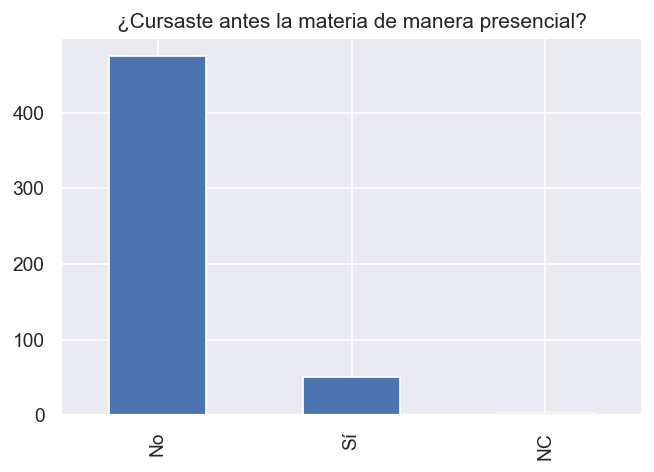

### Respuestas por curso

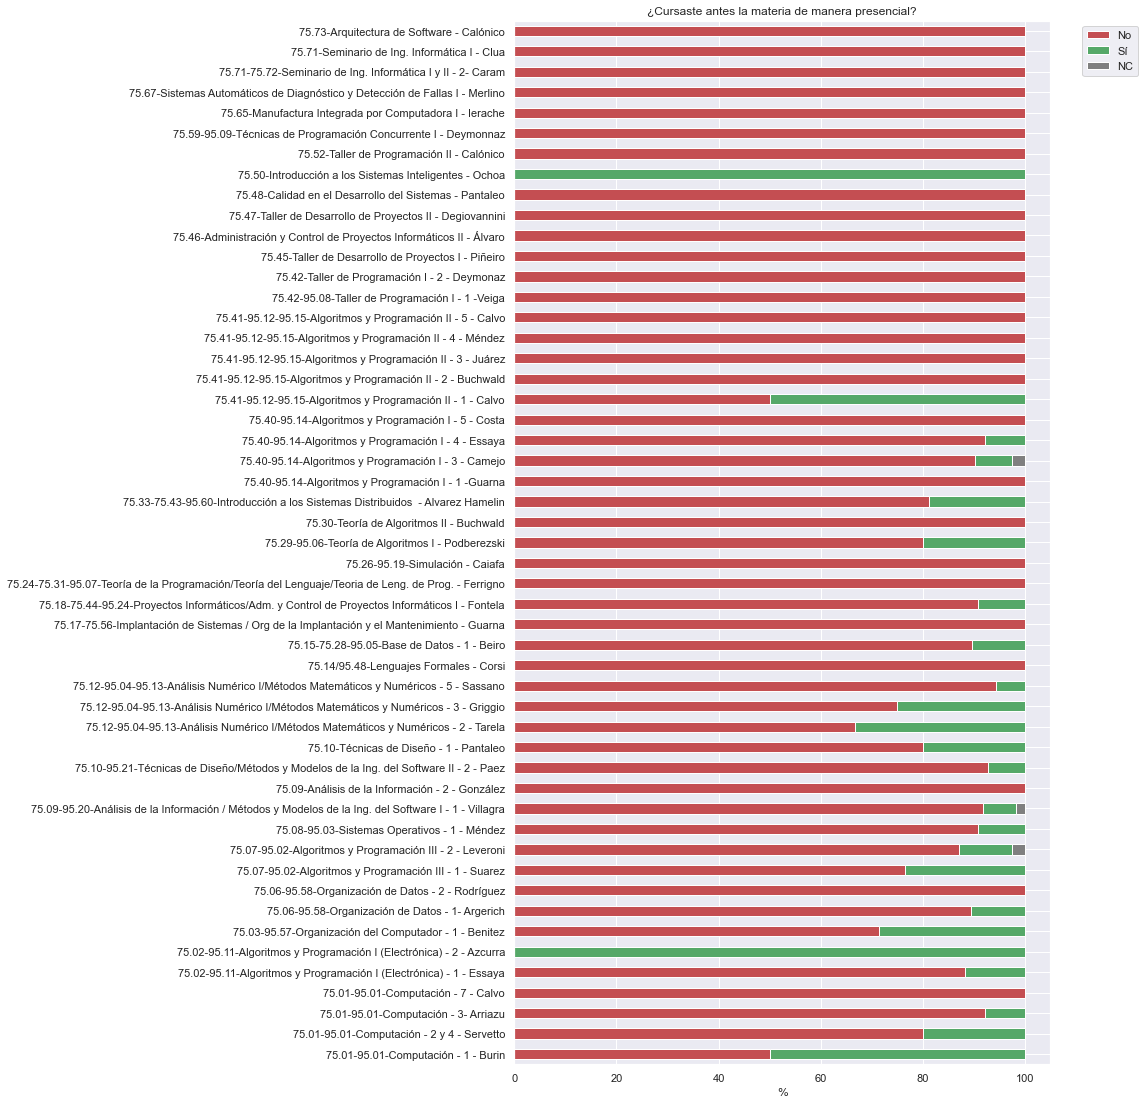

## ¿Cómo te parece que fue el desempeño de la cátedra respecto de lo que hubieras esperado en una cursada presencial/virtual en los siguientes aspectos?  [Clases teóricas]

### Histograma por respuesta

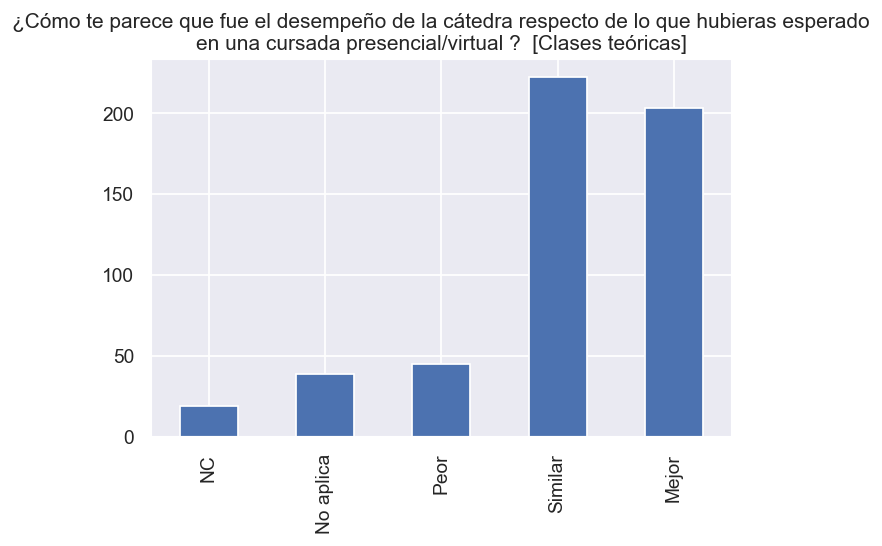

### Respuestas por curso

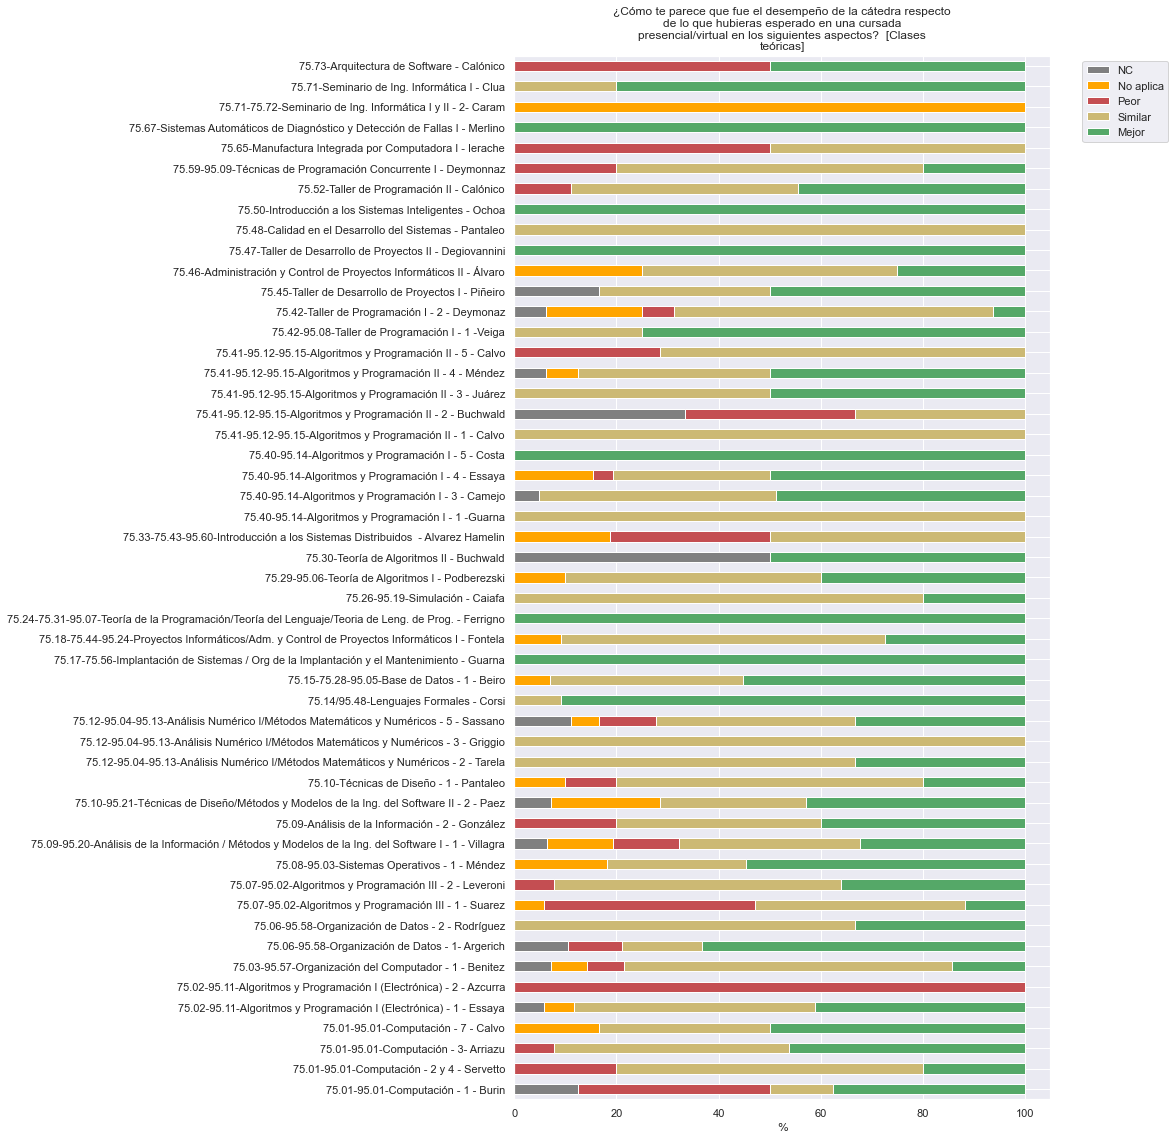

## ¿Cómo te parece que fue el desempeño de la cátedra respecto de lo que hubieras esperado en una cursada presencial/virtual en los siguientes aspectos?  [Clases prácticas]

### Histograma por respuesta

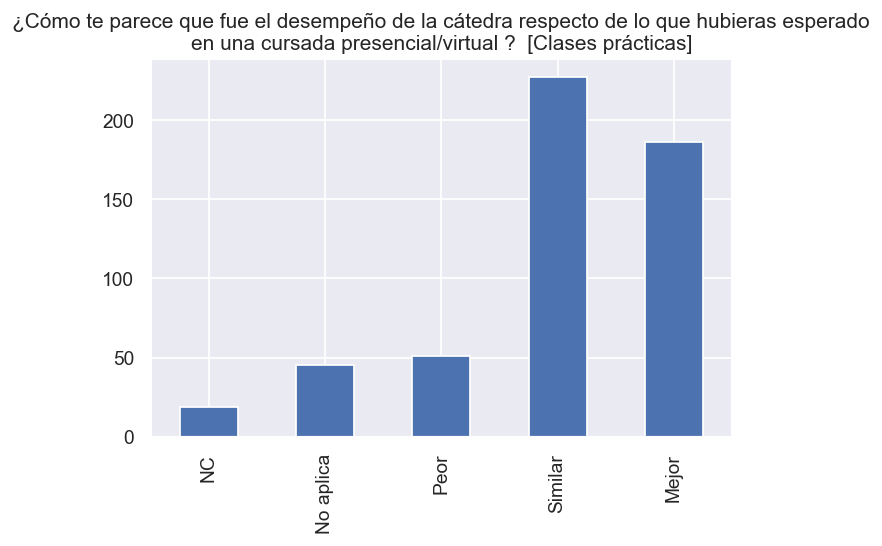

### Respuestas por curso

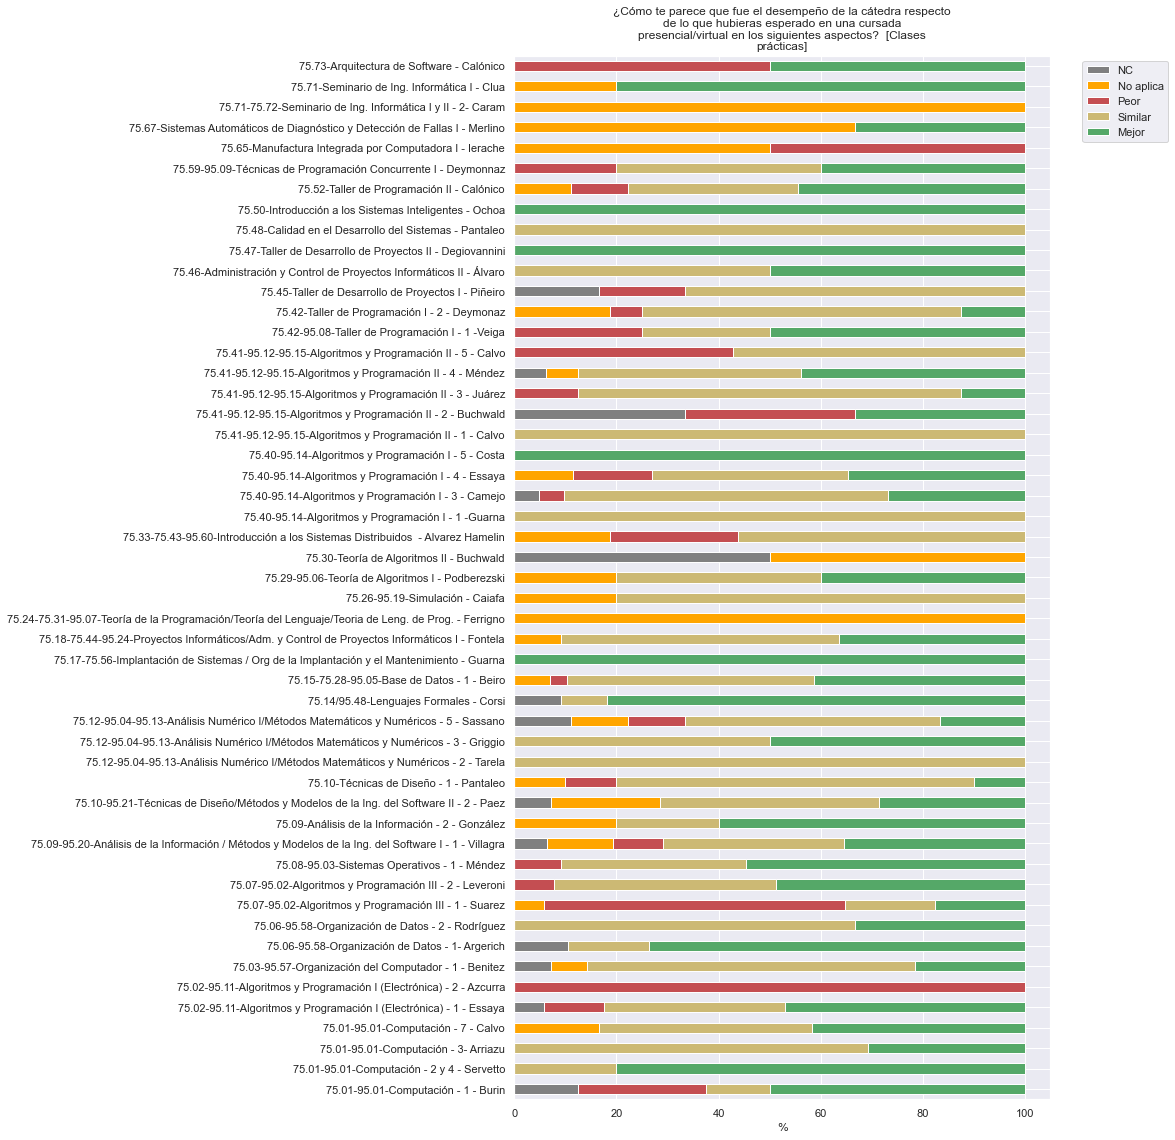

## ¿Cómo te parece que fue el desempeño de la cátedra respecto de lo que hubieras esperado en una cursada presencial/virtual en los siguientes aspectos?  [Trabajos prácticos]

### Histograma por respuesta

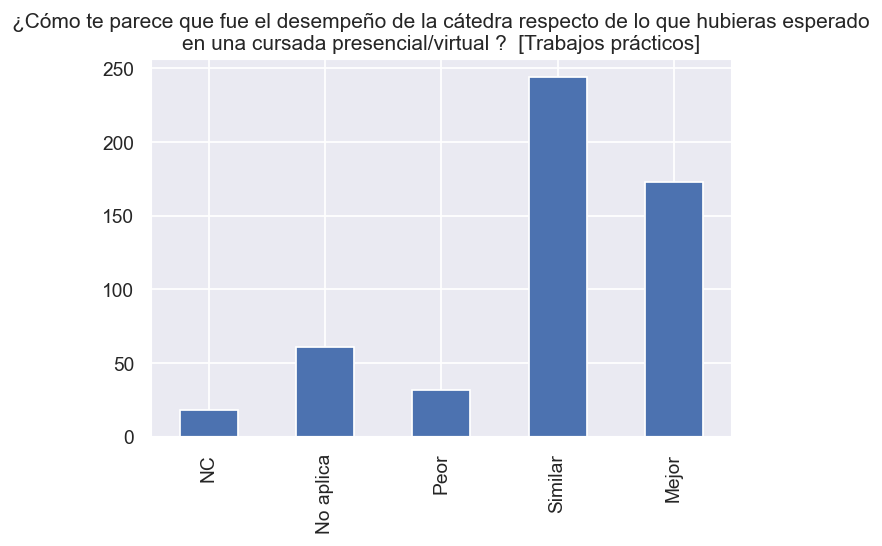

### Respuestas por curso

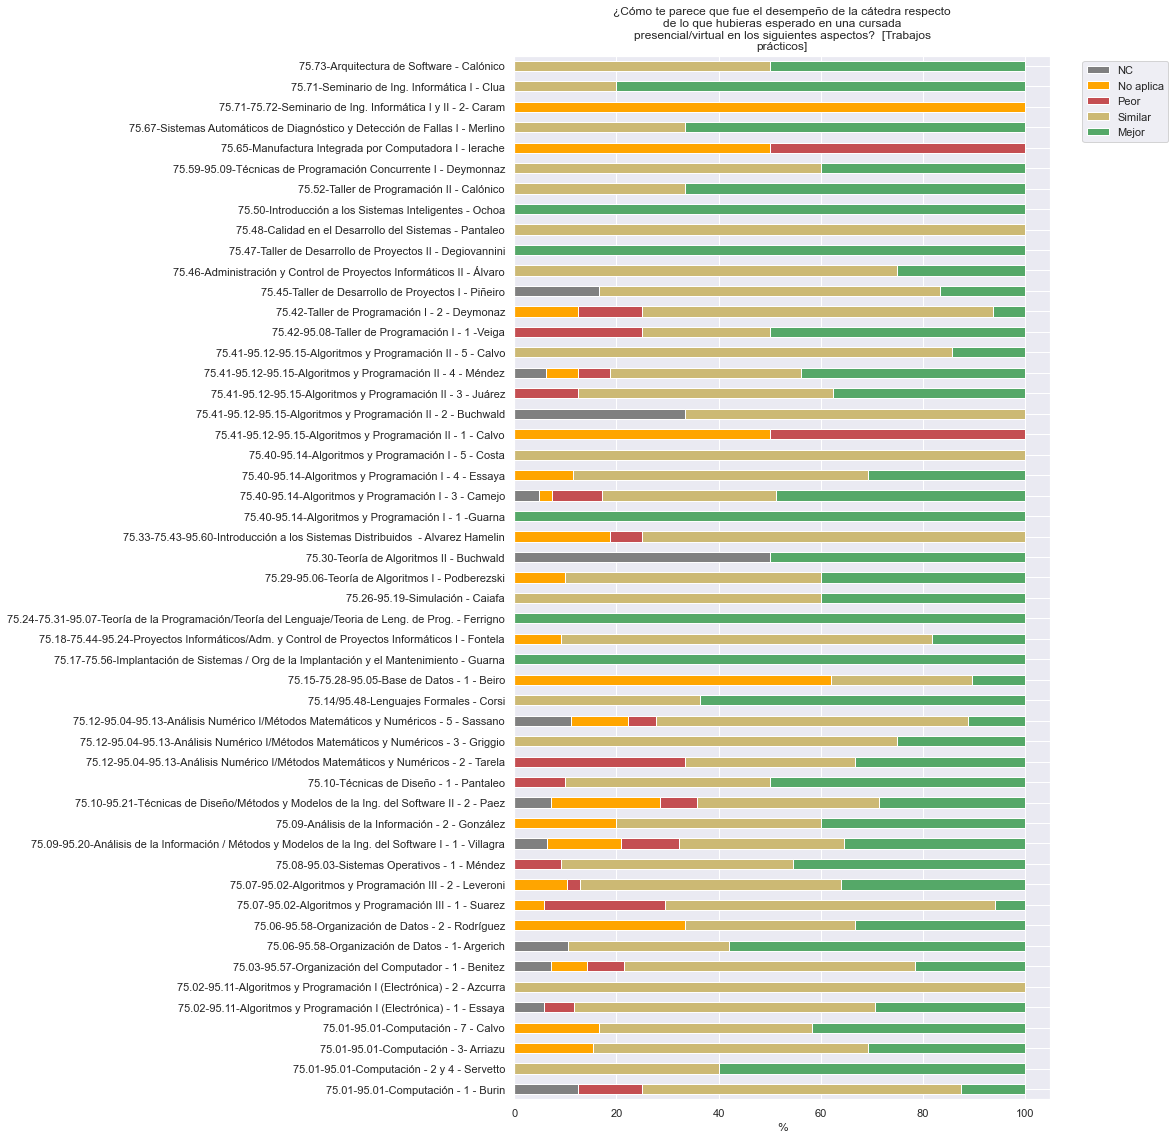

## ¿Cómo te parece que fue el desempeño de la cátedra respecto de lo que hubieras esperado en una cursada presencial/virtual en los siguientes aspectos?  [Instancias de consulta]

### Histograma por respuesta

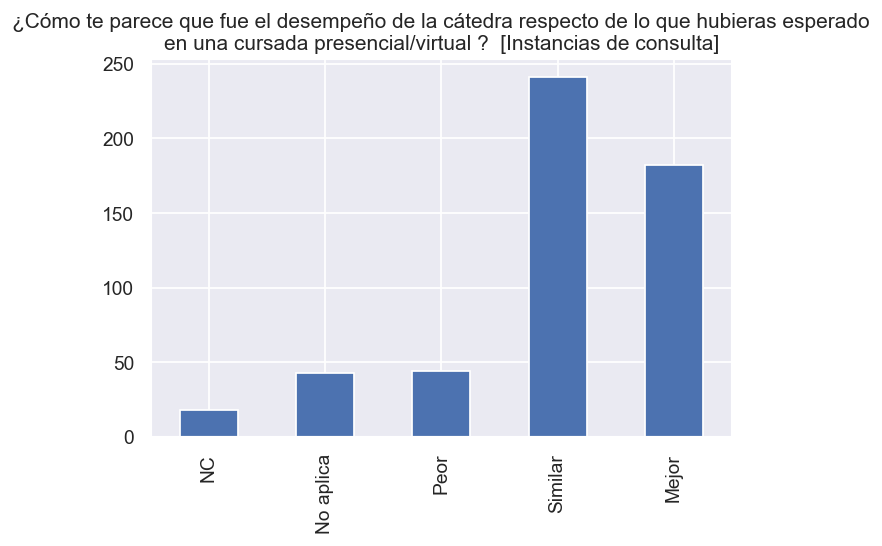

### Respuestas por curso

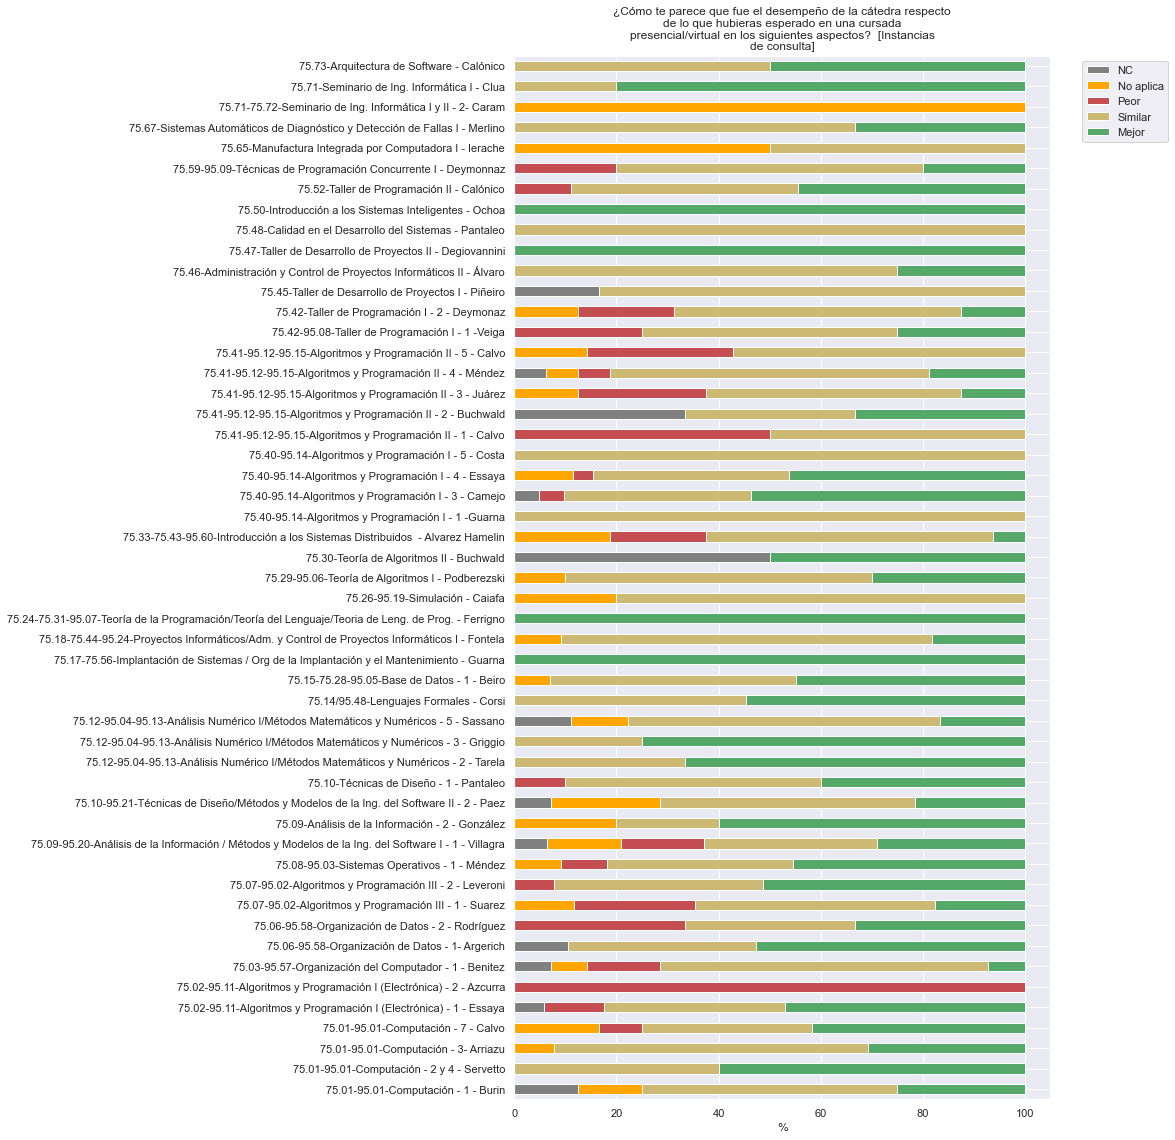

## ¿Cómo te parece que fue el desempeño de la cátedra respecto de lo que hubieras esperado en una cursada presencial/virtual en los siguientes aspectos?  [Tiempos de respuesta ante consultas]

### Histograma por respuesta

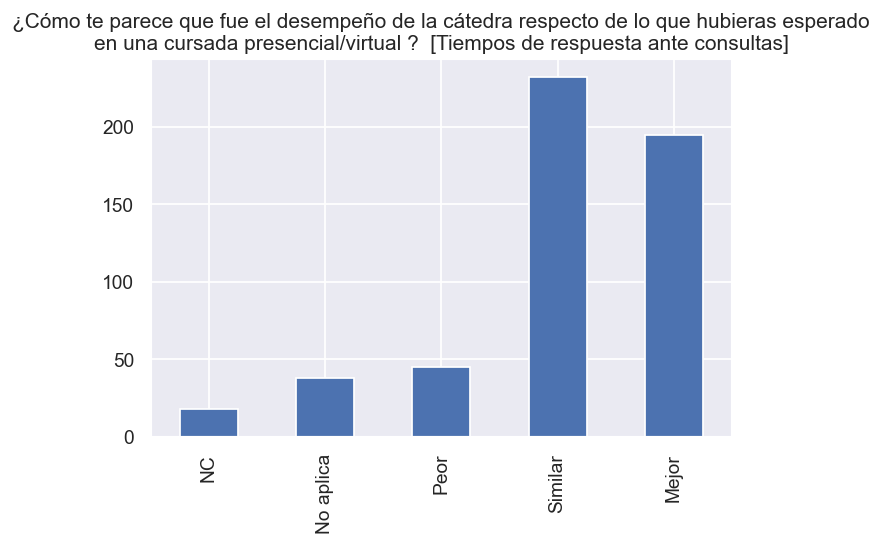

### Respuestas por curso

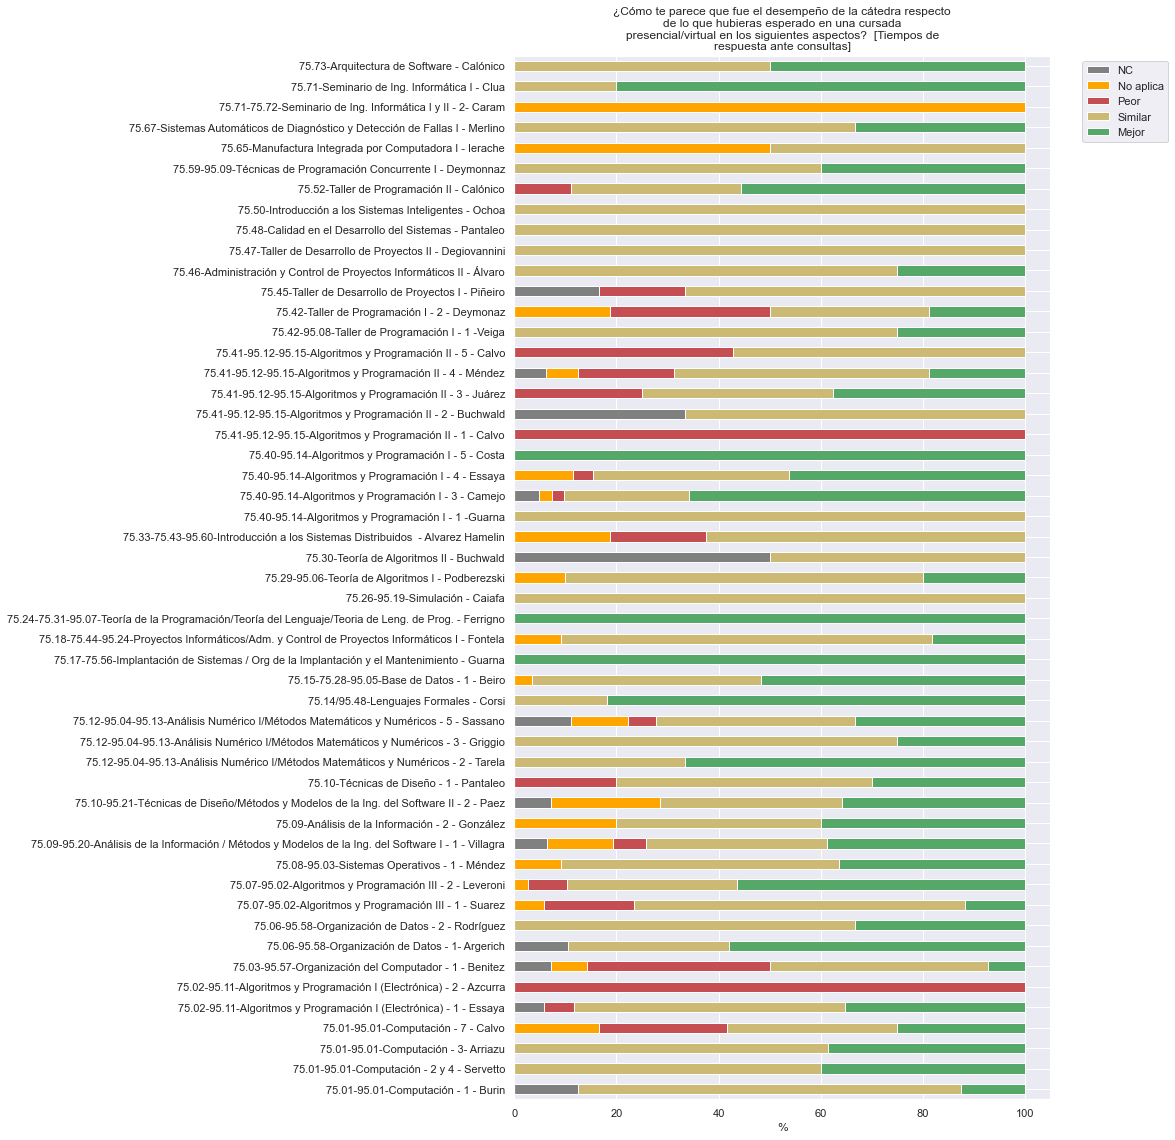

In [24]:
for col in columas_virtual:
    display(Markdown(f"## {col}"))
    display(Markdown(f"### Histograma por respuesta"))
    plt.figure(dpi=125)
    comp[col].replace(reemplazos_virtual, inplace=True)
    comp[col].fillna("NC", inplace=True)
    try:
        comp[col].value_counts()[orden_virtual].plot(kind="bar")
    except KeyError:
        comp[col].value_counts().plot(kind="bar")
    plt.title(
        "\n".join(wrap(col.replace("en los siguientes aspectos", ""), 88)), wrap=False
    )
    plt.show()

    display(Markdown(f"### Respuestas por curso"))
    newcol = col.replace(
        "¿Cómo te parece que fue el desempeño de la cátedra respecto de lo que hubieras esperado en una cursada presencial en los siguientes aspectos?",
        "",
    ).strip(" []")
    agg_col = (
        comp.rename(columns={col: newcol})
        .groupby(["Elige el curso", newcol])
        .size()
        .unstack(fill_value=0)
    )
    try:
        agg_col_pcts = agg_col.div(agg_col.sum(axis=1).values, axis=0).mul(100)[
            orden_virtual
        ]
        ax = agg_col_pcts.sort_index().plot.barh(
            stacked=True,
            figsize=(6.4 * 1.5, 4.8 * 4),
            color=["gray", "orange", "r", "y", "g"],
            title="\n".join(wrap(col, 60)),
            ylabel="%",
            legend=False,
        )
        ax.set_ylabel("")
        ax.set_xlabel("%")
    except KeyError:
        agg_col_pcts = agg_col.div(agg_col.sum(axis=1).values, axis=0).mul(100)[
            ["No", "Sí", "NC"]
        ]
        ax = agg_col_pcts.sort_index().plot.barh(
            stacked=True,
            figsize=(6.4 * 1.5, 4.8 * 4),
            color=["r", "g", "gray"],
            title="\n".join(wrap(col, 60)),
            ylabel="%",
            legend=False,
        )
        ax.set_ylabel("")
        ax.set_xlabel("%")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

## ¿Qué aspectos valorás positivamente de la cursada remota?

Entendemos que estos aspectos no se corresponden con cada cátedra, si no en general.

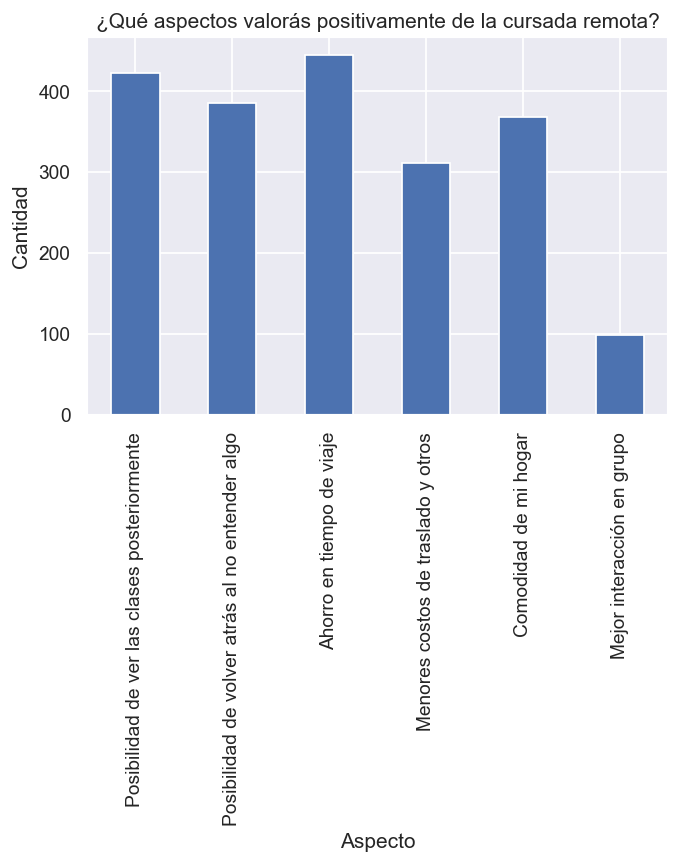

In [25]:
plt.figure(dpi=125)

aspectos = [
    "Posibilidad de ver las clases posteriormente",
    "Posibilidad de volver atrás al no entender algo",
    "Ahorro en tiempo de viaje",
    "Menores costos de traslado y otros",
    "Comodidad de mi hogar",
    "Mejor interacción en grupo",
    "Ahorro en tiempo de viaje",
]

df_aspectos_pos = pd.DataFrame()

column_text = comp[
    "¿Qué aspectos valorás positivamente de la cursada virtual? (elegí todas las que apliquen)"
].dropna()

for aspecto in aspectos:
    df_aspectos_pos[aspecto] = column_text.str.contains(aspecto)

df_aspectos_pos.sum().plot(kind="bar")
plt.ylabel("Cantidad")
plt.xlabel("Aspecto")
plt.title("¿Qué aspectos valorás positivamente de la cursada remota?")
plt.show()

## ¿Qué aspectos valorás negativamente de la cursada remota?

Entendemos que estos aspectos no se corresponden con cada cátedra, si no en general.

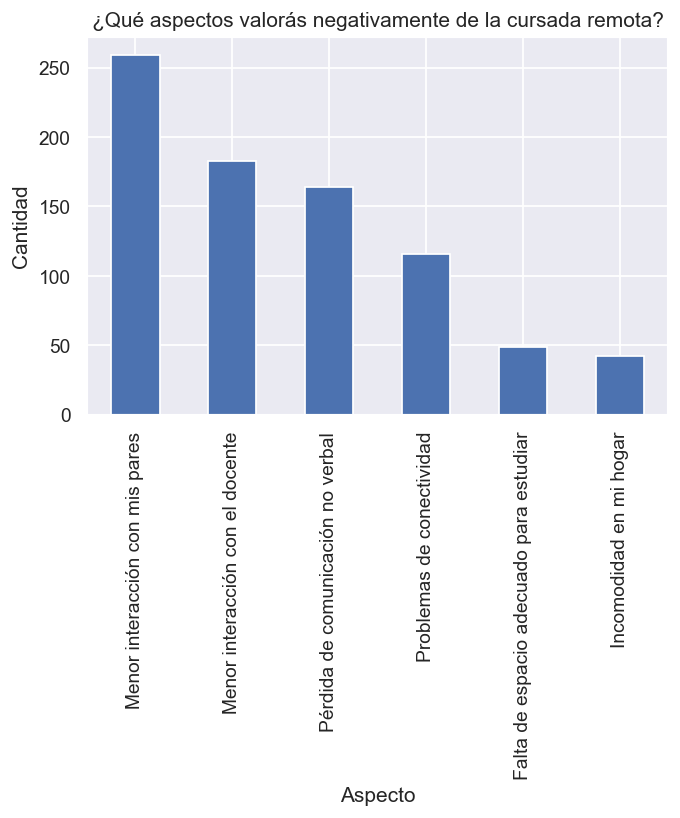

In [26]:
plt.figure(dpi=125)

aspectos = [
    "Menor interacción con mis pares",
    "Menor interacción con el docente",
    "Pérdida de comunicación no verbal",
    "Problemas de conectividad",
    "Falta de espacio adecuado para estudiar",
    "Incomodidad en mi hogar",
]

df_aspectos_neg = pd.DataFrame()

column_text = comp[
    "¿Qué aspectos valorás negativamente de la cursada remota? (elegí todas las que apliquen)"
].dropna()

for aspecto in aspectos:
    df_aspectos_neg[aspecto] = column_text.str.contains(aspecto)

df_aspectos_neg.sum().plot(kind="bar")
plt.ylabel("Cantidad")
plt.xlabel("Aspecto")
plt.title("¿Qué aspectos valorás negativamente de la cursada remota?")
plt.show()

## Correlación entre aspectos positivos y negativos

In [27]:
df_aspectos = (
    df_aspectos_pos.join(df_aspectos_neg, how="outer").fillna(False).astype(int)
)
cooc = df_aspectos.T.dot(df_aspectos)
mask = np.zeros_like(cooc)
mask[np.triu_indices_from(mask)] = True

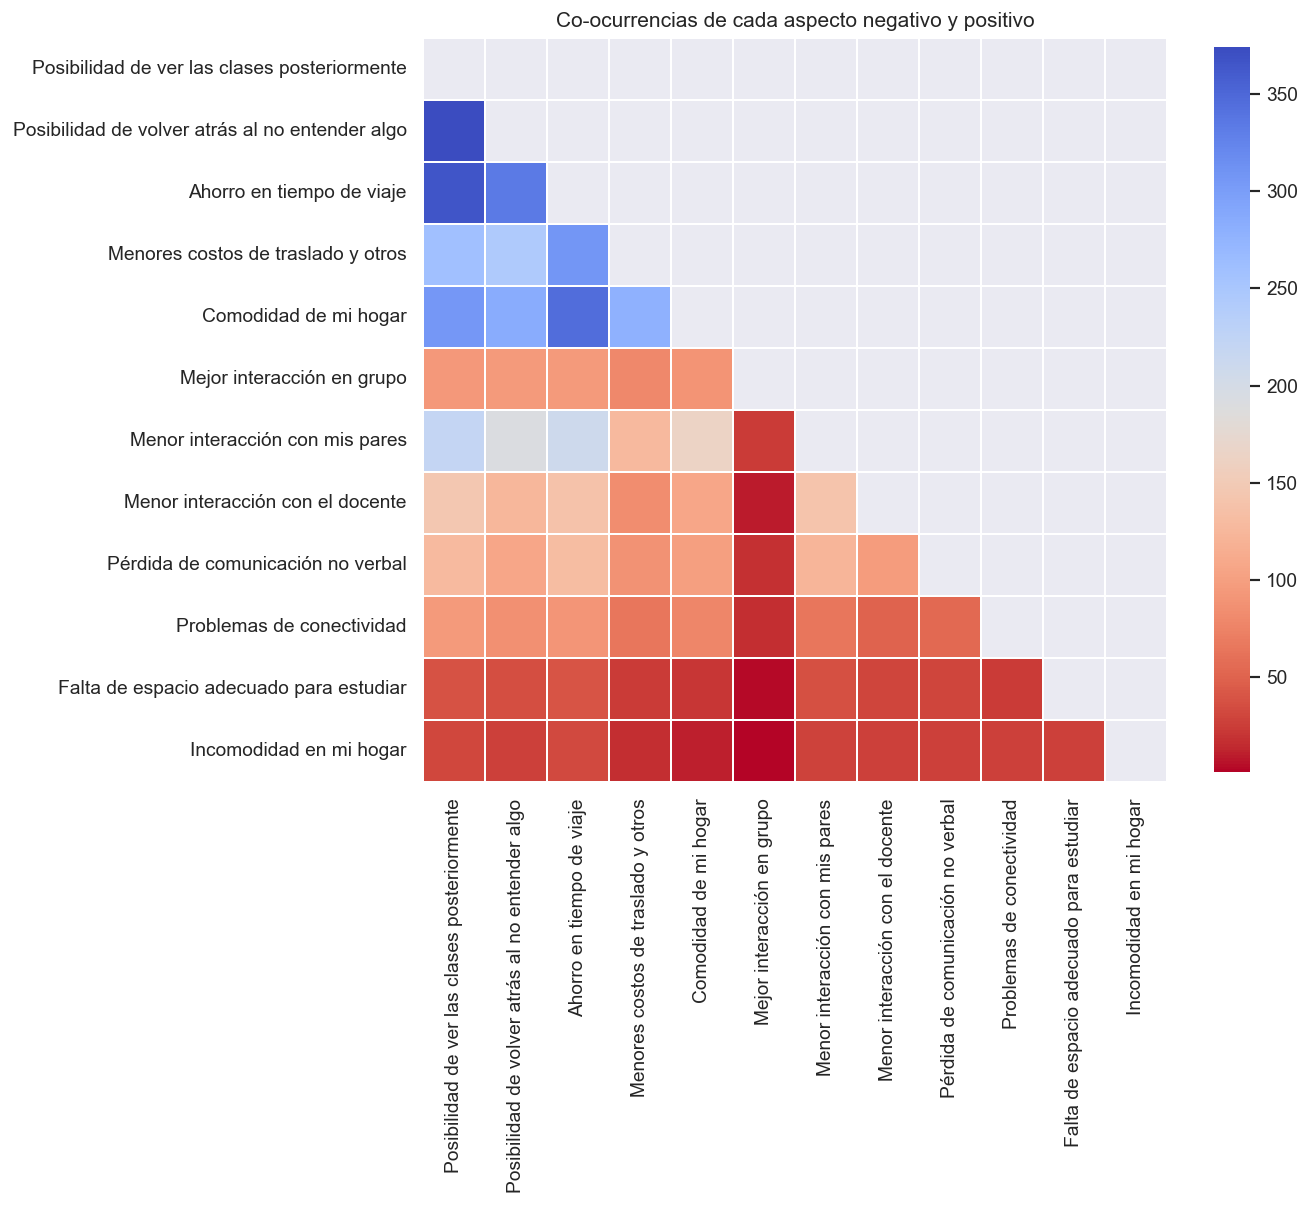

In [28]:
plt.figure(dpi=125, figsize=(6.4 * 1.5, 4.8 * 4))

sns.heatmap(
    data=cooc,
    cmap="coolwarm_r",
    linewidths=0.2,
    square=True,
    cbar_kws={"shrink": 0.4},
    mask=mask,
)
plt.ylabel("")
plt.title("Co-ocurrencias de cada aspecto negativo y positivo")
plt.show()

# ¿Creés que la cátedra estuvo a la altura de una cursada virtual? En cuanto a herramientas, comunicación, material, etc

In [29]:
def procesar_comentario(c):
    try:
        lineas = c.split("\n")
    except:
        print(c)
        raise
    return "\n".join([f"{l}" for l in lineas])


for curso in sorted(comp["Elige el curso"].unique()):
    display(Markdown(f"## Curso {curso}"))
    com = comp[comp["Elige el curso"] == curso][
        "¿Creés que la cátedra estuvo a la altura de una cursada virtual? En cuanto a herramientas, comunicación, material, etc"
    ].dropna()
    if com.empty:
        display(Markdown("_No hay comentarios_"))
    else:
        todos_los_comentarios = com.str.capitalize().value_counts().to_dict()
        for comentario, count in todos_los_comentarios.items():
            try:
                if comentario == "":
                    continue
                count_suffix = ""
                if count > 1:
                    count_suffix = f"**({count} comentarios idénticos)**"
                display(
                    Markdown(f"- {procesar_comentario(comentario)} {count_suffix}\n\n")
                )
            except:
                # print(todos_los_comentarios, curso)
                raise

## Curso 75.01-95.01-Computación - 1 - Burin

- Si **(3 comentarios idénticos)**



- No 



- Si estuvo a la altura 



- Si estuvo a la altura, ademas de que nos daban tiempo para responder preguntas , nos explicaban lo que no entendiamos y nos guiaban en las dificultades para poder seguir avanzando con buen ambiente  



## Curso 75.01-95.01-Computación - 2 y 4 - Servetto

- Si **(2 comentarios idénticos)**



- Si. 



- Estuvo mejor presencial entiendo más que en virtual  



- Si, se manejo bien  



## Curso 75.01-95.01-Computación - 3- Arriazu

- Si **(4 comentarios idénticos)**



- Es excelente la cátedra  



- Pienso que en cuanto a la práctica (respecto al material y comodidad de nuestra casa) estuvo a la altura. 



- Sí  



- Sí, mucho  



- Si. comparando con otras materias que también se manejan de igual manera con la cursada, computación se las arregló mucho mejor con respecto al campus y las clases virtuales. destaco la posibilidad de tener las clases grabadas y la claridad a la hora de brindarnos el material teórico. 



- Si, el material del campus me resulto muy util a la hora de hacer las practicas 



- Si, por lo que es más cómodo ver cómo programan directo en una computadora que en el pizarrón. ya que ahí si hay una falla de tipeo o algo por el estilo salta el error. como cuando tenemos que escribirlo nosotros por nuestra cuenta 



- Creo que sí, además pienso que es una materia que está entre las pocas que deberían darse mayoritariamente de manera virtual 



## Curso 75.01-95.01-Computación - 7 - Calvo

- Si **(6 comentarios idénticos)**



- Sí. 



- Sí  



- En mi opinión, la cátedra se desempeñó perfectamente y, de hecho, supieron aprovechar con gran habilidad los beneficios de la virtualidad como herramienta de enseñanza.  



## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 1 - Essaya

- Si **(4 comentarios idénticos)**



- Estuvo no sólo a la altura, sino que la modalidad semipresencial es espectacular y además está cátedra supera por mucho tanto en calidad como en enseñanza a muchas cátedras de algoritmos 1 



- La cátedra de essaya es excelente, pero prefiero la presencialidad 



- La catedra que cursé tenia modalidad semipresencial que ayudaba mucho la verdad 



- Sí 



- Al ser en parte virtual y parte presencial tiene lo mejor de los dos mundos, creo que está por encima de una cursada puramente virtual o presencial 



- Me parece que, si bien se adaptaron a la modalidad virtual,  me parece que son temas muy complicados para quienes nunca programaron, por lo que deberían ir más despacio o partir a la materia, porque sino es imposible de llevarla. 



- Si, totalmente seguíamos con los mismos o mas recursos que tuve en otras materias que cursé virtualmente. 



- En nuestro caso fue semipresencial y puntualmete yo en las clases teoricas me aburria y al charlarlo con mis compañeros me di cuenta que no fui el unico, no  estoy diciendo  que sean malas, todo lo contrario me parecen que el profesor explica muy bien pero que al ser virtual la clase teorica se pierde un poco el trato que hay en las presenciales, y los memes de las filminas estan un poco viejos la verdad, en conclusion  a mi puntualmente no me sirvio de nada las teoricas (igualmente asisti a todas las teoricas), aprendia todo de las practicas y de los tps. 



- Si, estuvo mucho mejor de lo esperado 



## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 2 - Azcurra

- Para nada, es de las peores cátedras de toda la facultad. nunca vi docentes con tan pocas ganas de dar clases. 



## Curso 75.03-95.57-Organización del Computador - 1 - Benitez

- Si **(2 comentarios idénticos)**



- Sí, creo que la cátedra estuvo a la altura de una cursada virtual. 



- Al tener parte practica de programación y practicas que se hacen mejor en excel que en papel, es mucho mejor seguir la clase que estar rayando la hoja si hay que agregar una fila mas 



- Creo que se acecua bien, pero soy yo el que falla a la hora de entender el lenguaje 



- Si, pero en el tema de la comunicación, las dudas en el foro se responden muy tarde o ni se responden 



- Sí. 



- No, pero tampoco en la presencialidad. no contestan nunca por el campus. ofrecen corregir el unico tp como una precorrección pero no contestan el mail hasta la semana de entrega. tienen una página de material lo cual está muy bueno pero una falta de comucación tanto en la virtualidad como presencial. solo usan el campus y no contestan. 



- Si, estuvo a la altura. 



- Si, totalmente  



## Curso 75.06-95.58-Organización de Datos - 1- Argerich

- Sí **(3 comentarios idénticos)**



- Si **(3 comentarios idénticos)**



- Si, se encuentra %100 a la altura 



- Si, la catedra fue excelente y se adapta muy bien a la modalidad virtual 



- Totalmente!  



- Sí, la materia es mucho mejor de manera virtual y la cátedra está a la altura 



- Si, la materia se da muy bien de manera virtual 



- La materia yo la curse presencial en 2019 y luego 2 veces virtual , y siempre fue mejor virtual mas que nada porque todo lo que se hace es practico y en un aula con 150 personas no se ve nada en el proyector, no hay forma de repasar porque las clases no se graban y si llegaste tarde a penas podes ver y escuchar algo. asi que mil puntos arriba la clase virtual, ojala siga virtual para los siguientes alumnos. 



- Sí, totalmente. 



- Creo que la cursada virtual permitió una fantástica interacción con los profesores y con los compañeros de curso en este caso mediante la herramienta slack. todas las dudas se respondían casi al instante! 



- La cátedra estuvo a la altura de una cursada virtual en cuanto a herramientas, comunicación, material, etc. 



## Curso 75.06-95.58-Organización de Datos - 2 - Rodríguez

- Si 



- Sí 



## Curso 75.07-95.02-Algoritmos y Programación III - 1 - Suarez

- Si **(3 comentarios idénticos)**



- No **(2 comentarios idénticos)**



- Sí 



- Si. 



- Sí, la mayoría de las clases fueron virtuales. al ir presencial fue un desastre la asignación de aulas. no se respetaba protocolo. siempre dábamos vueltas por encontrar un aula decente para tantos estudiantes 



- A nivel comunicacion fue regular por la cantidad de alumnos en el curso, pero tambien a la poca claridad respecto al transcurso de las semanas respecto a actividades, fechas de evaluacion y de entregas, lecturas requeridas para las clases, etc 



- En parte (sólo las teóricas y las entregas de tp) 



- . 



- Fue 95% virtual, y me en mi opinion estuvo bien que fuese así. 



- Si, entre los videos y las clases se desempeñaron bien 



- No estuvo a la altura, las clases teóricas videos grabados de otros cuatrimestres, no se entienden , las prácticas muy poca predisposición del docente, no saben explicar los temas para que los alumnos lo entiendan, los temas están buenos pero no saben explicarlos, muy poco tiempo y muchos temas, una lastima porque los temas están buenos pero no se entienden en tan corto tiempo, los profesores no saben transmitir su conocimiento 



- No, la verdad es que muy poco didáctico todo y no se terminan de entender los temas cuando explican, además de que había clases que eran omitidas y el profesor no daba clases 



- Si, se adecuaron perfectamente utilizando la virtualidad com complemento a las clases presemciales 



## Curso 75.07-95.02-Algoritmos y Programación III - 2 - Leveroni

- Si **(13 comentarios idénticos)**



- Completamente **(2 comentarios idénticos)**



- La cursada fue semipresencial y estuvo excelente tanto la parte virtual como presencial. 



- En dias virtuales se desarrollo mejor la clase  



- Si, aunque fue presencial la mayoria 



- La cursada fue mayormente presencial... 



- Si totalmente 



- Me parece que sí, siempre grabaron las clases y no tenían problemas de conexión. 



- Totalmente, estuvo todo muy bien dado 



- Si, completamente a la altura 



- La cátedra surgió virtual así que está muy bien adaptada, pero también se adaptó muy bien a la presencialidad. 



- La cursada fue semi presencial. tanto la parte virtual como la presencial estuvieron muy bien con tema planificación, comunicación, material, etc. sí tenían un bot de discord que funcionaba medio pelo para anunciar las clases y para la mitad del cuatri ya te decían que directamente lo ignores 



- Si, si van a hacer modalidad mixta, mas en las materias de programación, deberían ofrecer mejores herramientas de trabajos (compus y laptops) para la gente que no puede llevar porque vive lejos o no tiene 



- Sí, la cátedra "nacio" virtual y el nivel se mantuvo incluso con la presencialidad 



- Sí 



- Si!! 



- Si, debería haber sido mayormente virtual, las clases presenciales era difíciles de seguir porque éramos muchos en el aula 



- Si totalmente e incluso mejor  



- Si, se organizaron muy bien. 



## Curso 75.08-95.03-Sistemas Operativos - 1 - Méndez

- Si **(4 comentarios idénticos)**



- Si. los tps si no era virtual no los aprobaba de ninguna manera. 



- Completamente a la altura!  



- Creo que fue mejor que la version virtual. las clases teoricas eran clases magistrales. no estoy seguro de que virtualmente se pueda dar semejante nivel y profundidad en esta materia (al menos a nivel teorico).
las clases practicas son mucho mejores siendo virtuales, ante la necesidad de los profesores de manipular o mostrar el codigo en los tps
 



- Las practicas virtuales fueron excelentes y hay mucho material armado por ellos a disposicion para una cursada mixta 



- Sí, la cátedra usa un discord donde están todos los docentes y alumnos, y se mantiene una comunicación muy fluida. también cuentan con una página de cátedra que brinda información adicional de bibliografia, calendario y troubleshooting 



- Sí 



## Curso 75.09-95.20-Análisis de la Información / Métodos y Modelos de la Ing. del Software I - 1 - Villagra

- Si **(24 comentarios idénticos)**



- Sí **(3 comentarios idénticos)**



- Si. **(2 comentarios idénticos)**



- Si, se adaptó muy bien 



- Si, respondian todas las consultas en el grupo de slack 



- Se manejaron bien virtualmente. innecesarias las veces que fuimos presencial este cuatrimestre.  



- Si, totalmente, la virtualidad hace la cursada mucho mas amena, de ser presencial creo que no hubiera podido aprobar esta materia. 



- Se adapto correctamente a la virtualidad mas que nada porque cuando se hizo presencial fue muy desprolija la organizacion de un aula adecuada para la demanda de alumnos (desconozco la responsabilidad de este punto) 



- Sí  



- Si, muy a la altura. me gustó mucho 



- - 



- Si, estuvo a la altura de una cursada virtual. luego de 4 cuatrimestres virtuales (5 si contamos este de 1c-2022), la cátedra está bastante adaptada en cuanto a la forma de evaluar y comunicar los temas. se proveen de videos de las "clases teóricas" para verlos antes de la clase. utilizan slack como medio de comunicación y google classroom para la entrega de los ejercicios semanales y el cálculo de la calificación de los mismos. se utiliza zoom como plataforma para tener clases sincrónicas. 



- Sí, de hecho me cuesta creer que esta materia se daba de forma presencial. muchos de los temas dados fueron beneficiados por la comodidad de la cursada virtual 



- Estuvo a la altura, pero siento que esta es una materia que se puede apreciar mejor de manera presencial 



- Si.

se adapto bien a la virtualidad y se aprovecharon los recursos.
la materia deveria ser completamente virtual.

el unico desaprovecho que marcaria fue cuando insistieron dar clase presencial un dia que hubo marcha y corte de calles, donde se dificultaba mucho la asistencia y hubiera sido mucho mejor dar virtual. 



- El material disponible es mas que suficiente, lo mejorable esta en la respuesta de los profesores a la hora de consultar 



- En general si. 



- No 



- Totalmente 



## Curso 75.09-Análisis de la Información - 2 - González

- Si 



## Curso 75.10-95.21-Técnicas de Diseño/Métodos y Modelos de la Ing. del Software II - 2 - Paez

- Sí **(2 comentarios idénticos)**



- Las clases virtuales resultan mejores que las presenciales 



- Se tuvo una cursada mitad presencial y mitad virtual, la comunicacion fue muy buena. 



- En este caso fue una cursada híbrida. las clases teoricas presenciales son excelentes, las remotas no tanto. 



- La cátedra brinda muchas herramientas y materiales para poder llevar la materia al día. la comunicación es muy fluida y responden las consultas a la brevedad.  



- La virtualidad fue bien aprovechada. fue una buena manera de aplicar modalidad mixta 



- Si, todo. 



- Si 



- Si, totalmente. 



- En este caso fue hibrido, pero estuvo muy buena no tengo nada de que quejarme 



- Si, muy bien manejado y buen material en forma de videos y lecturas 



## Curso 75.10-Técnicas de Diseño - 1 - Pantaleo

- Si **(3 comentarios idénticos)**



- No **(2 comentarios idénticos)**



- Si, totalmente 



- Estuvo a la altura. 



- Podria mejorar algunas cuestiones, mejorar las ppts y la organización de la clase. 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 2 - Tarela

- Sí **(2 comentarios idénticos)**



- La parte virtual de la cursada me parecio muy bien planteada. el material teorico era claro y conciso y la reunion para consultas siempre fue util. 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 3 - Griggio

- No fue virtual 



- Si 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 5 - Sassano

- Si **(4 comentarios idénticos)**



- La cursada no fue virtual, las teóricas eran presenciales y las practicas eran ya grabadas de otros cuatrimestres. habían clases de consulta todos los jueves virtuales. 



- Si. 



- Sí, habían muchos ejemplos de los temas en el campus para reforzar lo visto en clase. 



- Si y me gusto mas cursarla presencial, el intercambio era mas fluido 



- Es mejor tener presencial 



- Se desempeñó bien
 



- Si, excelente la atención de los profesores.  



- Sí 



- Si  



- Si respecto a todo. es excelente la cátedra 



- Creo que la cátedra estuvo a la altura de la cursada virtual. sí es cierto que se dificulta el ida y vuelta tanto con los profesores, como con los compañeros. 



## Curso 75.14/95.48-Lenguajes Formales - Corsi

- Si **(3 comentarios idénticos)**



- Si, estuvo muy bien organizada 



- Esta buena la catedra, linda materia, la práctica esta buena xq nos hace practicar pero le daria un poco mas de dinamica, que el profe comparta las soluciones de otra forma q por el chat, resulta incomodo. también a veces se hablan de soluciones al aire o escribe cosas x el chat q no se entienden estaria bueno q comparta pantalla y tenga alguna pizarra virtual o editor donde escribir asi no queda todo lo q dice en el aire 



- Totalmente 



- Realmente me gustó y puede que no se aproveche de la misma manera si fuese presencial 



- Si, todo perfecto 



- 100% 



- Sí, estuvo a la altura. el material provisto es excelente y completo. las clases por meet fueron excelentes, todos los temas fueron cubiertos y quedaron grabadas para poder repasarlas. la parte de foros de consulta del campus habría que reemplazarlo por otra herramienta, por ejemplo, slack, telegram, o algo más fluído. 



- Si re 



## Curso 75.15-75.28-95.05-Base de Datos - 1 - Beiro

- Si **(14 comentarios idénticos)**



- La catedra estuvo a la altura de la cursada semi presencial 



- Si, siempre se tuvo las herramientas, había clases por meet, se utilizó un canal de slack muy útil para anuncios y consultas.  



- Si, todos los recursos generados fueron excelentes. 



- Si estuvo muy bien organizada desde el dia 1. 



- Estuvo a la altura y supero. 



- Sí, muy a la altura. la catedra con mejor organización y comunicación que cursé en toda la carrera hasta el momento. el slack es clave para las consultas y siempre responden con la mejor onda. las clases fueron grabadas (incluso las presenciales!) y fácilmente accesibles desde el campus. 



- Si, se adaptaron muy bien a la modalidad hibrida. 



- Totalmente, incluso se encargaron de transmitir las clases presenciales para verlas en directo y también las compartían para poder verlas en el momento que quisieramos 



- Si. no podrian hacerlo mejor 



- Si, estuvo a la altura y superó ampliamente las espectativas 



- La modalidad es 50 virtual 50 presencial. estuvo muy a la altura, excelente cátedra, te hacen pensar con los ejercicios. es un verdadero placer cursar esta materia.  



- Si, había mucho material disponible 



- Son de lo mejor cursada en cuanto a organizacion general de la materia. tienen todo muy bien armado. 



## Curso 75.17-75.56-Implantación de Sistemas / Org de la Implantación y el Mantenimiento - Guarna

- Si en todo aspecto 



## Curso 75.18-75.44-95.24-Proyectos Informáticos/Adm. y Control de Proyectos Informáticos I - Fontela

- Si **(3 comentarios idénticos)**



- Fue mixta la modalidad, pero si, no hubo ningún problema. 



- Si! mucho material ya listo con bastante anticipación. material de lectura muy interesante 



- Si, totalmente. 



- Si, las clases se desarrollaron de acuerdo al cronograma y con el material de cada clase disponible de antemano. muy buena comunicación a través de mail y foros, anticipando cada clase. la "ejecución del cronograma" fue excelente.  



- Sí 



- Muy a la altura. 



- Si, muy a la altura 



- Podría haberse aprovechado mejor los momentos de virtualidad, pero la cátedra está explorando posibilidades y opciones por lo que no tengo duda que mejorará 



## Curso 75.24-75.31-95.07-Teoría de la Programación/Teoría del Lenguaje/Teoria de Leng. de Prog. - Ferrigno

- Si 



## Curso 75.26-95.19-Simulación - Caiafa

- Si **(2 comentarios idénticos)**



- La cátedra se manejó muy bien con la comunicación y siempre estuvimos al tanto de todo. 



## Curso 75.29-95.06-Teoría de Algoritmos I - Podberezski

- Si **(2 comentarios idénticos)**



- La cátedra si bien tiene que dar 2 días de clase daba 1 sólo. las clases de consulta fueron inexistentes. 



- Sin ninguna duda 



- La cursada mixta (teorica virtual, practica presencial) fue excelente. la posibilidad de contar con el material teorico para llevarlo a nuestro propio ritmo y pudiendo revisar un tema dado las veces que sean necesarias me parecen beneficios de incalculable valor que nos dejó la virtualidad. especialmente considerando el altisimo nivel de dicho material. ojala se pueda mantener, y no solo para esta materia. 



- Si. hay mucho material 



- Excelente. diez puntos 



## Curso 75.30-Teoría de Algoritmos II - Buchwald

- Absolutamente 



- Si 



## Curso 75.33-75.43-95.60-Introducción a los Sistemas Distribuidos  - Alvarez Hamelin

- Curse en esta misma catedra el cuatrimestre pasado y en lo personal sentí que cuando eran clases virtuales las clases teoricas me resultaban mas faciles de seguir. 



- No aplica. 



- La cursada fue 100% presencial, lo que me pareció un atraso increíble. no puedo creer tanto rechazo a la virtualidad por parte de profesores de informática. ni siquiera brindaron el material virtual generado en anteriores cuatrimestres, y la asistencia era obligatoria, si faltabas algunas clases quedabas afuera de la materia. el docente ni siquiera permitía que los alumnos saliéramos temprano de la clase (tomaba lista por segunda vez al final de la clase) cuando había compañeros que tenían que irse un poco temprano porque se les iba el tren. en todos estos años en la fiuba nunca vi algo similar. 



- Sí, fue un buen balance 



- No fue virtual 



- Hubo una única clase virtual y fue buena 



- Fue presencial. 



- No fueron virtuales, este curso fue presencial 



- No hubo virtualidad.
no se aprovecharon los recursos, las clases podrian haber sido virtuales (por mi parte tenia mas tiempo de viaje que de clase),  la comunicacion por slack podria haber sido mejor. 



- Si 



## Curso 75.40-95.14-Algoritmos y Programación I - 1 -Guarna

- Parcialmente 



## Curso 75.40-95.14-Algoritmos y Programación I - 3 - Camejo

- Si **(11 comentarios idénticos)**



- Sí **(2 comentarios idénticos)**



- En mi caso creo que si 



- Si, estuvo a la altura desde el primer momento 



- Absolutamente, incluso superaron las espectativas que tenia. nos ofrecieron muchas herramientas, como ejercicios extra y espacios dedicados a la resolucion de dudas. 
la comicacion con los alumnos en general fue muy buena a travez del discord de la catedra. a la hora de hacer anuncios eran directos y claros. tambien nos dieron la oportunidad de poder consultar 24/7 sobre cualquiera de los temas que vimos y respondian siempre con mucha rapidez y predispocicion, lo cual valoro mucho. 



- Si, estuvo excelente 



- Si re7 



- Si, son excelentes  



- Si, totalmente 



- Si, totalmente. 



- Si. 



- La cátedra en la que curse algo1 (camejo) me parece que se adecuo correctamente a a la virtualidad. siempre contestaron las dudas al instante y el material siempre estuvo disponible para que lo podamos leer y estudiar. los colaboradores fueron un diez y siempre con la mejor onda para ayudarte 



- Si, mucho material disponible y comunicacion muy clara! 



- Si, totalmente contaba con un montón de herramientas que considero funcionaron mejor que en una cursada presencial. 



- Si, la catedra manejó muy bien la cursada en la virtualidad. 



- No, creo que debería ser desechada la virtualidad, reafirmo mi idea siendo estudiante universitario desde hace 5 años ya, de los cuales 2 pase en virtualidad y fue lo peor 



- Creo que la materia supo adaptarse efectivamente 



- Totalmente. si bien se dieron también clases presenciales, las clases virtuales estuvieron muy buenas. los temas se dieron muy bien, hubo buena comunicación con los alumnos, y el material estuvo siempre al alcance. 



- ¡absolutamente! el hecho de que permitiesen ir virtual y presencial creo que fue el enfoque correcto ya que nos permitió experimentar lo mejor de ambas modalidades en la medida que nosotros, los alumnos, quisimos. 



- No hubo ningún inconveniente por la cursada virtual, el poder tener un grupo por discord donde hablar con profesores y colaboradores me pareció un gran acierto, ya que se podían resolver dudas fácilmente y dio la posibilidad que nosotros los alumnos nos podamos contestar. 



- La cátedra estuvo a la altura y más. super preparada, las clases se subían en poco tiempo luego de realizarse y estaban disponibles los enunciados de los ejercicios y las resoluciones casi automáticamente que terminaba la práctica. la comunicación por la plataforma de discord es muy dinámica, realizas una consulta y en poco tiempo obtienes una respuesta. 



- Al usar herramientas como discord, meet y youtube permitieron que la comunicación sea fluida y que haya posibilidad de ver las clases luego ante dudas que hayan quedado. la catedra estuvo muy a la altura 



- En cuanto a la cursada virtual me parece que supieron adaptarse bastante bien, dándonos la posibilidad de acceder a un discord donde las consultas se respondían de verdad bastante rápido. además el hecho de poder ver el código en el momento en el editor de texto ayuda a entender mejor los temas, sin necesidad de tener que estar buscando un buen lugar donde sentarse si la clase fuera presencial (en el caso de la cátedra en la que cursé se daban las dos opciones igualmente). el material sí tengo que decir que era escaso, solamente algunos apuntes teóricos de difícil comprensión; el resto era el código/ejercicios de clase donde encima no se adjuntaban notas cosa que ayudaría a recordar lo visto sin necesidad de volver a ver la clase. 



- Aprovechó al máximo los recursos a su dispocisión 



- Definitivamente si 



- La cursada stuvo excelente, el material fue suficiente y las clases teóricas estuvieron muy buenas. el profesor explicaba demasiado bien. 



## Curso 75.40-95.14-Algoritmos y Programación I - 4 - Essaya

- Si **(6 comentarios idénticos)**



- Sí **(3 comentarios idénticos)**



- Si,  la catedra estuvo excelente en todos los aspectos 



- Presencial > virtual 



- Si, lo estuvo. 



- Si, la cursada virtual fue buena. dicho eso, la cursada presencial me pareció superior.
ademas, considero que hubiese sido mejor haber tenido la cursada virtual un viernes en vez de un lunes; así uno puede aprovechar mejor el fin de la semana 



- Estuvo realmente a la altura 



- 100% 



- Completamente. teníamos todo el material y las herramientas a nuestra disposición en la página de la cátedra y comunicación directa con todos los docentes.  



- Sí, estuvo perfecto 



- Los materiales de estudio fueron muy útiles, creo que al haber gran variedad cada alumno puede encontrar material que le ayude. las filminas son resumidas y fácil de entender, el generador de ejercicios me ayudó mucho para practicar, pero muchos alumnos prefieren estudiar con los apuntes y la guía practica o rever las clases grabadas. personalmente me es difícil concentrarme en  las clases virtuales. las teóricas me parecieron buenas, pero me fue mas difícil entender las prácticas virtuales.  



- Impecable, totalmente a la altura. 



## Curso 75.40-95.14-Algoritmos y Programación I - 5 - Costa

- Sí, totalmente a la altura. muy buena comunicación por slack y muy buenas diapositivas para presentar los temas. 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 1 - Calvo

- No. a pesar de tener la herramientas y material que si estuvieron a la altura, la comunicación fue mala, los docentes no estaban para cuando se necesitaba una consulta o para enviar el primer trabajo práctico. 



- Por parte de las clases teóricas si. la profesora calvo brindó tanto la posibilidad de ver clases sincrónicas como asincrónicas y mucho material de estudio. además, estuvo siempre dispuesta a contestar preguntas. respecto a las prácticas, los últimos temas ni se dieron, hubo uno de los profesores que no brindaba clases asincrónicas entonces si tenías problemas de conexión no podía asistir a la clase, y el otro las brindaba pero no las subía a algún lado hasta que le insistieras muchas veces y no contestaba las consultas por mail en un tiempo adecuado  



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 2 - Buchwald

- Si **(2 comentarios idénticos)**



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 3 - Juárez

- Si **(3 comentarios idénticos)**



- Si, cumplió con todo 



- La catedra se adecuo perfectamente a la virtualidad.  



- En mi opinion se manejaron bien y estuvieron a la altura 



- Hay material disponible de todo, y los profesores por slack siempre te responden las dudas que tengas. 



- El problema de la catedra no tiene nada que ver con el formato en que se da la cursada.  para comunicarse usan slack, pero casi siempre queda tu consulta sin responder por algunos días o te responde un compañero que está en la misma situación que vos. hay material subido al campus que no solo es incompleto sino que algunas cosas están mal conceptualmente, como lo de templates, deberían revisar qué es lo que hay subido y sacar lo que está mal. lo bueno es que al ser virtual las clases se graban o las graba algun compañero y las podes volver a ver. 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 4 - Méndez

- Si **(6 comentarios idénticos)**



- Sí 



- Si , re bien adaptada 



- En herramientas de comunicación si, las principales criticas con en cuanto a la didáctica especial de la disciplina. 



- Si, muy bien preparada 



- Si, exepto por el tiempo destinado a las dudas, que como es virtual y puede hablar uno solo a la vez, se mira una sola duda a la vez, sin ayudanetes. 



- Si, super atentos. todo el material disponible y respondían consultas rápidamente 



- Muy a la altura 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 5 - Calvo

- Si **(2 comentarios idénticos)**



- En cuanto a comunicación no, en cuanto al resto si. 



- Yo diría que sí. ver otro comentario más abajo. 



- Creo que tranquilamente podría darse de forma virtual, con algunas clases practicas presenciales para consultas especificas o temas que son mas sencillos de explicar en persona y por supuesto examenes/parcialitos. en algunas clases practicas hubo problemas de transporte y perdimos bastante tiempo, cosa que en una cursada virtual no sucede. 



## Curso 75.42-95.08-Taller de Programación I - 1 -Veiga

- Sí **(2 comentarios idénticos)**



- Si 



## Curso 75.42-Taller de Programación I - 2 - Deymonaz

- Si **(3 comentarios idénticos)**



- Estuvo muy bien. la comunicación por discord podría mejorar, en la claridad de la información que bajan y en los tiempos de respuesta. 



- Tanto el discord como la página de la materia puede ser usados un poco mejor. en cuanto a comunicaciones: hay avisos que quedan perdidos en un chat random en el discord, se podría tener un canal propio de avisos de los docentes que solo se use para eso, por ejemplo, y capaz también dejar los anuncios en la página de la materia. en momentos resultó complicado conseguir los ejemplos de código mostrados y los videos de las clases, que si bien al pedirlas en el discord lo facilitan, estaria bueno que quede en algún lugar centralizado (la pagina de la materia o algún canal de discord, por ejemplo). aunque me parece que las clases podrian ser totalmente virtuales, si van a hacer un esquema híbrido estaría bueno tener un cronograma o saber con más anticipación cuáles serían presenciales y cuáles virtuales. más allá de lo mencionado, los docentes siempre estuvieron a disposición de consultas en el discord. 



- Es mucho mejor la cursada virtual, presencial es mucha gente para poco proyector y sonido, las clases hay que verlas mas de una vez para entender los conceptos asi que es necesario que sean grabadas. 



- Si. la informacion relacionada al tp era un poco escasa en todo internet asi que no es que halla estado corto lo que dieron 



- Sí. 



- Dentro de todo si, mi única queja seria la falta de respuesta por parte del personal de la materia a las consultas hechas mediante los canales de comunicación facilitados. 



- La comunicación por parte de la cátedra fue pésima y el material proporcionado fue pobre 



- Sí 



- Masomenos, los docentes tardan mucho en responder en el discord de la materia (a veces mas de 2 dias, aunque los veas conectados) y a veces responden cosas que no ayudan en lo mas minimo 



- Si. las reuniones semanales me pareció perfecto y super cómodo que sean virtuales. 



## Curso 75.45-Taller de Desarrollo de Proyectos I - Piñeiro

- Sí. 



- La práctica podría ser casi completamente virtual en especial los días que hay consulta por grupos y se debe viajar por 20 minutos de consultas, los cuales son sumamente útiles pero podrían ser tranquilamente virtuales. 



- Si, totalmente! 



- Si 



## Curso 75.46-Administración y Control de Proyectos Informáticos II - Álvaro

- Estas materias esta bueno que sean virtuales 



- Si 



- Sí, totalmente. 



## Curso 75.47-Taller de Desarrollo de Proyectos II - Degiovannini

- Si 



## Curso 75.48-Calidad en el Desarrollo del Sistemas - Pantaleo

- No 



## Curso 75.50-Introducción a los Sistemas Inteligentes - Ochoa

- Si 



## Curso 75.52-Taller de Programación II - Calónico

- Si **(2 comentarios idénticos)**



- Creo que si, me parece que deberia seguir siendo virtual 



- Si, totalmente 



- Si.
muy bien adaptada a la virtualidad.
la modalidad deberia ser completamente virtual. 



- Las clases teoricas estan organizadas de manera rara, porque uno tiene que aprender los temas antes de la clase, lo cual hace que la clase sea inutil dado que uno lo tuvo que estudiar previamente.
a lo sumo poner una actualizacion de algunos de los temas y hacer todo de manera asincronica y que los jueves sea para reunirse con cada ayudante a revisar el tp. 



## Curso 75.59-95.09-Técnicas de Programación Concurrente I - Deymonnaz

- Si **(2 comentarios idénticos)**



- Si, la materia puede darse tranquilamente de forma virtual 



- Si, todo el material estuvo a disposicion 



- Sí 



## Curso 75.65-Manufactura Integrada por Computadora I - Ierache

- Si **(2 comentarios idénticos)**



## Curso 75.67-Sistemas Automáticos de Diagnóstico y Detección de Fallas I - Merlino

- Si **(3 comentarios idénticos)**



## Curso 75.71-75.72-Seminario de Ing. Informática I y II - 2- Caram

- Fue totalmente presencial 



- Si. (en seminario de electronica tuvimos clases virtuales) 



## Curso 75.71-Seminario de Ing. Informática I - Clua

- Si **(2 comentarios idénticos)**



- Completamente a la altura. 



- Si, me parece una de las mejoras materias orientadas a la virtualidad, la posibilidad de contar con las distintas herramientas para manipulación de imagen que puso a disposición el profesor y los demos en vivo fueron lo mejor. 



- Osvaldo le pone muchas ganas a la materia. lo unico que fue un problema, fue el microfono al principio de la materia, pero despues fue todo perfecto. 



## Curso 75.73-Arquitectura de Software - Calónico

_No hay comentarios_

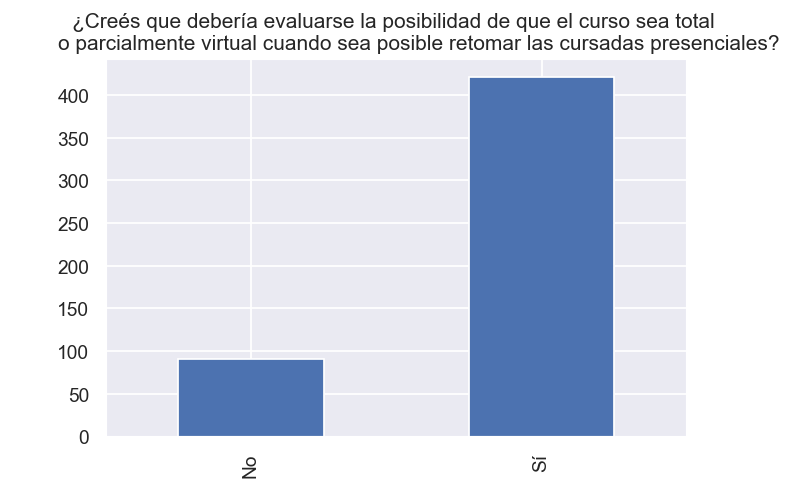

In [30]:
comp[
    "¿Creés que debería evaluarse la posibilidad de que el curso sea total o parcialmente virtual?"
].replace({"Si": "Sí"}, inplace=True)

plt.figure(dpi=125)
ax = (
    comp[
        "¿Creés que debería evaluarse la posibilidad de que el curso sea total o parcialmente virtual?"
    ]
    .value_counts()
    .sort_index()
    .plot(
        kind="bar",
        title="""¿Creés que debería evaluarse la posibilidad de que el curso sea total 
        o parcialmente virtual cuando sea posible retomar las cursadas presenciales?""",
    )
)

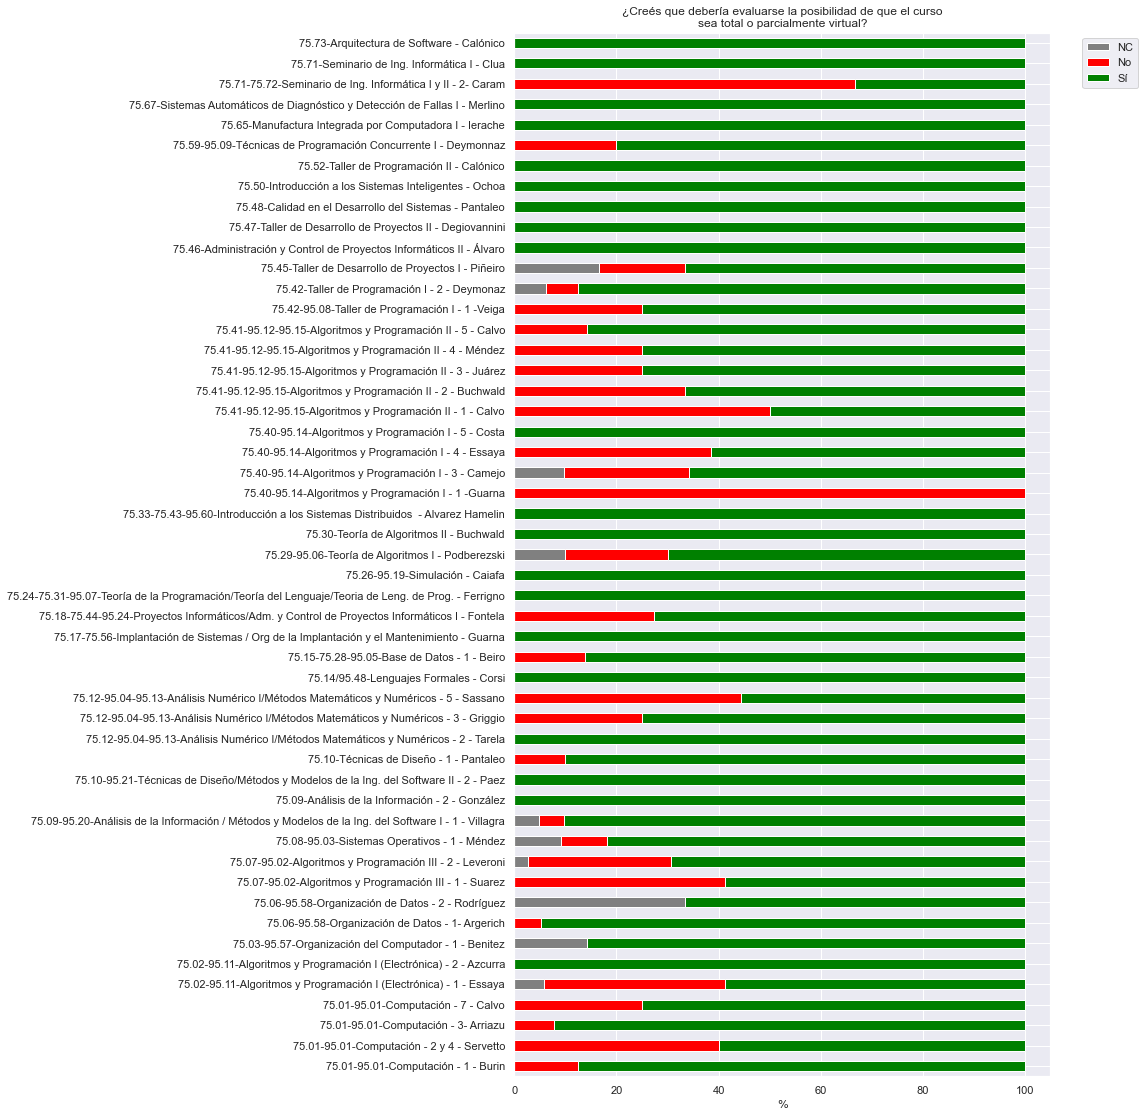

In [31]:
agg = (
    comp.fillna(
        {
            "¿Creés que debería evaluarse la posibilidad de que el curso sea total o parcialmente virtual?": "NC"
        }
    )
    .groupby("Elige el curso")[
        "¿Creés que debería evaluarse la posibilidad de que el curso sea total o parcialmente virtual?"
    ]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .mul(100)
)

ax = agg.sort_index().plot.barh(
    stacked=True,
    figsize=(6.4 * 1.5, 4.8 * 4),
    color=["gray", "red", "green"],
    title="\n".join(
        wrap(
            "¿Creés que debería evaluarse la posibilidad de que el curso sea total o parcialmente virtual?",
            60,
        )
    ),
    ylabel="%",
    legend=False,
)

ax.set_ylabel("")
ax.set_xlabel("%")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

## ¿Estás conforme con la forma en que el curso evaluó sus contenidos? ¿Te sentiste cómodo/a?

In [32]:
for curso in sorted(comp["Elige el curso"].unique()):
    display(Markdown(f"## Curso {curso}"))
    com = (
        comp[comp["Elige el curso"] == curso][
            "¿Estás conforme con la forma en que el curso evaluó sus contenidos? ¿Te sentiste cómodo/a?"
        ]
        .dropna()
        .drop_duplicates()
    )
    if com.empty:
        display(Markdown("_No hay comentarios_"))
    else:
        com_count = com.str.capitalize().value_counts().to_dict()
        for com, count in com_count.items():
            com_suffix = ""
            if count > 1:
                com_suffix = f"**({count} respuestas idénticas)**"
            display(Markdown(f"- {com} {com_suffix}\n\n"))

## Curso 75.01-95.01-Computación - 1 - Burin

- Si **(2 respuestas idénticas)**



- Muy disconforme  



- Si estoy conforme 



- Si me senti comodo incluso siendo la primera vez que veia la materia con temas bien explicados   



- No 



## Curso 75.01-95.01-Computación - 2 y 4 - Servetto

- Si **(2 respuestas idénticas)**



- Estoy conforme con el método de evaluación, y me sentí muy cómoda. 



- Sii me sentí comoda 



- Si, estuvieron bien las formas de evaluación  



## Curso 75.01-95.01-Computación - 3- Arriazu

- Estoy 100% conforme 



- Si 



- Sí  



- Sí, mucho  



- Muy conforme. el hecho de que no tomen un único parcial con muchos contenidos y, en cambio, lo dividan en mini parciales evaluando menos cosas, me motivó mucho más ya que tenía que mantener un ritmo constante. 



- Si, estuve conforme y cómoda 



- Si,si 



## Curso 75.01-95.01-Computación - 7 - Calvo

- Si **(2 respuestas idénticas)**



- Sí. sí. 



- Sí  



- Nuevamente, el curso satisfizo todas mis expectativas y las superó. por ende, su desempeño en cuanto a la evaluación de contenidos no es una excepción. la profesora calvo trajo siempre power points muy bien elaborados y con contenidos explicados de manera muy clara, además de tratar temas muy interesantes como la arquitectura de una computadora basado en el modelo de brookshear. 



## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 1 - Essaya

- Si **(2 respuestas idénticas)**



- Me sentí cómodo, acompañado, fue divertido, llevadero, interesante y te emociona de vez en cuando a seguir o a meterte más en los temas 



- Salvo el último parcial, pondría un 10 en todo a la cátedra  



- Me parecieron demasiadas tareas a entregar (ejercicios obligatorios, parciales y el trabajo final). todas las semanas había que estar preparando o un parcial o un ejercicio y no daba tiempo para realizar las guías y poder ir de a poco. 



- Me pareció perfecta la idea de varios parcialitos 



- Más o menos, porque era demasiado lo que pedían. era una semana tp y a la siguiente parcial, sumado a que hacemos otras materias y que hay que corregir los trabajos. es imposible llevarla así. 



- Verdaderamente si, muy eficiente y dinámico  



- Los examenes fueron extremadamente faciles en comparacion con el tp1. el tp1 es muy dificil y largo. se tomó una evalucion cada 3 semanas con ejercicios obligatorios en el medio y por ultimo un tp muy largo, es excesivo. lograr llevar la materia al dia consume mucho tiempo. 



- A pesar de no haber aprobado, el método de evaluación con tps está bueno, pero los parciales escritos no creo que sean la mejor idea. 



- La verdad es que no del todo, por parte de los tps al tener muchos correctores las correciones son muy distintas y cosas que para uno es un error para otro no y ha pasado en varios tps, la meteria la curse con un grupo y haciamos los tps por discord compartiendo logica algoritmica cuando nos trababamos, cuando llegaban las correcciones en alguna hemos tenido el mismo error y algunos aprobabamos y otros no lo que nos parece medio raro, ahora por parte de los parcialitos la realidad es que no estoy muy deacuerdo en que repitan los mismos mismos enunciados que en cuatrimiestres anteriores por que, mas de uno se toma que programar es memorizar los parcialitos viejos o justo lo hicieron un rato antes y se acuerdan la logica por arriba, cuando yo creo que programar es mas que eso y ademas me he dado cuenta al ayudar a mis compañeros de todo el curso en los tps cuando se trababan, la mayoria de errores es porque en realidad no entiende lo que hacen y hacen las cosas de memoria o replicando lo de las teoricas por lo que vi que hay dos temas que no entienden del todo y no saben aplicar uno es punteros y el otro el uso de memoria dinamica con estructuras ,etc yo creo que esto ocurre por que a partir del segundo parcialito el errores de memoria dinamica no los toman como algo importante por lo tanto creen que no es necesario. 



- Habiendo empezado con 0 conocimiento de programacion me parecio bastante complicado poder estar al dia con la materia.
los tps o ejercicios obligatorios son muchos y llevan demasiado tiempo, por lo cual tambien se complica estar al dia con las demas materias que curso 



- Me costo mucho a mi las evaluaciones, pero si me gusto la forma de evaluaron en etapas 



## Curso 75.02-95.11-Algoritmos y Programación I (Electrónica) - 2 - Azcurra

- Si 



## Curso 75.03-95.57-Organización del Computador - 1 - Benitez

- Me gusta que los contenidos se evalúen por separado y que se puedan recuperar únicamente los temas desaprobados. 



- Sí, incluso hubo practicas de parciales y el parcial real tenia la misma dificultad.  



- Si 



- Con los otros temas (numérico y abacus) me siento cómodo pero assembler me cuesta horrores pasar el parcial y/o el tp 



- Si, es interesante el tema del parcial virtual dividido en tres sectores que se aprueban individualmente, con la posibilidad de recuperar la parte que no se aprobó. y el tp está ok. 



- Conforme: sí. comodo: sí. 



- Si, de manera virtual es más cómodo. 



- Si, estoy comodo. 



## Curso 75.06-95.58-Organización de Datos - 1- Argerich

- Si **(2 respuestas idénticas)**



- Sí, bastante 



- Si, me sentí cómodo y fueron muy claros a la hora de evaluar 



- Muy comodo! 



- Estoy muy conforme con las clases téoricas, después los tps siento que tuvieron mal distribuida la carga. para algunos tps me sobró un montón de tiempo y para otros ni siquiera llegué 



- Super 



- Si, los tps eran desafiantes pero no imposibles, incentivaban a investigar y, ante cualquier problema, los correctores estaban para consultar 



- Estoy conforme, la exigencia es muy alta pero se pudo aprobar  



- Sí, la forma de evaluar los contenidos de la materia mediante trabajos prácticos que integren los temas vistos a lo largo de dos o tres clases teóricas me parece excelente. 



- Sí 



- Creo que la modalidad actual es mucho mejor que las anteriores ya que los tps al ser individuales no corres riesgo de quedarte solo en un grupo por abandono de otros, y la aprobación depende exclusivamente de el esfuerzo personal. 



- Estoy conforme con la forma en la que se evaluaron los contenidos. 



## Curso 75.06-95.58-Organización de Datos - 2 - Rodríguez

- Si 



- Se basa demasiado en trabajos grupales, al tener un mal grupo se hace muy complicado llevar la materia en conjunto con otras 



## Curso 75.07-95.02-Algoritmos y Programación III - 1 - Suarez

- No, son la peor catedra en la que curse. explican todo a las chapas y mal  



- No, muy relativo en cuanto a los correctores.  



- Sí 



- No y no. 



- Para el parcial nos recortaron 45 minutos de examen y creo que esperaban algunas metodologias que todavia no habian sido introducidas en las clases teoricas... 



- No. evalúan cosas que no explican y apenas te dan un pantallazo de lo que tenes que dar en un tp o evaluación dos clases antes. no administran bien el cronograma. pretenden que entregues tps en una fecha y se toman un mes para corregir. siendo algunos tps eliminatorios de la materia. 



- A nivel temas y material estuvo a la altra, pero siento que a nivel de clases teoricas principalmente estuvo muy por debajo. hubo pocas clases teoricas destacables ya que el contenido era muy resumido y repetitivo con respecto a las lecturas solicitadas para las clases 



- No, siento que fui evaluado con distinto criterio que mis pares, lo mismo para otros compañeros. 



- Este curso fue muy malo, paupérrimo. existe una variación enorme entre los criterios de corrección de un corrector a otro en cuanto a parciales y también trabajos prácticos. 
un error en un parcial podía restar poco para un corrector y mucho para otro.
en los trabajos prácticos, la exigencia de un tutor a otro varía muchísmo.
y como algo general, se daba muy seguido que se pidan y evalúen cosas que no se enseñaron ni se había indicado que se evaluaría. 



- El primer trabajo practico permite una reentrega pero baja drasticamente la nota maxima del mismo, teniendo en cuenta que uno de los focos de la materia es el refactoring no me parece logico que pierdas 4 puntos despues de una instancia 



- No, es mucho contenido y mal dado 



- No 



- No, estoy muy incómodo con la cátedra, padecí la materia y la terminé odiando. detesto algoritmos 3 y todo su cuerpo docente de suárez exceptuando a joaquín gomez que la verdad colaboró mucho a que se banque al menos un poco 



- Si 



## Curso 75.07-95.02-Algoritmos y Programación III - 2 - Leveroni

- Si, muy conforme **(2 respuestas idénticas)**



- Si **(2 respuestas idénticas)**



- Si. se evaluo de forma constante los contenidos mediante tps y cuestionarios, lo que facilitaba mantenerse al día con la materia. 



- En esto, no. los contenidos evaluados en el 2do parcial fueron los mismos que en las clases? si, pero eran tomados de forma similar en tema de dificultad y duracion, aunque en las clases estos mismos trabajos eran de a 2 y con dias para hacer. no hubo ningun momento en el que nos preparemos para tener que hacer las cosas a una velocidad mayor, y mismo en cada cosa que haciamos, estabamos de a pares, ademas de que, no se cuantos si, pero no tuve la necesidad de programar 5hs seguidas en el mismo programa solo, llega un punto en el que pasaron 3hs o 4hs y ya mentalmente estas trabado, y no, no se puede pedir que se tomen tiempo en el examen para frenar, por que el tiempo realmente no lo permitia. tanto el primer parcial como los tps, en mi opinion, fueron muy buenas instancias de evaluacion, pero no pense lo mismo del segundo parcial, ni de ninguna de sus instancias. 



- Si, me pareció muy buena la comunicación entre docentes y alumnos y me parecieron justas las correcciones. 



- Super, pienso que es una de las materias de fiuba donde mas aprendi realmente. el conocimiento te queda despues de la cursada. se aprende de manera progresiva y muy completo 



- Los contenidos se evaluaron en su completitud y de manera clara, por lo que estoy conforme. me sentí cómodo cursando ya que los temas a ver fueron bien señalados, por lo que pude tener una imagen clara de lo que debía aprender y practicar. además, los docentes y ayudantes de la cátedra son muy buenos dando clases e interactuando con los alumnos. 



- Estuvo genial 



- Si, muy 



- El contenido de la materia es tan interesante como subjetivo, y eso da a lugar a correcciones dudosas. nada que ver a las materias de computación que venía cursando. después los docentes todos re predispuestos y buena onda, se puede ir a revisión. 



- Sí, me parece que los contenidos fueron evaluados de forma adecuada. 



- Muy cómodo, las clases te preparaban perfectamente para lo que evaluaban y la exigencia que iban a tener para corregir. 



- Si, bastante menos exigente de lo que esperaba en verdad 



- Sí, excelente  



- Sí 



- Si! 



- Mas o menos, los parciales fueron (en especial el segundo) excesivamente largos para hacer en el tiempo dado (4hs) 



- Me gusto mucho como se evaluó la materia hasta el segundo parcial. este fue excesivamente largo y siento que para resolverlo había que hacer algunas cosas q ellos no recomendaban 



- Si, de sobra 



- Tengo mis críticas, pero después fueron muy considerados con las correcciones y eso se valora mucho 



- Sí, absolutamente conforme. 



## Curso 75.08-95.03-Sistemas Operativos - 1 - Méndez

- Si, pero son muchos parcialitos y tps 



- No. el parcial razonablemente complicado. mariano parece acorde para corregir, de todas maneras. los tps son muuuy heavys y si no te toca alguien que corriga rapido la pasas mal. que en el tp3 te rompa algo del tp1, del cual no tuviste correccion es muy jodido. 



- Si 



- Si, pero pobres, como son pocos profes, muchísimos tps y muchos alumnos, el resultado es décadas en corregir tps. 



- Malisimo, una falta de respeto el tiempo que tardan en corregir. 



- Los tp están buenos para ver mas practico lo de la teorica pero dan la sensacion de ser excesivamente profundos en algunas cosas llegando a ser hasta demasiado complicados 



- Muy justas las correciones de los tps y de los parciales. 



- Sí 



## Curso 75.09-95.20-Análisis de la Información / Métodos y Modelos de la Ing. del Software I - 1 - Villagra

- Si **(3 respuestas idénticas)**



- No. las cosas del classroom que corrige villagra es totalmente aleatoria la nota y es, sin dudas, lo peor del curso por lejos.  



- Si, me senti comodo 



- No, la idea de que las actividades sean de una semana para la otra considerando que los estudiantes trabajan, cursan otras materias, etc y si bien podes no entregarlas todas las semanas esto te condiciona un montón para la promoción, capaz con un tiempo de entrega de 15 días darías más flexibilidad para hacerlas bien y no a las apuradas 



- Si, hay muchos contenidos interesantes, es una materia exigente porque hay mucho material para analizar, llevarla al dia es fundamental. 



- No. en lo personal jamas entendi la finalidad del curso, no sabia si la finalidad del curso fue programacion web, metodologias agiles, organizacion de una empresa, construccion de software o contexto de una empresa. 



- No, para nada conforme. la forma de evaluar las actividades era muy poco clara. cuando mis compañeros o yo preguntabamos sobre alguna duda respecto a las mismas, o incluso cómo interpretar ciertos enunciados, nunca se despejaban las dudas, sino que se respondían con el típico "entender el enunciado es parte de lo que se evalúa" o incluso mandándote a releer el material. por otro lado, para las actividades de modelado, si bien en las devoluciones hay comentarios del profesor con los errores, nunca se sabe cuál fue el más grave, o cuántos puntos costó cada error. prácticamente era un juego de adivinar qué querían que respondas exactamente, porque si no era ese modelo idéntico que esperaban, el puntaje era como tirar una ruleta entre 20/100 y 60/100. esto perjudica mucho teniendo en cuenta que las actividades no tienen reentrega, es decir que si uno quiere promocionar va a estar revisando una y otra vez a ver si no se le escapó algún error, y se torna muy frustrante muy rápido. leyendo encuestas anteriores, evidentemente siguen usando una metodología de evaluación de cuando tenían 20 alumnos como máximo, y cuando empezaron a tener más de 80 inscriptos, no la actualizaron. lo único que rescato fue el uso de classroom, que además permitía calcular la nota individual según la ecuación del % de las actividades 



- No, la evaluación individual es simplemente una pérdida de tiempo total. consiste en actividades sin sentido, como producción de textos, cuestionarios completamente inútiles, en los cuales tenés que sacar la información de un libro de más de 1000 páginas (por lo que terminás haciendo ctrl+f y listo), además de actividades de modelado uml. la corrección de los diagramas es completamente arbitraria. he entregado tareas resueltas de forma muy similar a lo que habían hecho otros compañeros y tuvimos notas muy distintas, aunque nos corrigió la misma persona (sergio villagra). además, si tenés un error muy pequeño, te bajan una bestialidad de puntos y eso impacta en tu puntaje general, del que necesitás 60/100 para promocionar la materia. quizás te equivocaste en un concepto y te ponen 20/100 en un diagrama, y eso te baja muchísimo el promedio. y por cierto, no hay reentrega de estas actividades individuales. en cuatrimestres anteriores sí había reentrega, pero decidieron sacarla porque "no llegaban a corregir". ahora, yo me pregunto ¿y si bajan la carga de tareas semanales, pero le ponen reentrega?. de esta manera recibirían muchísimas menos quejas. 
no tiene sentido la exigencia de este curso en comparación a lo que uno se lleva de la materia. te consume una cantidad de tiempo irrisorio, porque antes de hacer las actividades semanales (que son varias), tenés que ver uno o dos videos de 40 minutos en promedio. estos consisten en sergio villagra leyendo un power point, en una plataforma en la que no se puede adelantar el video, ni ponerlo en x2, y que tiene preguntas en medio del video. lo más gracioso de esto es que hay videos que no aportan nada, son simplemente definiciones que las escuchas hoy y mañana te las olvidás, porque nunca las mencionan de nuevo ni vale la pena mencionarlas. igualmente no estoy diciendo que tendrían que evaluar ese contenido aparte, simplemente que no lo den, o al menos no de esa manera porque no tiene sentido. 
por último, está el tp grupal que consiste en armar un abm con front y back funcional en las últimas semanas. es una barbaridad de trabajo para el tiempo que dan, porque además de eso hay que documentar todo lo que se hace y capaz que hacerse cargo del trabajo de otros grupos de tu "tribu". por lo menos en este caso la evaluación es mejor, hay espacio para consultas y en ese momento ya no hay actividades individuales que consuman tu tiempo. mi humilde consejo es que recorten el tiempo que se pasa mandando videos y actividades inútiles, y le dediquen una o dos semanas más al tp, porque le tenés que dedicar todo tu tiempo y se llega con lo justo, además de que es la única parte de la materia en donde se aprende algo útil. no agregaría un parcial porque es claro que el criterio de corrección va a ser desastroso, además de que no vale la pena evaluar estos temas en un examen. 



- Envían cuestionarios semanales multiple choice a responder con lecturas de apuntes, que si no usa la herramienta de búsqueda de los pdfs, es muy complicado llegar semana a semana a completarlos todos. mas que nada si se cursan otras materias y se trabaja. por si solos los cuestionarios no son excesivos, pero si a eso le agregamos las tareas de desarrollo + las tareas del trabajo grupal + los videos, se suele hacer bastante pesado. 

por otro lado, me pareció que hubo una falta de feedback del trabajo práctico grupal. recién en las últimas semanas tuvimos reuniones, donde nos dijeron que marchaba bien, y después al final del cuatrimestre aparece una nota sin ningún tipo de justificativo ni corrección. siento que podría haberme llevado muchísimas cosas más del trabajo grupal si nos hubieran dicho que hicimos bien y que hicimos mal, aunque sea al final de la cursada.

en un momento de la cursada incluso habían dicho que no iban a dar feedback de las actividades individuales porque eramos muchos, por suerte al final si lo hicieron (en los comentarios de las tareas, ponen un copy paste de correcciones generales y un pequeño comentario individual al final, al menos eso sucedió con las mías). sin esto también esas tareas no habrían aportado nada. agradezco que lo hayan hecho! 



- No, son excesivas la cantidad de trabajos individuales, te consume muchísimo tiempo, son siempre 4-5-6 actividades por semana que toman mucho tiempo, y si te atrasas una semana ya tienes al menos 10 pendientes y se hace imposible volver a estar al día, es absurdo que sean tantas y mucha con temas de 1970 



- No, a veces no se entendían los criterios de evaluación y eso causaba confusión entre los compañeros 



- Es bastante pesado el hecho de tener que entregar, no uno, sino varios trabajo todas las semanas (excepto las ultimas semanas donde tenes que dedicarle el 100% de tu tiempo al tpg, como si fuera la unica materia que cursas).  sin embargo es mejor esto que un parcial ya que no me quiero imaginar el criterio nefasto que deben tener para corregilo. 



- Si, estuve cómoda  



- Sí 



- La modalidad de cursada consiste en la elaboración de ejercicios individuales semanales (catalogados como "desarrollo", "texto" o "cuestionario") que pueden consumir su tiempo si se quiere hacerlos bien (no más de 6 hs por sem.). no hay ni parcial ni final, y hay un tp grupal (entre 4 y 5 integrantes) que dura la totalidad del cuatrimestre y se presenta al final del mismo. la materia en sí se puede resumir como el trabajo que realiza un "analista funcional".

marcado esto (ver tambien la respuesta de la pregunta siguiente de la encuesta), y dado el potencial tiempo que requiere la cátedra, recomiendo fuertemente anotarse a la cátedra de gonzalez, sobretodo si se quiere tener un cuatrimestre sin sobresaltos ni malos tragos (y si tienen compañeros con los que comparten varias materias, mejor). 



- Si, fue una evalación justa 



- No. no. 



- No tanto, su forma de evaluar se inclinaba un poco hacia el lado subjetivo, un profesor podía considerar que cierto contenido estaba aprobado mientras que otro podía pensar que ese mismo contenido no alcanza para estar a sus estándares 



- Tal vez el enfoque de "largar" al alumno solo con la descubierta del tp grupal genera mucho desconcierto, sobre todo en las primeras instancias 



- Individualmente mas o menos, el tp grupal me parecio demasiado por lo que la catedra brindo (detallo en el comentario final) 



- No.

la evaluacion de contenidos se dio mayormente por actividades individuales, sobre temas que muchas veces no se enseñaron, con falta de ejemplos, feedback insuficiente y sin posibilidades de reentrega o mejora.

el tp grupal es un desarrollo super simple ( si ya conoces de desarrollo web, si no lo vas a tener que aprender solo/a en 2 semanas porque no te explican nada ), pero esta super orientado a documentacion, 80% del tiempo se pasa documentando y las ultimas semanas se tiene que implementar.
casi que no recibimos feedback del mismo. tuvimos que hacer un monton de documentacion que no nos sirvio para nada y pareciera que ni miraron. 



- La evaluacion son muchas actividades semanales individuales y pasando mitad de cuatrimestre se arranca un trabajo practico grupal. la idea esta buena pero no me parece que se lleva adelante de la mejor manera 



- No, muchas veces las evaluaciones parecían arbitrarias. el enunciado decía "hagan a,b y c" y a la hora de la corrección decían "les faltó hacer d que no estaba en el enunciado pero era obvio" o decía "no vamos a bajar puntos por este error" y luego te desaprobaban por eso. 



- Si. 



- No 



- El temario de la materia me pareció interesante, pero la forma de evaluar los conocimientos, con el tp grupal, no concordaba con lo estudiado. en mi opinión, esta materia se debería cursar en uno o dos años. la idea de armar un proyecto similar al trabajo en una empresa es buena, pero creo que es muy temprano en la carrera para implementar esta idea. en mi squad, la mayoría no había trabajado en it, tuvimos que aprender cómo armar una base de datos, cómo deployar una app, cómo comunicar diferentes sectores del tp, etc (que no son los temas centrales de la materia) todo de cero. tengo la sensación de que podría haber aprendido mucho más si la hubiese cursado en uno o dos años. 



## Curso 75.09-Análisis de la Información - 2 - González

- Si 



## Curso 75.10-95.21-Técnicas de Diseño/Métodos y Modelos de la Ing. del Software II - 2 - Paez

- Si **(2 respuestas idénticas)**



- Super comodo 



- Sí 



- Completamente conforme.  



- El tp final fue más exigente de lo que esperaba. tuve que dejar una materia para llegar con los tiempos. entiendo lo que se quiere enseñar, y no es difícil en sí mismo, el problema es que lleva mucho tiempo lograr los estándares mínimos de aprobación de cursada. 



- Si, estoy conforme 



- Los cuestionarios son el único punto que para mí se debería revisar, el resto de las instancias evaluativas me parecieron adecuadas. 



## Curso 75.10-Técnicas de Diseño - 1 - Pantaleo

- No. toman lo que quieren. una verdadera loteria 



- Si. 



- Si 



- No 



- No, el profesor no da devolucion de las evaluaciones por lo que uno no sabe que hace bien y que hace mal 



- Falto profundidad y coordinación entre los contenidos vistos en la teórica y luego en la práctica  



- Si. muy comodo. 



- Si, estoy de acuerdo en como se evalua. 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 2 - Tarela

- En general, sí. creo que algunas clases teóricas podrían haberse entendido mejor si se daban presencialmente.  



- En mi caso no hubo mucho impacto pero algunas notaciones no eran consistentes a lo largo de la cursada, lo que tuvo un impacto negativo en algunos compañeros a la hora de entender un tema o rendir un examen 



- Si. 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 3 - Griggio

- Estoy conforme. 



- Si 



- Si, los tps y parciales fueron adecuados con los contenidos vistos 



## Curso 75.12-95.04-95.13-Análisis Numérico I/Métodos Matemáticos y Numéricos - 5 - Sassano

- Si **(3 respuestas idénticas)**



- Me pareció que el tp estaba bueno para darle una aplicación a los temas tan teóricos que veíamos sin embargo nos lo dieron muy a fin de cursada, bastantes desorganizados. por otro lado, siento que es inútil que una materia del depto de computación tenga parciales y finales en papel en los cuales hayan que hacer cuentas largas que en realidad son para programar en una computadora. terminas saliendo un experto de la calculadora. es una materia que da para tener un enfoque mucho mas de programación o al menos no tan tradicional. 



- Sí  



- Si, todo excelente la verdad.  



- Si y si 



- Sí 



- No lo se, la verdad no pude presentarme a las evaluaciones, pero fue por cuestiones personales.  



## Curso 75.14/95.48-Lenguajes Formales - Corsi

- Si 



- Sí 



- El curso fue muy dinámico, y todo se evaluó de forma que sirviera para el tp final que de hecho fue muy completo y me ayudó a consolidar los temas. los profesores siempre están dispuestos a ayudar y a que uno aprenda. 



- Si, creo que fue justo 



- Sí, muy cómodo y conforme. 



## Curso 75.15-75.28-95.05-Base de Datos - 1 - Beiro

- Si **(2 respuestas idénticas)**



- Si, los contenidos son bastantes. para lo que es el parcial supongo que están bien. 



- Si, se explicaron muy bien todos los temas 



- Si, me parecio justo. 



- Sí. los parcialitos ayudan mucho a llevar la materia al día. el parcial quizás es un poco largo para el tiempo que se da, incluso sabiendo los temas llegas justo. 



- Si, la modalidad de parcialitos por temas, esta muy buenas. te ayuda a llevar al día la materia y estar preparado para el parcial. 



- Todo perfecto, el examen me pareció acorde a lo explicado y visto en clase, aunque el tema de diseño relacional creo que no se explicó del todo claro aunque a fin de cuentas, en el examen tomaron ejercicios que se alineaba con lo explicado en clase 



- Si, 10 puntos 



- Si y si 



- Muy cómodo. todo muy claro desde el día cero. las evaluaciones son las mejores que vi en mi vida. se disfruta estudiar para el final. son todos ejercicios distintos, increíblemente no repite ejercicios mariano. y todos son ejercicios que te hacen reflexionar y pensar muchísimo.  



- Los contenidos fueron evaluados adecuadamiente 



- Si, aunque sentí que era un poco cargado demás el temario 



- Si, si 



- En general si, quizás el final un poco excesivo de dificultad  



- Si. si bien no aprobé, me gustaría mas practica de un tema en particular, pero son muy buenos organizando clases virtuales. 



## Curso 75.17-75.56-Implantación de Sistemas / Org de la Implantación y el Mantenimiento - Guarna

- Si 



## Curso 75.18-75.44-95.24-Proyectos Informáticos/Adm. y Control de Proyectos Informáticos I - Fontela

- Si **(2 respuestas idénticas)**



- Muy conforme, los docentes más que capacitados tanto en conocimiento como humanamente.
el régimen de promoción no es para nada difícil, lo cual se agradece, un final menos que estudiar :).
los parcialitos iban directo al punto, sin vueltas, y para el que leyó como correspondía no implicaban mucha dificultad. 



- Si, considero el sistema justo y 
 transparente , fue explicado el día 1 



- Si estoy conforme y me sentí cómodo. 



- Si, soy un hijo del rigor, agradezco el parcialito de cada clase. y aplicar los temas vistos en la teoría al trabajo practico siempre es algo bueno. 



- Sí 



- Muy conforme, me sentí super comodo 



## Curso 75.24-75.31-95.07-Teoría de la Programación/Teoría del Lenguaje/Teoria de Leng. de Prog. - Ferrigno

- Si 



## Curso 75.26-95.19-Simulación - Caiafa

- Estuvo muy bien, pero creo que hubiera preferido un poco menos de foco en las guías de ejercicios a cambio de tps más grandes, un poco más desafiantes y que incorporen modelos más complejos. 



- Si. los parciales tenian ejercicios similares a los de la guia y los tps estuvieron interesantes 



- Si, me parecio correcto lo que evaluaron 



- La corrección fue muy buena, analizaban todo el trabajo práctico en profundidad y en general era bastante abierto el tp para implementarlo como vos quisieras a partir de un paper. una gran materia para hacer. 



- Si 



## Curso 75.29-95.06-Teoría de Algoritmos I - Podberezski

- En los trabajos prácticos se corregía cualquier cosa. una vez nos corrigieron que "el índice estaba en la misma página que la carátula" y otra que "el informe se debe escribir en tercera persona, no en primera". me parecen correcciones bastante patéticas para una materia que toca temas interesantísimos. no hay un mínimo interés por revisar bien los trabajos prácticos entregados, uno se esfuerza por implementarlo de forma eficiente y ni lo verifican, la respuesta a veces es "el programa no devuelve lo pedido" y listo. y eso puede significar que no calcula bien o que directamente estás imprimiendo un formato que no es en consola, como 'viajes: 10, costo: 5' en vez de 'costo: 5, viajes: 10'.
fue muy dificil aprobar los tps sin reentrega por la cantidad de cosas tontas que marcaban como mal hecho. además, había que esperar como 3 semanas para reentregar un tp cuando a veces las correcciones llevaban menos de 10 minutos.

las defensas de tp fueron además una cosa patética. depende quién te tomaba el oral aprobabas o no, y también dependía la dificultad de las preguntas. en la primer defensa estuve 1 hora, contesté todas las preguntas menos 1 bien y me reprobaron porque "justo ese tema era el más importante de todos".
la segunda vez que fui me tomó otro docente y me aprobaron en 15 minutos y las preguntas fueron tan básicas como decir cuánto es 2+2 más o menos.

 



- Si 



- Muy conforme 



- Si, me gustaron los temas y los tps estuvieron buenos. 



- Muy bien. pocas cátedras son tan claros y transparentes con la evaluación 



## Curso 75.30-Teoría de Algoritmos II - Buchwald

- Me encantó el enfoque para evaluar, muy adecuado para el enfoque de la materia. 



- Si 



## Curso 75.33-75.43-95.60-Introducción a los Sistemas Distribuidos  - Alvarez Hamelin

- Si 



- La forma de evaluar no fue inadecuada, la forma de corrección quizás si. en el parcial práctico un error arrastrado por distracción donde se podía ver claramente no haber error de concepto, impactó de igual manera en la nota como si el ejercicio hubiese estado mal totalmente. en los trabajos prácticos, haber trabajado o no en los mismos, no parecía influir en la nota: para todos la nota era igual, incluso cuando claramente se podía ver el trabajo realizado por cada miembro. 



- No, la verdad que para nada quedé conforme con la forma de evaluar. en primer lugar nunca se supo como se promociona, parece que depende del ánimo del profesor. en segundo lugar tomaron dos parcialitos cada semana. la cursada se dividió en dos ya que el profesor se tenía que ir a no sé dónde, en los primeros dos meses se vio toda junta la teoría y después toda la práctica (algo que me pareció horrible), por lo que cada 3 días había que leer de 40 a 60 páginas de un libro. luego para un tp nos hicieron grabar un video. durante estos dos años de virtualidad grabé videos, y me gustaron, me quedaron bien. pero nunca vi uno con tan pocos grados de libertad. debía durar casi 10 minutos si o si (cosa que cuesta mucho más porque requiere mucha práctica llegar a un tiempo justo) cuando en todas las otras materias el tiempo es algo estimado, y en esta nos obligaban a encender la cámara (posteriormente varios de esos videos eran compartidos con nuestros compañeros). se que hoy en día casi todo el mundo se saca fotos en todos lados, se graba, etc. y lo publica en todas las redes sociales. pero yo no, no me gusta. no me gusta que se viole mi privacidad, no me gusta filmarme la cara y donde vivo para que lo vea el profesor y mis compañeros. en la parte práctica la cosa no mejoró. el tipo se cree gracioso preguntando cosas y haciendo pasar a compañeros al pizarrón y forreándolos si no saben algo, cuando todos tenemos diferente ritmo de aprendizaje. de lo que duraba la clase práctica mas de la mitad no hacían nada los profesores. eso de dar ejercicios para que los hagamos y que pase uno al pizarrón supongo que es una modalidad válida pero me suena a que lo hacían para que ellos tengan que hacer lo menos posible. con esta modalidad los únicos beneficiados eran los que conocían los temas de la materia y llevaban la materia perfectamente al día. una semana en la que tenías que concentrarte en otra materia y ya corrías el riesgo de ser forreado delante de todos. en cuanto al parcial, muchísimos desaprobados en la primera oportunidad, lo que demuestra que las cosas no se hicieron bien. aunque fueron tantos los desaprobados que hicieron que varios reentreguen un ejercicio otro día para aprobar. por lo que imagino que al departamento le llegó una buena tasa de aprobados, pero fue algo forzado. tuvieron que aprobar a muchos a la fuerza para que no los maten en las encuestas. en cuanto al tp de la práctica, se tuvo que entregar en la misma semana del parcial, muy mal organizados. muchos tuvieron que elegir, si aprobar el parcial o aprobar el tp. y olvidate que tengan tolerancia y permitan a alguien entregar una semana mas tarde como se hace en la mayoría de las materias. estos profesores se creen que ser cuadrados es sinónimo de buena enseñanza. 



- Sí 



- El problema fue el período de 2 clases teóricas a la semana, ya que no me daba el tiempo a leer y procesar los capítulos del libro. más allá de eso, un aspecto que me gustó mucho de la materia es que fomentaban el aprendizaje de distintas habilidades como el inglés, la presentación de proyectos y la lectura de documentación/papers. 



- No. el parcial pasó de ser totalmente práctico en la primera instancia, a ser totalmente teórico en la segunda instancia sin ningún tipo de aviso. el parcial solo debía incluir temas del capítulo 1 a 5 del libro, y en la segunda instancia tomaron temas del capítulo 6 (por ejemplo, icmp). 



- Sí, fue lo esperado 



- No, los profesores te dicen vamos a evaluar este tema y te toman otra cosa diferente 



- Si.
se tomo lo que se dio y se fue muy claro con la forma de evaluacion y los contenidos esperados. 



- No, hubieron 3 trabajos practicos sin posibilidad de reentrega y los mismos tenian fecha de entrega la misma semana que el parcial o recuperatorio. 



## Curso 75.40-95.14-Algoritmos y Programación I - 1 -Guarna

- Sí. 



## Curso 75.40-95.14-Algoritmos y Programación I - 3 - Camejo

- Si **(2 respuestas idénticas)**



- Estoy conforme con la evaluacion y me senti comodo durante toda la cursada 



- No, creo que comparado al cuatrimestre pasado, fue de peor forma 



- Si, la verdad que siempre fueron justos con los contenidos que evaluaron el los trabajos practicos y parciales. los ejercicios del parcial fueron muy similares a los que hicimos en las clases practicas. destaco tambien la creatividad y el esfuerzo puesto en las consignas de los tps que, para mi, generaban una forma novedosa de aplicar los contendos vistos en clase. ademas las paginas propias de la catedra para el parcial y los tps en general son buenas y ayudaron bastante a que la experiencia al ser evaluado fuera mejor. 



- Sip 



- El tp2 asusta pero ahora que se pudieron hacer clases de consulta presenciales fue mucho mejor que virtual. se entiende mucho mas todo 



- Si, tienen una muy buena forma de hacerlo 



- Muy cómodo  



- Si, tanto los parciales como los tps me parecieron muy bien. 



- Si, totalmente 



- Si, me sentí muy cómodo 



- Me gusto mucho que el parcial sea virtual ya que pude rendir desde mi computadora que ya sabia la disposición de todos los caracteres. me sentí mas cómoda de esta manera 



- Tuve un muy muy pequeño mal entendido pero fue una confusión todo lo demás fue 10 puntos. 



- Estoy muy conforme 



- Si, los trabajos practicos fueron muy buenos para entender bien todos los conceptos, tenian bastante dificultad pero terminabas con los temas mucho mas claros. 



- Si, me siento comodo 



- Totalmente 



- Sí, estoy conforme con el método de evaluación y me sentí muy cómodo. considero que los trabajos prácticos realmente servían para poner en práctica lo aprendido y para demostrar si habíamos entendido los temas o no. en cuanto a las correcciones de los mismos, en general me parecieron útiles, si bien creo que en algunas cuestiones es necesario que los correctores unifiquen criterios, para que lo que uno haga no dependa del corrector que le toque. pero es realmente lo único negativo que puedo nombrar al respecto. 



- Completamente. 



- Si, tanto el parcial como los tps me parecieron muy acertados  



- Me pareció que el curso evaluó correctamente en el parcial y en los trabajos prácticos.  



- Si. 



- Sí 



- Me siento bastante conforme. creo que los contenidos fueron evaluados de forma creativa y tal que sean mas amenos de entender 



- No y acá creo que fue donde la cátedra la pifió bastante. si bien el tp1 era acorde a lo visto y bastante introductorio, ya a partir del tp2 la escalada de dificultad fue rápida y encima hay temas que se dieron muy por encima; la explicación del tp fue bastante escueta y sin terminar de aclarar poco y nada realmente (cosa que causó multitud de preguntas en el mencionado discord que nos habían habilitado, las cuales se podían haber contestado aclarando mejor las cosas en esa presentación). además creo que la cátedra debería considerar mejor a las personas que elige como sus ayudantes, hay algunos que no están lo suficientemente preparados para el puesto más allá de la "buena onda" que le pongan. en el tp se trata de qué corrector te toque y dependiendo de eso tu experiencia con la materia varía enormemente; en mi caso con el primer tp tuve a un corrector que valía la pena y con el que entendí muchos temas con los que no cazaba una en un primer momento, pero esto cambió en el segundo donde el corrector que tuve no era capaz de darme respuestas coherentes a lo que le preguntaba (motivo por el que discutimos en muchas ocasiones). encima terminaba echándome toda la culpa a mí y comentaba lo que tendría que corregir "porque la carrera es así y hay que acostumbrarse", momento en el que decidía cambiar de tema porque el motivo de que habláramos era única y exclusivamente el tp. 



- Salvo algunos problemas de inestabilidad durante ciertos momentos de mucho tráfico, la página utilizada para evaluar los trabajos prácticos me pareció un buen recurso. también fueron claros en los contenidos que se iban a evaluar, y respondían todas las dudas con respecto a los estándares de la cátedra para las buenas prácticas de programación. mi única queja es que para el tp3 la información sobre la metodología de evaluación de chanutrón era insuficiente, y tuve que replantear el flujo de mi programa varias veces porque, si bien funcionalmente era lo que se pedía, no era lo que chanutrón esperaba y fallaba algunas pruebas de cosas que sí funcionaban 



- Si, pese a no haber aprobado por motivos personales, sentí que fue una cursada de gran nivel 



- Si, estoy conforme. 



## Curso 75.40-95.14-Algoritmos y Programación I - 4 - Essaya

- Si **(2 respuestas idénticas)**



- Si  **(2 respuestas idénticas)**



- Sí 



- No, me parece que el punto más flojo de la materia son las evaluaciones en papel. nos explicaron que era difícil evitar que se copien. 
igualmente si se encontrase la forma de rendir en una computadora donde se puede empezar a programar sin miedo de tener que borrar y con todas las herramientas del editor de texto (que es como se programa siempre) en mí opinión mejoraría muchísimo la experiencia. 



- Muy cómodo. 



- Realmente conforme, comodo en todo momento 



- Si, totalmente conforme, excelente cátedra, muy buenos docentes. 



- Si y si.  



- Si, muy buena la forma de evaluación  



- Si, completamente. 



## Curso 75.40-95.14-Algoritmos y Programación I - 5 - Costa

- Si, muy cómodo. los profesores estuvieron muy dispuestos a ayudar para hacer mejores entregas. 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 1 - Calvo

- No me sentía comodo con como iban las clases virtuales en especial la práctica. a pesar de ello, la teoría presencial era más interesante porque se le prestaba más atención y a las consultas que se le podía hacer al profesor/a. 



- Si 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 2 - Buchwald

- Si 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 3 - Juárez

- Si 



- Cómodo.  



- Excelente, la politca de solo tp y no evaluaciones da mucha versatilidad y quita presion inecesaria. 



- Para mi estuvo bien, yo probaria meter un parcialito entre medio para obligar a repasar un par de conceptos , los tps estuvieron largos pero estaban buenos en mi opinion, haria un pooquito mas de incapie en hashing ( por que personalmente me gusto mucho el tema), por lo demas todo correcto. 



- Está muy bueno que sean tres tp, lo único que mejoraría es que todos los docentes tengan la misma medida a la hora de evaluar y corregir. 



- La verdad que no estoy conforme, el profesor al principio de la cursada dice que se puede promocionar alcanzando el 80% de los puntos totales, los cuales se van ganando con la entrega de los tps. algunas semanas antes de finalizar la cursada agregó un examen oral que valia el 50% de la nota del que no estabamos enterados, lo que se superpuso con la entrega del tp3, por lo que no llegó a terminar de tomar a todos y dio la opcion de darlo en los finales. hasta hubiera sido mejor que tomara final, porque te podrías anotar cuando queres así no depender de su disponibilidad para tomar el oral, porque hubo compañeros que quisieron dar en la primera fecha y no pudieron ya que estaban los horarios tomados por otros. otra cosa es que al ser los tps grupales, la materia deja la oportunidad para que alguno de tus compañeros se aproveche y participe poco y nada, promocionando igual. uno de mis compañeros promocionó con re buena nota y lo poco que subia a github ni siquiera compilaba. 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 4 - Méndez

- Si **(2 respuestas idénticas)**



- Muy 



- Sí 



- No debido a la imposibilidad de realizar consultas sobre los tps, teniendo únicamente una instancia de consulta de dudas donde éramos 70 con consultas y volvia dificil siquiera hacer una. 



- Si, el examen virtual es muy cómodo. el final debería ser virtual pero pueden tomarse temas en los que hay que dibujar por lo tanto veo posible un examen presencial 



## Curso 75.41-95.12-95.15-Algoritmos y Programación II - 5 - Calvo

- No, muchísima falta de comunicación, sobre todo en cuanto a como y cuando se debía entregar el trabajo practico. 



- Si 



- Conforme: sí. comodo: sí 



- Me senti comodo, aunque me hubiese gustado que haya mas clases practicas en el tema de grafos 



- Sí 



## Curso 75.42-95.08-Taller de Programación I - 1 -Veiga

- Sí 



-  no 



- Si 



## Curso 75.42-Taller de Programación I - 2 - Deymonaz

- Si **(2 respuestas idénticas)**



- El tp es bastante extenso y en la correción final se fijan mucho en los detalles (por ej en la interfaz, lo cual no aporta nada de conocimiento acerca de los temas que aborda la materia) 



- La materia es muy demandante, pero la forma de evaluar me pareció excelente para un curso de estas características. aprendí muchísimo, cosas interesantes, y no me hicieron perder el tiempo con pavadas solo para cumplir con un régimen de cursada obsoleto. 



- Las clases teóricas siento que fueron muy lentas. mas allá de los temas, creo que deben ser un poco mas didácticas, me costó mucho concentrarme en lo que se daba. en cuanto a las pequeñas partes prácticas que hubo, lo mismo. no están preparadas para  prestar atención mas de 10 minutos. siento que le falta eso a la cátedra, lograr que los alumnos se enganchen con lo que se da. 



- En como se evaluaron si. 



- No. lamentablemente se depende mucho de si tu/s compañero/s tienen las ganas o el tiempo de seguir con la materia al día. me parece que la materia requiere mucho más tiempo para dedicarle que lo que los conocimientos o créditos requerirían. teniendo un trabajo full-time, me fue imposible mantener la carga horaria de ésta materia cuando no todos los integrantes del grupo se pudieron compremeter, siento que perdí un cuatrimestre y muchas horas para nada. todo esto no necesariamente es culpa de los docentes y la cátedra, sino de cómo está armada la materia para con el plan de estudios. 



- No. a mi y varias otras personas con las que me relaciono nos resulto muy difícil llevar la materia manteniendo un trabajo full time y en casos donde de las 4 personas que deberían estar trabajando hay una o mas que no lo hacen, no se proveen soluciones o consideraciones para aquellos que si lo hicieron e intentaron aprobar la materia. 



- No, me pareció que el curso estaba improvisando la manera de evaluar los contenidos  



- Sí 



- Si. 



## Curso 75.45-Taller de Desarrollo de Proyectos I - Piñeiro

- Sí 



- Si estoy conforme y ademas me senti comodo 



- Si 



## Curso 75.46-Administración y Control de Proyectos Informáticos II - Álvaro

- Muy conforme con la cursada 



- Si 



- Si. 



## Curso 75.47-Taller de Desarrollo de Proyectos II - Degiovannini

- Si 



## Curso 75.48-Calidad en el Desarrollo del Sistemas - Pantaleo

- No 



## Curso 75.50-Introducción a los Sistemas Inteligentes - Ochoa

- Si 



## Curso 75.52-Taller de Programación II - Calónico

- Creo que el trabajo practico se hace muy pesado para los que no sabiamos nada de frontend. si te toca un buen grupo con gente con experiencia laboral utilizando las tecnologias que piden para el tp se hace mucho mas facil. 



- Totalmente 



- Si.
la cursada y la evaluacion consiste del desarrollo del trabajo practico.
me parece que si no te toca un buen grupo la materia se puede hacer dificil o hasta imposible. hay que organizarce y desarrollar todas las semanas. 



- Si, siempre fue clara la forma de evaluación. 



- Me parece que el tp es demasiado largo y sino se cuenta con experiencia laboral es casi imposible 



## Curso 75.59-95.09-Técnicas de Programación Concurrente I - Deymonnaz

- Si, el parcial me parecio acorde en cuanto a dificultad y contenido a lo dado en las clases teoricas y practicas. 



- Si 



- Super comodo 



- Si bien no faltaron instancias y propuestas de práctica de ejercicios, al ser opcionales, tuve que relegar algunos frente a otras materias con entregas obligatorias, y eso impactó en la resolución del tp final. o quizá, poder tener alguna instancia de entrega individual donde podamos recibir feedback de la resolución. 



## Curso 75.65-Manufactura Integrada por Computadora I - Ierache

- Si **(2 respuestas idénticas)**



## Curso 75.67-Sistemas Automáticos de Diagnóstico y Detección de Fallas I - Merlino

- Si **(2 respuestas idénticas)**



## Curso 75.71-75.72-Seminario de Ing. Informática I y II - 2- Caram

- Sí 



- Si. 



- Si, totalmente 



## Curso 75.71-Seminario de Ing. Informática I - Clua

- Si **(2 respuestas idénticas)**



- Si, demasiado comodo. la materia esta brindada de forma excelente. 



- Si, muy comodo 



- Si, muy comodo y conforme 



## Curso 75.73-Arquitectura de Software - Calónico

_No hay comentarios_